Plot_Some_HDplusUNet100A_FP16_Hists_18April2023_validation_after_iter1C_2p5 is derived from

  Plot_Some_HDplusUNet100_newHists_14Sept2022_validation_after_iter7C_2p5
  

  
  
------------------  



Derived from Plot_Some_HDplus_KDEs_09_Sept2022_validation

changed to use HDplusUNet100 model

----------------------


Derived from Plot_Some_HDplus_KDEs_31Aug2022_250tracks

Here, we will read in the "arrays" style data (numpy arrays of intervals data already prepared).
This means (amongst other things) that the "bad" events have been removed in advance.

-----------------------------------------


Derived from Plot_Some_KDEs_18Aug2022

The major (initial) goal is to determine whether it is "trivial" to read 200 traack per event rather than 150 and see whether the model will process them correctly.  If so, the question to be answered is whether this will ameliorate the high costs observed for intervals with 150 tracks used and more apparently ignored.

In [1]:
!nvidia-smi

Wed Apr 19 11:39:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   28C    P8    21W / 250W |      3MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

First, we grab matplotlib, and set the old "classic" style for some reason only Rui knows.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('classic')

In [3]:
import numpy as np
import torch
print('torch.__version__ = ',torch.__version__)

torch.__version__ =  2.0.0


These are the local imports. Make sure you import the correct model!

In [4]:
## from model.models import SimpleCNN4Layer_D35_sp as Model
##from model.models_mds_E import FourFeature_CNN6Layer_D as Model
##from model.models_July2022_kde import TrackIntervalsToKDE_HalfDozen as Model
##from model.models_July2022_kde import TrackIntervalsToKDE_HDplus as Model
##from model.models_Sept2022_kde_plus import TrackIntervalsToKDE_HDplusUNet100 as Model

## alt_loss_AAa requires not-NaN for both target and predicted values
from model.alt_loss_AAa import Loss

## this HDplusUNet100A model is a flattened version of the original
## that uses Will's methods
from model.models_16April2023_kde_plus import TrackIntervalsToKDE_HDplusUNet100A as Model




## to read in the tracks and KDE info by interval
##from model.collectdata_kde_Ellipsoids_aug2022_debug200tracks import collect_t2kde_data
##  collectdata_kde_Ellipsoids_MinBiasMagDown_14Nov should ignore "badEvents" and
##  use 250 tracks per interval
##  from model.collectdata_kde_Ellipsoids_MinBiasMagDown_14Nov import collect_t2kde_data
from model.collectdata_kde_Ellipsoids_MinBiasMagDown_14Nov import collect_t2kde_data as collect_t2kde_data_down
from model.collectdata_kde_Ellipsoids_MinBiasMagUp_14Nov import collect_t2kde_data as collect_t2kde_data_up
## added 220909
from model.collectdata_kde_Ellipsoids_Arrays import collect_t2kde_arrays


from model.training import select_gpu
from model.plots_mdsA import plot_ruiplot
from model.efficiency import pv_locations, efficiency
from model.core import modernize

## read in the canonical loss function used for tracks-to-kde algorithms
## and instantiate as for RunModel_IntervalTracks_to_KDE_18Aug2022_HalfDozen_iter3A-testing-10epochs-2em5_fullLHCbMC
from model.interval_kde_loss_Ba_postFacto import Loss
loss = Loss(epsilon=3e-6)

In [5]:
## this function takes an "absolute" interval number and converts it into an original event number and 
## interval within that event assuming there are 40 intervals in each event

def eventID(intervalNumber):
    eventNumber = int((intervalNumber)/40)
    localInterval = intervalNumber - eventNumber*40
    return eventNumber,localInterval

Select a GPU here. Same numbering as the NVidia-SMI tool.

In [6]:
print(torch.version.cuda)
print(torch.cuda.is_available())

11.8
True


In [7]:
device = select_gpu(1)

1 available GPUs (initially using device 0):
  0 NVIDIA GeForce RTX 3090


Pick a file to load.

In [8]:
## mds validation = collect_data('dataAA/Oct03_20K_val.h5',
##validation = collect_t2kde_data('dataAA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5',
validation = collect_t2kde_arrays('dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov_t2hists_Arrays_validation_allEvents.npy',
                            batch_size=64,
                            pin_memory=True,
                            shuffle=False,
##                          device=device,
##                            slice = slice(1600000,None)
                          )



XY_file =  dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov_t2hists_Arrays_validation_allEvents.npy
Loaded dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov_t2hists_Arrays_validation_allEvents.npy in 2.51 s
outer loop X.shape =  (452560, 9, 250)
Constructing 452560 event dataset took 0.3709 s
x_t.shape =  torch.Size([452560, 9, 250])
x_t.shape[0] =  452560
x_t.shape[1] =  9
y_t.shape =  torch.Size([452560, 100])


import h5py
XY_file = 'dataAA/Oct03_20K_val.h5'

with h5py.File(XY_file, mode='r') as XY:
    xmax = np.asarray(XY['Xmax'])
    ymax = np.asarray(XY['Ymax'])

> Note: to get the real PV locations, use `collect_truth('file.h5', pvs=True)` to collect PVs (or SVs with `pvs=False`)

Let's just see how many NaNs we have in the dataset.

In [9]:
## print(*np.sum(np.isnan(validation.dataset.tensors[1].cpu().numpy()), 1))

PV = collect_truth('dataAA/Oct03_20K_val.h5', pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

PV.n.max().max()

PV.cat[0]

SV = collect_truth('dataAA/Oct03_20K_val.h5', pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])

Select a model to load. Make sure it matches the model you imported above.

> #### Mike note:
>
> If you use an old-style model, comment out the `d = modernize(d, 3)` line - that converts the old model key names to the new format.

In [10]:
#name = '/share/lazy/schreihf/PvFinder/models/Dec11_SimpleCNN4Layer_D35_sp_first200epochs_240K_lr_3em5_bs512_Alt_Loss_A_4p5_final.pyt'
##name = '/home/sokoloff/pv-finder/notebooks/Dec21_SimpleCNN4Layer_D35_sp_yetAnother200epochs_240K_lr_1em3_bs512_Alt_Loss_A_4p5/Dec21_SimpleCNN4Layer_D35_sp_yetAnother200epochs_240K_lr_1em3_bs512_Alt_Loss_A_4p5_final.pyt'
##name = '/home/sokoloff/pv-finder/notebooks/Dec21_SimpleCNN4Layer_D35_sp_yetAnother600epochs_240K_lr_3em4_bs512_Alt_Loss_A_4p5/Dec21_SimpleCNN4Layer_D35_sp_yetAnother600epochs_240K_lr_3em4_bs512_Alt_Loss_A_4p5_final.pyt'
##name = 'ML/Aug10_FourFeature_CNN6LayerPlus_TargetsA_First20epochs_160K_lr_1em3_bs64_Alt_Loss_A_3p0/Aug10_FourFeature_CNN6LayerPlus_TargetsA_First20epochs_160K_lr_1em3_bs64_Alt_Loss_A_3p0_final.pyt'
##name = 'ML/Aug11_FourFeature_CNN6LayerPlus_TargetsAA_First40epochs_fixedPert_160K_lr_1em3_bs64_Alt_Loss_A_3p0/Aug11_FourFeature_CNN6LayerPlus_TargetsAA_First40epochs_fixedPert__160K_lr_1em3_bs64_Alt_Loss_A_3p0_final.pyt'
##name = 'ML/Aug14_FourFeature_CNN6LayerPlus_TargetsAA_400epochs_160K_lr_3em4_bs64_Alt_Loss_A_3p0/Aug14_FourFeature_CNN6LayerPlus_TargetsAA_400epochs_160K_lr_3em4_bs64_Alt_Loss_A_3p0_399.pyt'
##name = 'ML/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5_final.pyt'
##name = 'ML/31August_testing_HDplus_iter5B_5epochs_1em5_fullLHCbMC_scrubbedData/31August_testing_HDplus_iter5B_5epochs_1em5_fullLHCbMC_scrubbedData_final.pyt'
##name = 'ML/27August_testing_HDplusUNet100_iter1A_50epochs_1em4_fullLHCbMC_scrubbedData/27August_testing_HDplusUNet100_iter1A_50epochs_1em4_fullLHCbMC_scrubbedData_final.pyt'
##name = 'ML/10September_t2hists_HDplusUNet100_iter1C_5epochs_20em3_fullLHCbMC_scrubbedData/10September_t2hists_HDplusUNet100_iter1C_5epochs_20em3_fullLHCbMC_scrubbedData_final.pyt'
##name = 'ML/11September_t2hists_HDplusUNet100_iter6C_10epochs_1em4_fullLHCbMC_scrubbedData_moreData/11September_t2hists_HDplusUNet100_iter6C_10epochs_1em4_fullLHCbMC_scrubbedData_moreData_9.pyt'
##name = 'ML/12September_t2hists_HDplusUNet100_iter6Ca_10epochs_1em4_fullLHCbMC_scrubbedData_moreData_5p0/12September_t2hists_HDplusUNet100_iter6Ca_10epochs_1em4_fullLHCbMC_scrubbedData_moreData_5p0_final.pyt'
##name = 'ML/12September_t2hists_HDplusUNet100_iter6Cb_10epochs_1em4_fullLHCbMC_scrubbedData_moreData_10p0/12September_t2hists_HDplusUNet100_iter6Cb_10epochs_1em4_fullLHCbMC_scrubbedData_moreData_10p0_final.pyt'
name = 'ML/17April2023_t2hists_HDplusUNet100A_FP16_iter1C_40epochs_4em6_JpsiPhiMagDown_Data_asymm2p5/17April2023_t2hists_HDplusUNet100A_FP16_iter1C_40epochs_4em6_JpsiPhiMagDown_Data_asymm2p5_final.pyt'


nOut1 = 20
nOut2 = 20
nOut3 = 20
nOut4 = 20
nOut5 = 20

latentChannels = 8
nUNetChannels= 16  ## down from 64 with UNet100
# set the dropout rate to zero as we want no dropout for "evaluation"
dropout_rate = 0.00

model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,latentChannels=latentChannels,n=nUNetChannels,dropout_p=dropout_rate)

ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct <23:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-6, debug=False)
##loss = Loss(epsilon=3e-6)
loss = Loss(epsilon=1e-5,coefficient=2.5)

print("model = ",model)


##model = Model().to(device)
d = torch.load(name)

print(" \n","  for pretrained_dict")
index = 0
for k,v in d.items():
    print("index, k =  ",index,"  ",k)
    index = index+1

## mds d = modernize(d, 3) # Only use if using the new Model definitions (should be safe if not, but unneccisary)
model.load_state_dict(d)
model.eval()

ct, child =  0    Linear(in_features=9, out_features=20, bias=True)
     About to set param.requires_grad=False for ct =  0 params
ct, child =  1    Linear(in_features=20, out_features=20, bias=True)
     About to set param.requires_grad=False for ct =  1 params
ct, child =  2    Linear(in_features=20, out_features=20, bias=True)
     About to set param.requires_grad=False for ct =  2 params
ct, child =  3    Linear(in_features=20, out_features=20, bias=True)
     About to set param.requires_grad=False for ct =  3 params
ct, child =  4    Linear(in_features=20, out_features=20, bias=True)
     About to set param.requires_grad=False for ct =  4 params
ct, child =  5    Linear(in_features=20, out_features=800, bias=True)
     About to set param.requires_grad=False for ct =  5 params
ct, child =  6    Dropout(p=0.0, inplace=False)
     About to set param.requires_grad=False for ct =  6 params
ct, child =  7    ReLU()
     About to set param.requires_grad=False for ct =  7 params
ct, child

TrackIntervalsToKDE_HDplusUNet100A(
  (layer1): Linear(in_features=9, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=20, bias=True)
  (layer6A): Linear(in_features=20, out_features=800, bias=True)
  (convDropout): Dropout(p=0.0, inplace=False)
  (relu): ReLU()
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downConv_L1): Conv1d(8, 16, kernel_size=(15,), stride=(1,), padding=(7,))
  (downConv_L2): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downConv_L3): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (transpose_L1): ConvT

In [11]:
##model = model.to(device)

Let's grab the outputs and labels as normal numpy arrays.

In [12]:
##%%time
with torch.no_grad():
    print("device = ",device)
    print("validation.dataset.tensors[0].shape = ",validation.dataset.tensors[0].shape)
    vdt0 = validation.dataset.tensors[0]
    vdt1 = validation.dataset.tensors[1]
    print("vdt0.shape = ",vdt0.shape)
    print("vdt1.shape = ",vdt1.shape)
    nSplit = []
    for ii in range(256):
        nSplit.append((ii+1)*8000)
        
    print("nSplit = ",nSplit)  
    
## torch.tensor_split creates a Python tuple, each of whose elements is a tensor
##    vdt0Split = torch.tensor_split(vdt0, 21)
##    vdt1Split = torch.tensor_split(vdt1, 21)
    
    vdt0Split = torch.tensor_split(vdt0,nSplit, dim=0)
    vdt1Split = torch.tensor_split(vdt1,nSplit, dim=0)

    print("len(vdt0Split) = ",len(vdt0Split))
    
    defaultSplitSize = vdt0Split[0].shape[0]
    print("defaultSplitSize = ",defaultSplitSize)
##    for iSplit in range(len(vdt0Split)):
##      print("for iSplit = ",iSplit)
##      print("vdt0Split[iSplit].shape = ",vdt0Split[iSplit].shape)
##      print("vdt1Split[iSplit].shape = ",vdt1Split[iSplit].shape)
    ## use torch tensor.split https://pytorch.org/docs/stable/generated/torch.tensor_split.html

device =  cuda:0
validation.dataset.tensors[0].shape =  torch.Size([452560, 9, 250])
vdt0.shape =  torch.Size([452560, 9, 250])
vdt1.shape =  torch.Size([452560, 100])
nSplit =  [8000, 16000, 24000, 32000, 40000, 48000, 56000, 64000, 72000, 80000, 88000, 96000, 104000, 112000, 120000, 128000, 136000, 144000, 152000, 160000, 168000, 176000, 184000, 192000, 200000, 208000, 216000, 224000, 232000, 240000, 248000, 256000, 264000, 272000, 280000, 288000, 296000, 304000, 312000, 320000, 328000, 336000, 344000, 352000, 360000, 368000, 376000, 384000, 392000, 400000, 408000, 416000, 424000, 432000, 440000, 448000, 456000, 464000, 472000, 480000, 488000, 496000, 504000, 512000, 520000, 528000, 536000, 544000, 552000, 560000, 568000, 576000, 584000, 592000, 600000, 608000, 616000, 624000, 632000, 640000, 648000, 656000, 664000, 672000, 680000, 688000, 696000, 704000, 712000, 720000, 728000, 736000, 744000, 752000, 760000, 768000, 776000, 784000, 792000, 800000, 808000, 816000, 824000, 832000, 84

In [13]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

model.train()

with torch.no_grad():
##   loop over the tensors stored in the vdtSplit tuple of tensors
##    for nTuple in range(len(vdtSplit)):
##    for iChunk in range(2):
##    for iChunk in range(len(vdt0Split)-1):
    for iChunk in range(5):
##    myLength = min(100000,len(vdt0Split))
##    for iChunk in range(myLength):
        print("iChunk = ",iChunk)
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            FP16_outputs = model(vdt0Split[iChunk])
        outputs = FP16_outputs.cpu().numpy()
        print("outputs.shape = ",outputs.shape)
        labels = vdt1Split[iChunk].cpu().numpy()
##        print("label.shape = ",labels.shape)
        inputs = vdt0Split[iChunk].cpu().numpy()
        print("inputs.shape = ",inputs.shape)
        print("  ")
        
        inputs_z = inputs[:,0,:]
        inputs_x = inputs[:,1,:]
        inputs_y = inputs[:,2,:]
        inputs_C = inputs[:,5,:]
        
        nIntervals = outputs.shape[0]
        print("nInternvals = ",nIntervals)

        for interval in range(nIntervals-1):
##        for interval in range(100):
##for event in range(50):
            input_z = inputs_z[interval]
            input_x = inputs_x[interval]
            input_y = inputs_y[interval]
            input_C = inputs_C[interval]
            sigma_z = np.sqrt(np.divide(1.,input_C))
            label = labels[interval]
            output = outputs[interval]
            
            nFeatures = len(label)
            sigma = 0.01
            diff = np.subtract(output,label)
            diff = diff/sigma
            chisq = np.power(diff,2)
            ave_chisq = chisq.sum()/nFeatures
            
            out_max = np.max(output)
            label_max = np.max(label)
            higher_max = max(out_max,label_max)
##            print("higher_max = ",higher_max)
            if (higher_max>0.1 and ave_chisq>999.0):
                nFeatures = len(label)
                sigma = 0.01
                diff = np.subtract(output,label)
                diffS = diff/sigma
                chisq = np.power(diffS,2)
                local_ave_chisq = chisq.sum()/nFeatures
                print('local_ave_chisq = ',local_ave_chisq)
                condition = input_z>-99.
##                print("input_z = ",input_z[condition])
##                print("input_x = ",input_x[condition])
##                print("input_y = ",input_y[condition])
##                print("sigma_z = ",sigma_z[condition])
        
##                print("label  = ",label)
##               print("output = ",output)
##                print("diffS  = ",diffS)

        
        
                print('interval # = ',interval,  'ave_chisq = ', ave_chisq)
                fn_eventNumber, fn_intervalNumber = eventID(interval)
## each "chunk" of data consists for 1000000 100-bin intervals,
## each event has 40 x 100 bin intervals, 
## one chunk has 8000 intervals x (1 event/40 intervals) = 200 events
                absEventNumber = int(iChunk*200 + fn_eventNumber)
                print("fn_eventNumber, fn_localInterval, absEventNumber = ",
                      fn_eventNumber, fn_intervalNumber, absEventNumber)
                plt.figure()
                plt.plot(output)
                plt.plot(label, color='r')
                ymax = max(1.1*np.max(label),1.0)
                if (np.isnan(ymax)):
                    ymax = 1.0
                plt.ylim((0.,ymax))
                plt.show()

                
                event_label  = np.asarray([])
                event_output = np.asarray([])
                for localInterval in range(fn_eventNumber*40,fn_eventNumber*40+40):
                  input = inputs[localInterval]
                  label = np.asarray(labels[localInterval])
                  output = np.asarray(outputs[localInterval])
##        print('event_label = ',event_label)
##        print('label = ',label)
                  event_label  = np.concatenate((event_label,label))
##                print("event_label.shape = ",event_label.shape)
                  event_output = np.concatenate((event_output,output))

                print("event number = ",fn_eventNumber)
                plt.figure()
                plt.plot(event_output)
##      plt.plot(event_label, color='r')

                plt.plot(event_output, color='blue')
                ymax = max(1.1*np.max(event_label),1.0)
                ymax = max(1.1*np.max(event_output),1.0)
                plt.ylim((0.,ymax))
                plt.vlines(250.,0.,ymax,colors="green")
                plt.vlines(350.,0.,ymax,colors="purple")
                plt.show()
                  
                plt.figure()
                plt.plot(event_label, color='r')
                ymax = max(1.1*np.max(event_label),1.0)
                ymax = max(1.1*np.max(event_output),1.0)
                plt.ylim((0.,ymax))
                plt.show()
                  
                plt.figure()
                plt.plot(event_output)
                plt.plot(event_label, color='r')
                plt.plot(event_output, color='blue')
                ymax = max(1.1*np.max(event_label),1.0)
                ymax = max(1.1*np.max(event_output),1.0)
                plt.ylim((0.,ymax))
                plt.show()

## 

In [14]:
## process the first chunk so that inputs, outputs, and labels
## will exist for a large enough number of intervals & events

model.train()
with torch.no_grad():
    
    iChunk = 0
    print("iChunk = ",iChunk)
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        FP16_outputs = model(vdt0Split[iChunk])
    outputs = FP16_outputs.cpu().numpy()
    print("outputs.shape = ",outputs.shape)
    labels = vdt1Split[iChunk].cpu().numpy()
    print("label.shape = ",labels.shape)
    inputs = vdt0Split[iChunk].cpu().numpy()
    ##print("inputs.shape = ",inputs.shape)
    print("  ")
 

iChunk =  0
outputs.shape =  (8000, 100)
label.shape =  (8000, 100)
  


In [15]:
print("outputs = ",outputs)

outputs =  [[3.6101512e-31 1.4012985e-45 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 4.8961535e-36]
 [3.6101512e-31 1.4012985e-45 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 4.8961535e-36]
 [3.6101512e-31 1.4012985e-45 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 4.8961535e-36]
 ...
 [3.6101512e-31 1.4012985e-45 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 4.8961535e-36]
 [3.6101512e-31 1.4012985e-45 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 4.8961535e-36]
 [3.6101512e-31 1.4012985e-45 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 4.8961535e-36]]


jj =  0
inputs.shape =  (8000, 9, 250)
 interval =  5    ymax =  3.5


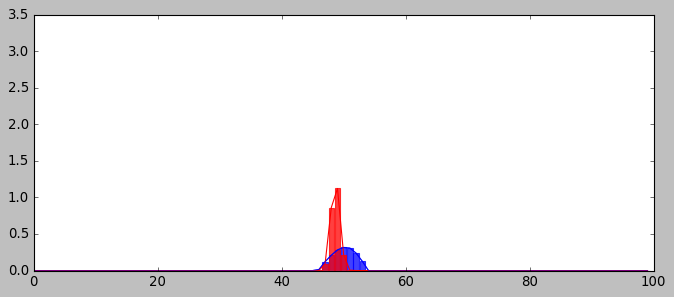

 interval =  7    ymax =  3.5


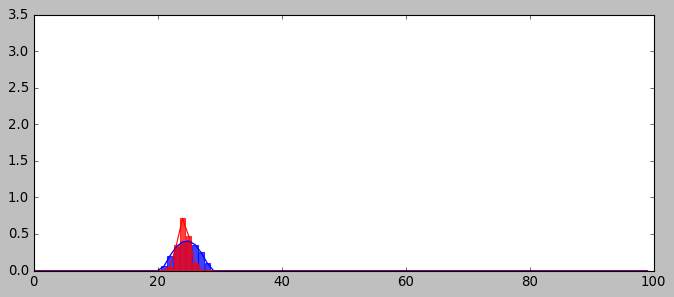

 interval =  16    ymax =  3.5


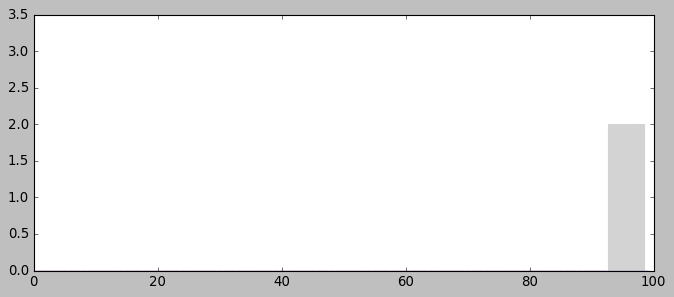

event number =  0     event_ave_chisq =  nan


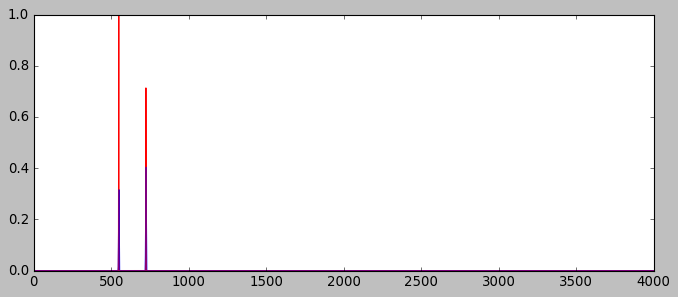

jj =  1
inputs.shape =  (8000, 9, 250)
 interval =  46    ymax =  3.5


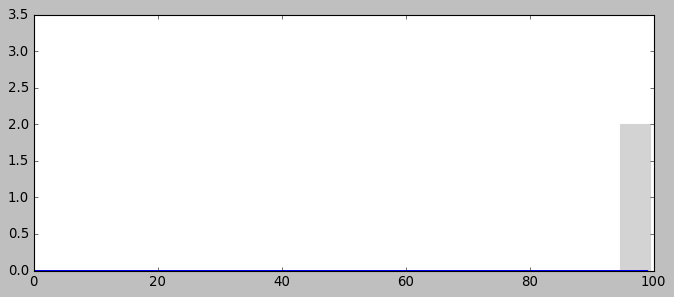

 interval =  47    ymax =  3.5


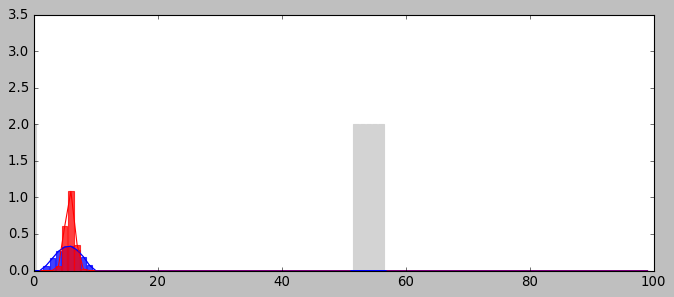

 interval =  49    ymax =  3.5


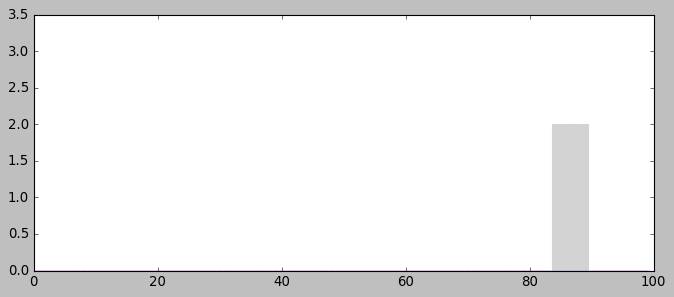

 interval =  53    ymax =  3.5


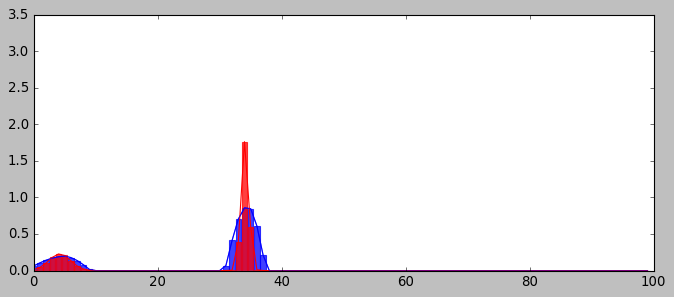

 interval =  55    ymax =  4.90546875


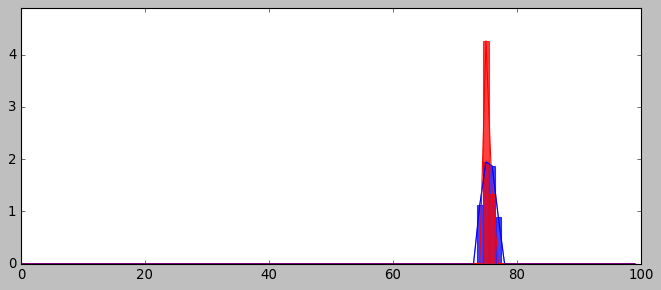

 interval =  57    ymax =  3.5


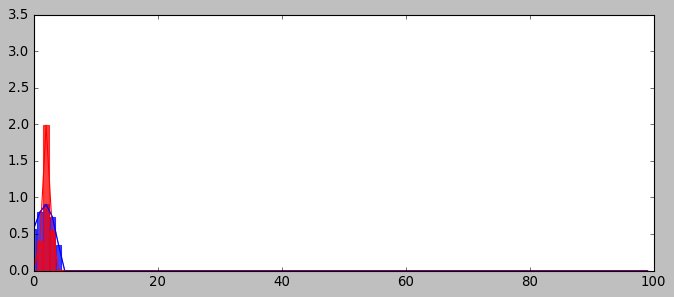

event number =  1     event_ave_chisq =  nan


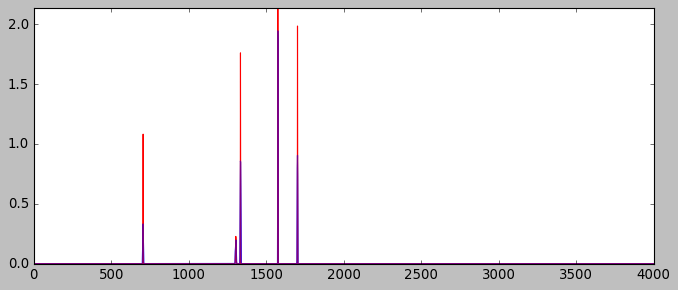

jj =  2
inputs.shape =  (8000, 9, 250)
 interval =  86    ymax =  3.5


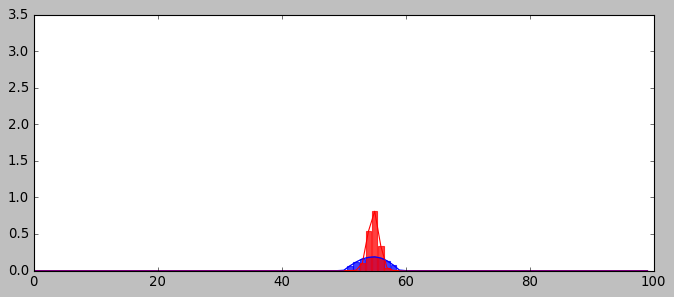

 interval =  89    ymax =  3.5


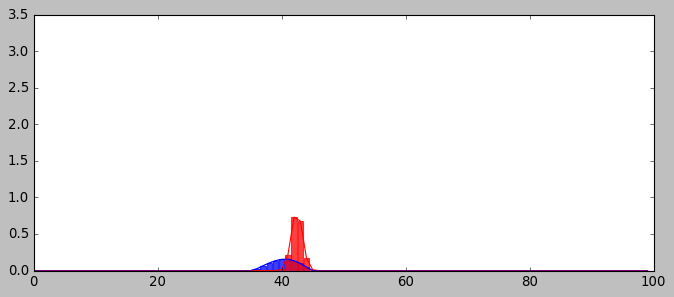

 interval =  90    ymax =  3.5


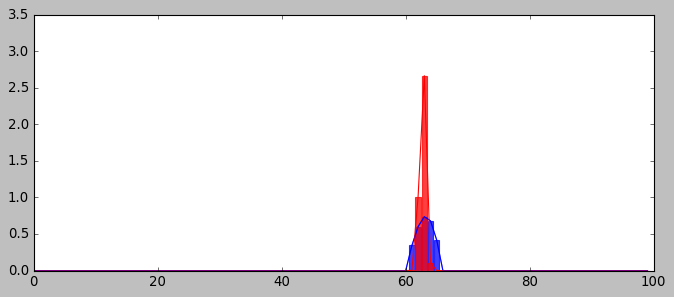

 interval =  93    ymax =  3.64765625


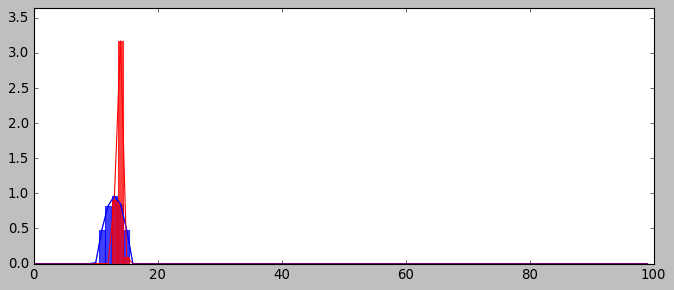

 interval =  94    ymax =  3.5


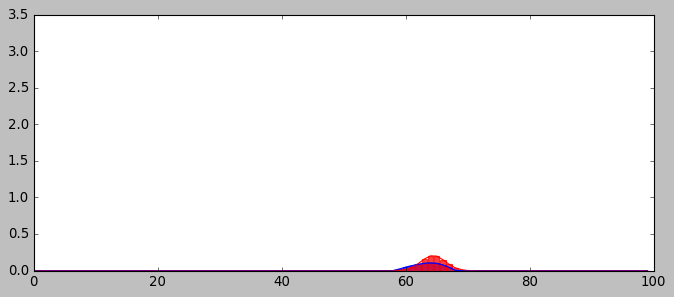

 interval =  96    ymax =  3.5


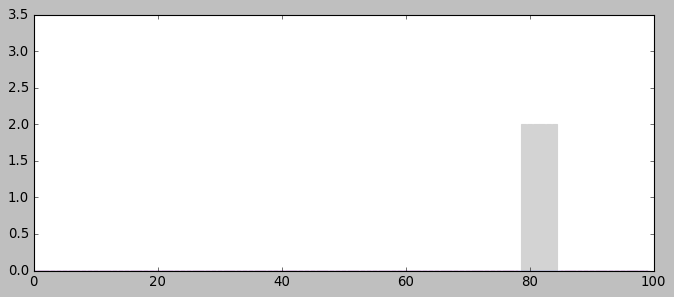

 interval =  103    ymax =  3.9149414062499996


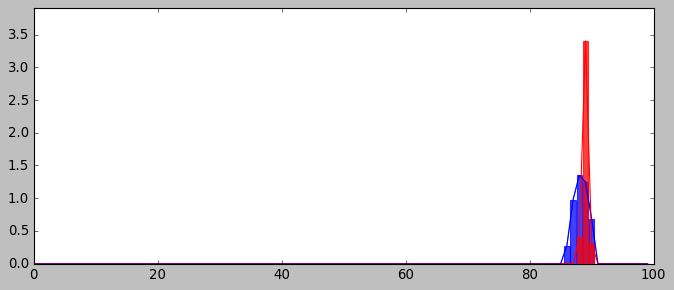

event number =  2     event_ave_chisq =  nan


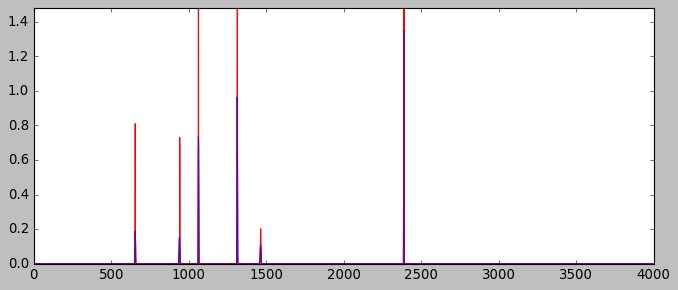

jj =  3
inputs.shape =  (8000, 9, 250)
 interval =  123    ymax =  5.4400390624999995


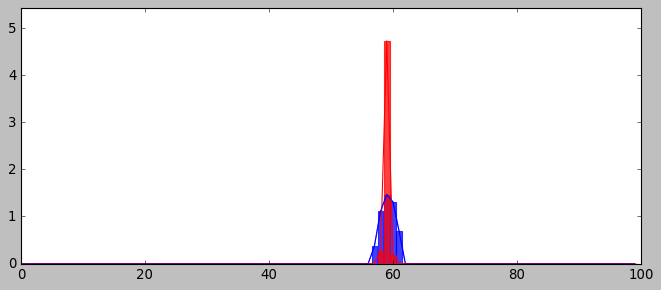

 interval =  124    ymax =  3.5


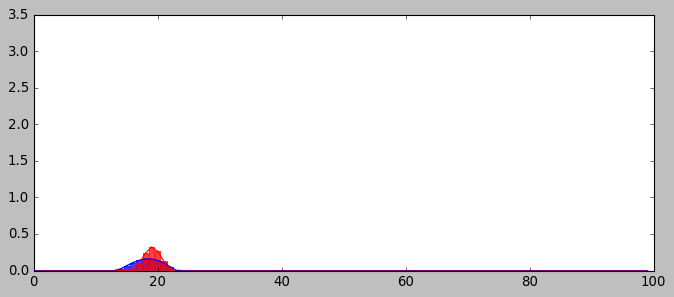

 interval =  125    ymax =  3.5


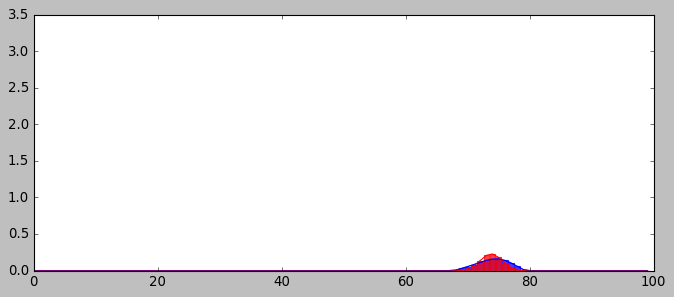

 interval =  127    ymax =  3.5


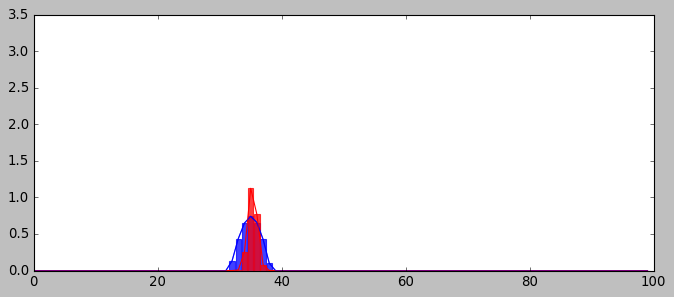

 interval =  128    ymax =  3.5


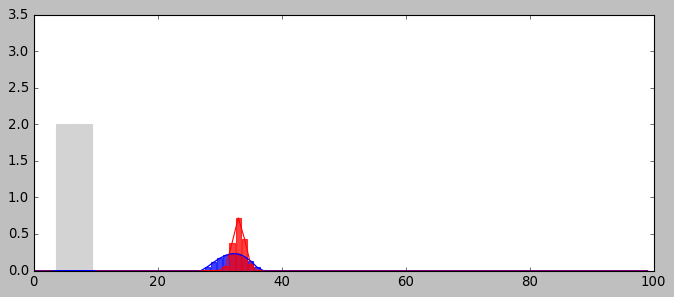

 interval =  133    ymax =  3.5


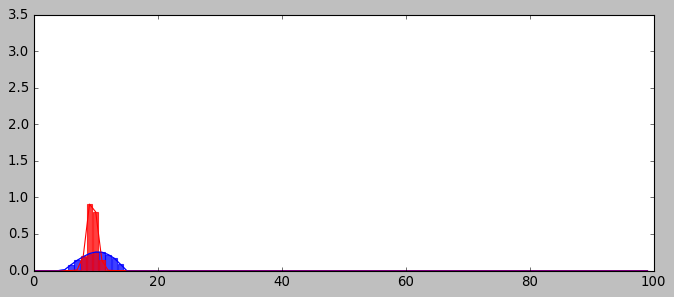

 interval =  143    ymax =  3.5


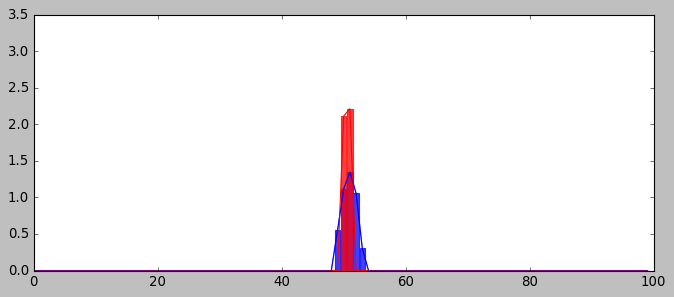

event number =  3     event_ave_chisq =  nan


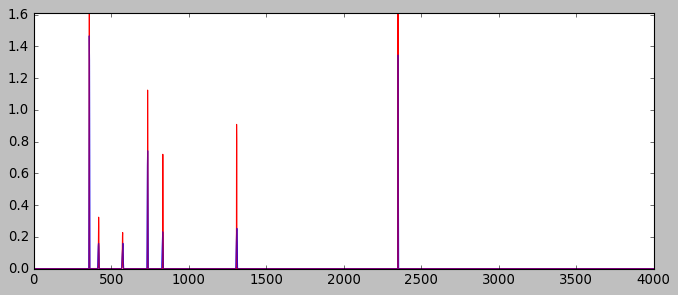

jj =  4
inputs.shape =  (8000, 9, 250)
 interval =  164    ymax =  3.5


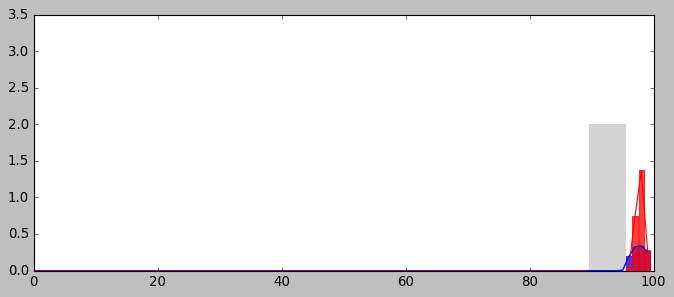

 interval =  165    ymax =  3.5


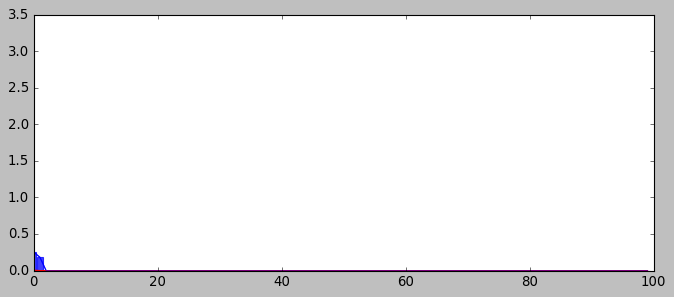

 interval =  166    ymax =  3.5


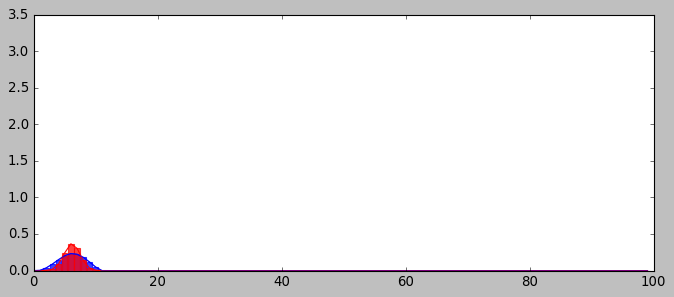

 interval =  170    ymax =  3.8453125


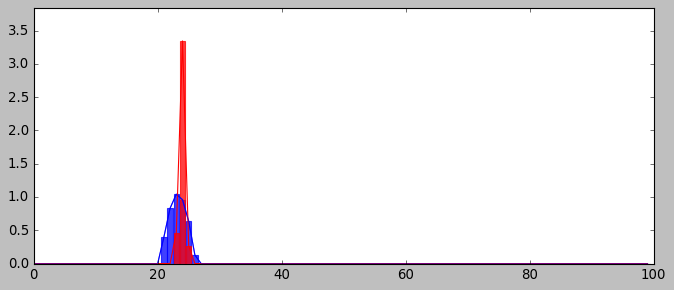

 interval =  172    ymax =  3.5


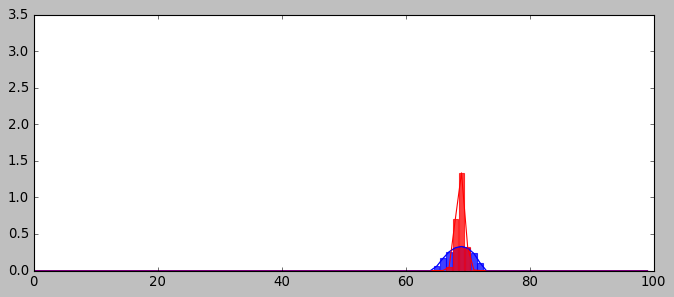

 interval =  177    ymax =  3.5


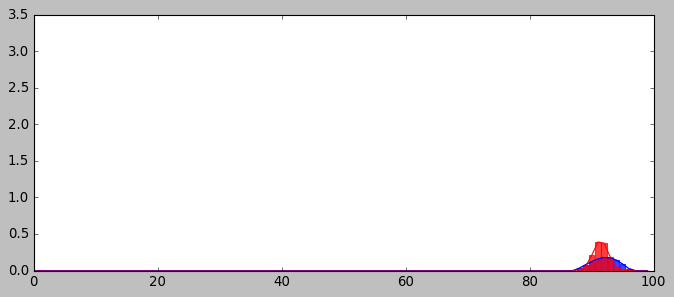

 interval =  180    ymax =  4.9234374999999995


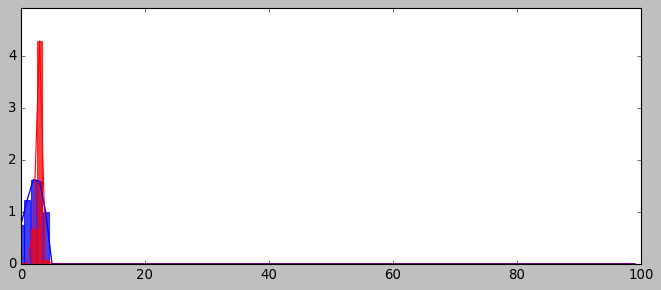

 interval =  184    ymax =  3.5


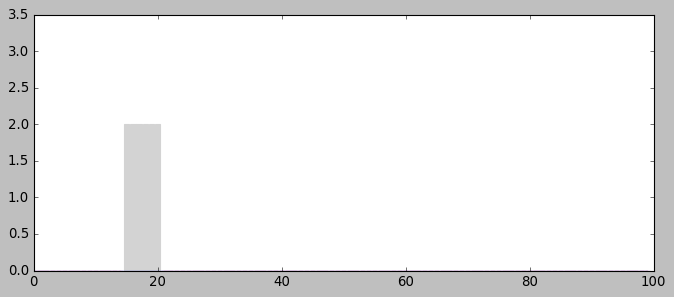

event number =  4     event_ave_chisq =  nan


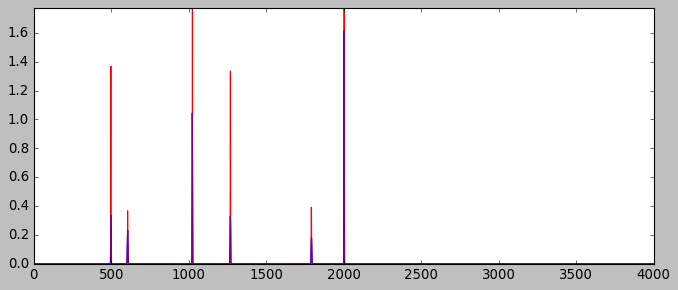

jj =  5
inputs.shape =  (8000, 9, 250)
 interval =  200    ymax =  3.5


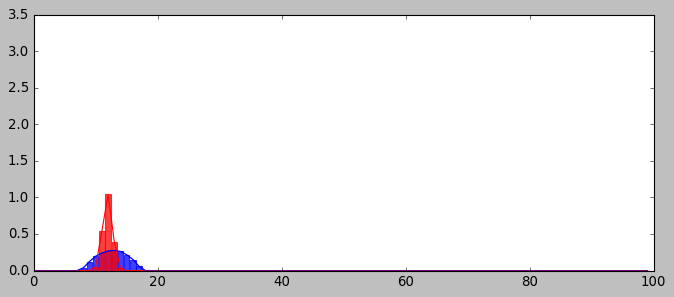

 interval =  207    ymax =  3.5


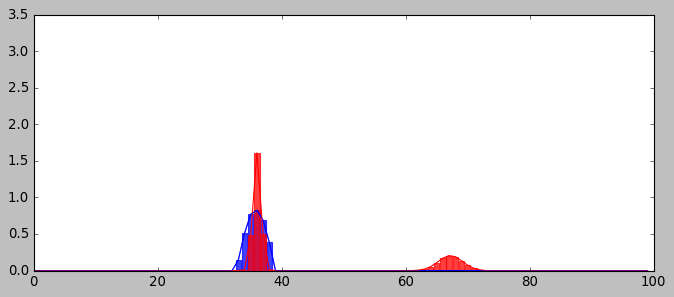

 interval =  208    ymax =  3.5


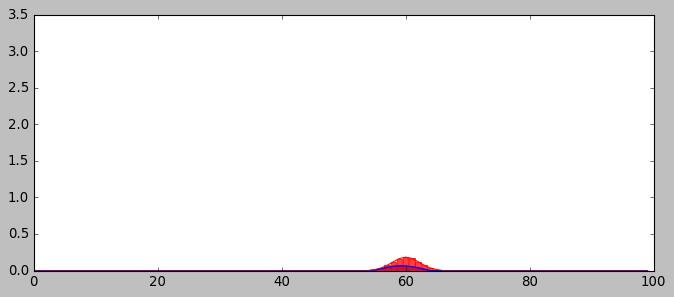

 interval =  210    ymax =  3.5


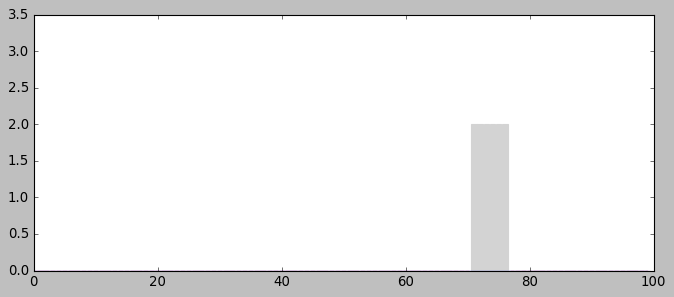

 interval =  218    ymax =  3.5


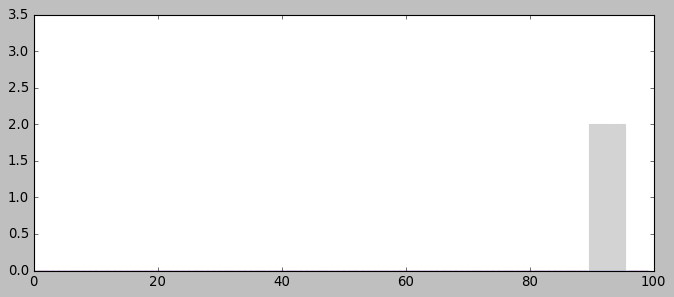

event number =  5     event_ave_chisq =  nan


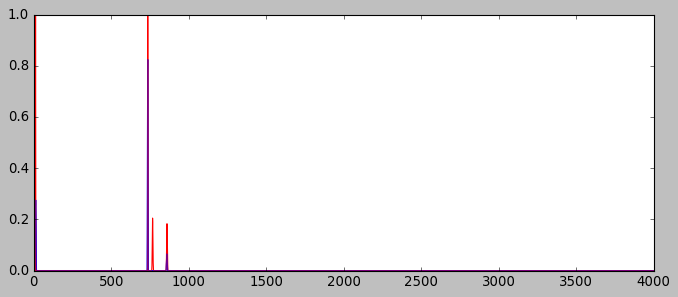

jj =  6
inputs.shape =  (8000, 9, 250)
 interval =  240    ymax =  3.5


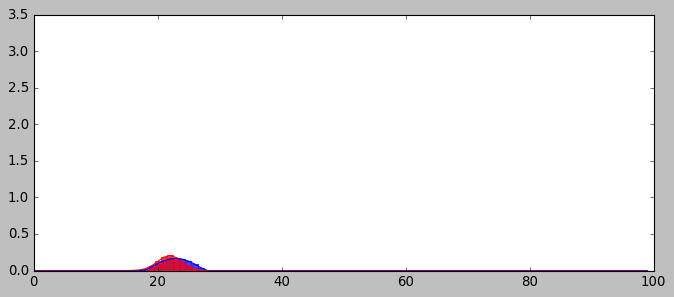

 interval =  242    ymax =  3.5


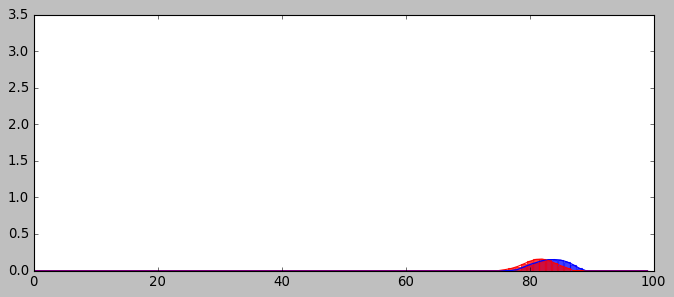

 interval =  244    ymax =  3.5


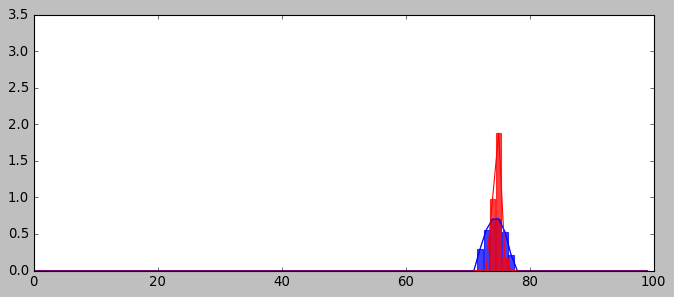

 interval =  245    ymax =  3.5


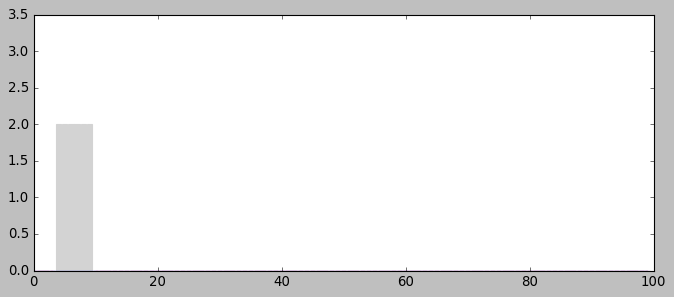

 interval =  249    ymax =  3.5


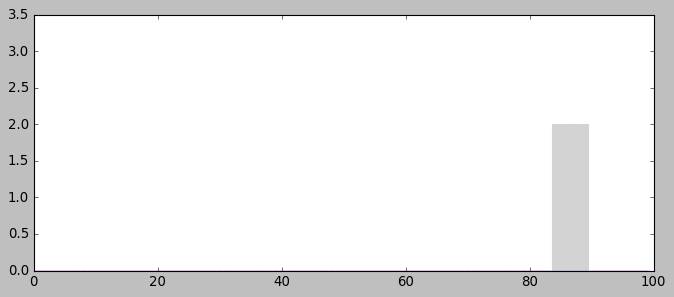

 interval =  251    ymax =  3.5


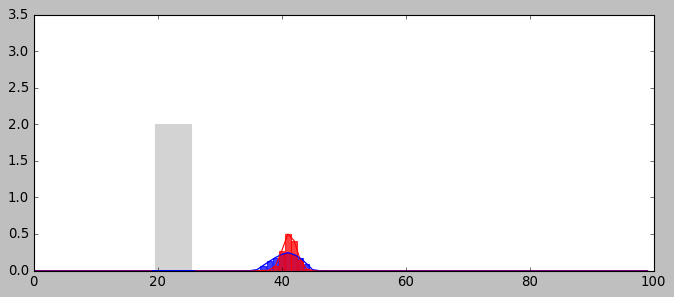

 interval =  252    ymax =  3.5


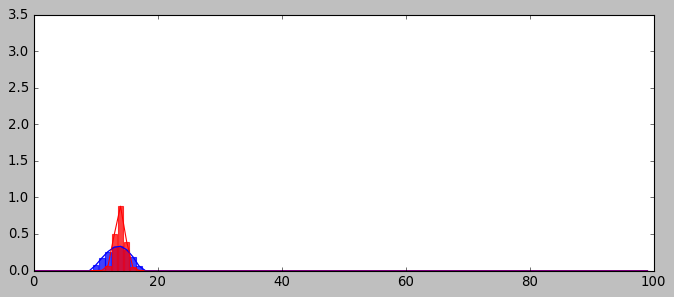

 interval =  256    ymax =  3.5


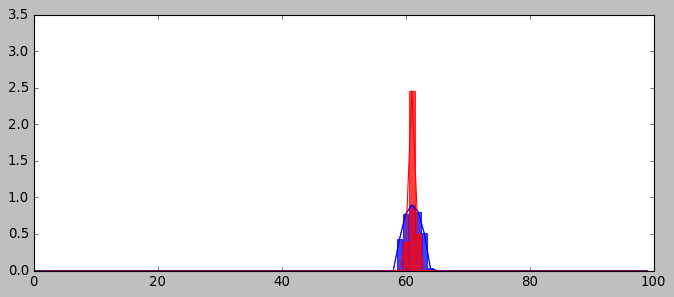

 interval =  258    ymax =  3.5


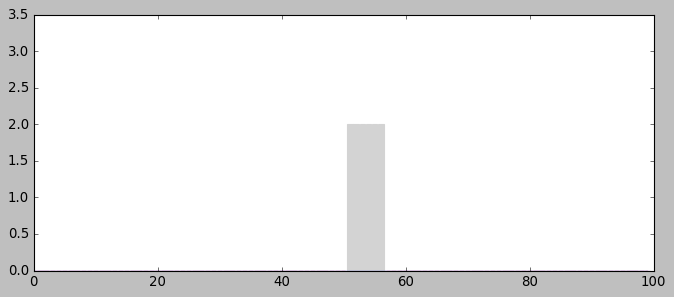

event number =  6     event_ave_chisq =  nan


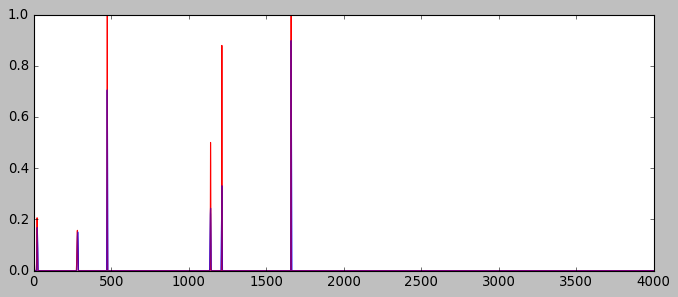

jj =  7
inputs.shape =  (8000, 9, 250)
 interval =  282    ymax =  3.5


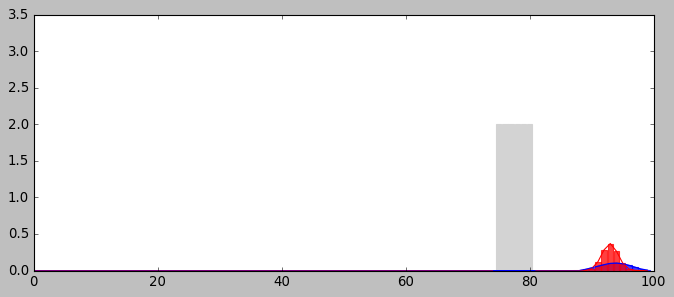

 interval =  284    ymax =  3.5


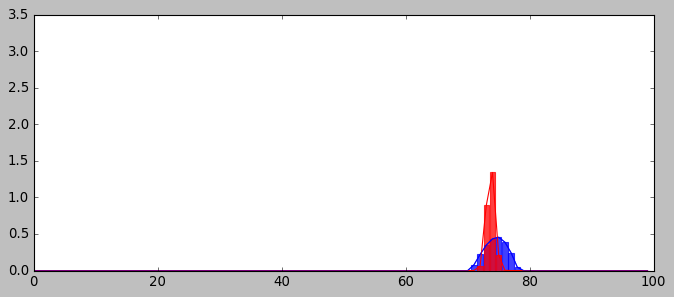

 interval =  287    ymax =  3.5


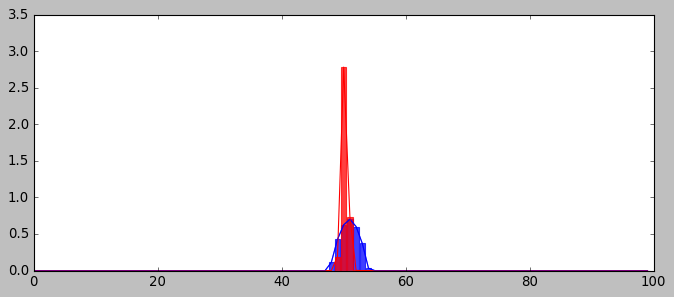

 interval =  291    ymax =  3.5


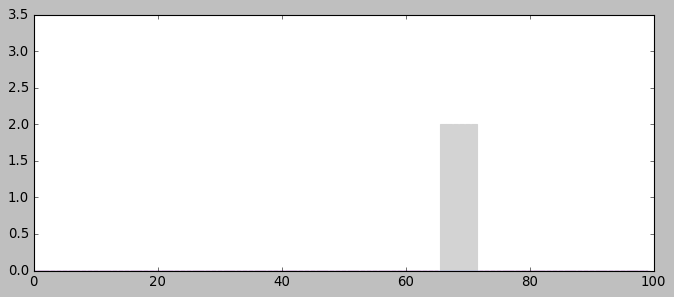

 interval =  292    ymax =  3.5


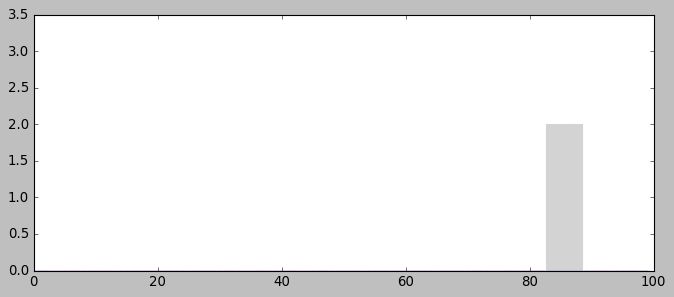

 interval =  293    ymax =  3.5


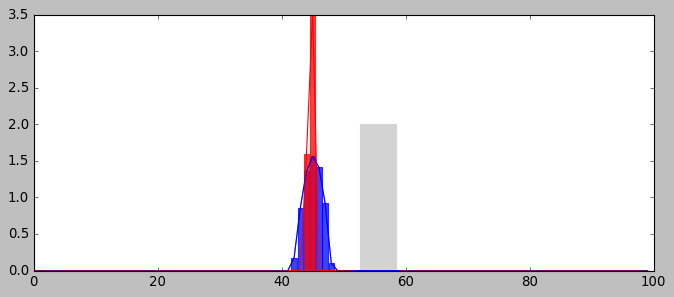

 interval =  294    ymax =  3.5


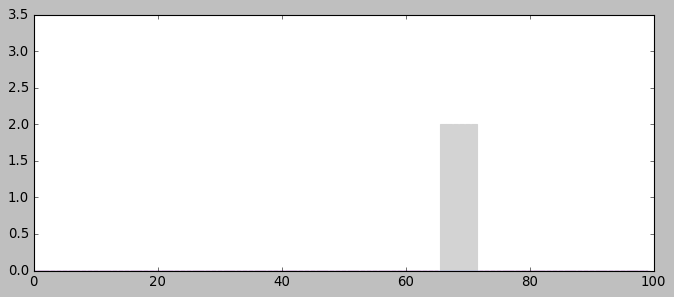

 interval =  295    ymax =  3.5


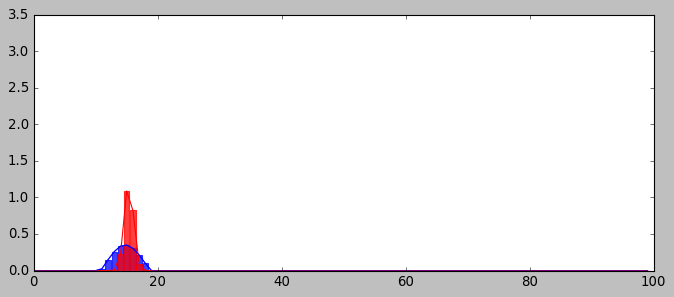

 interval =  296    ymax =  4.1283203125


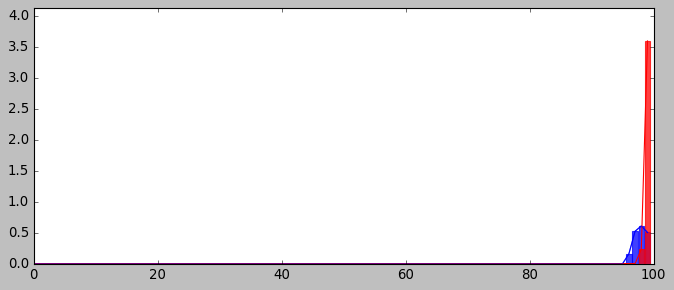

 interval =  297    ymax =  3.5


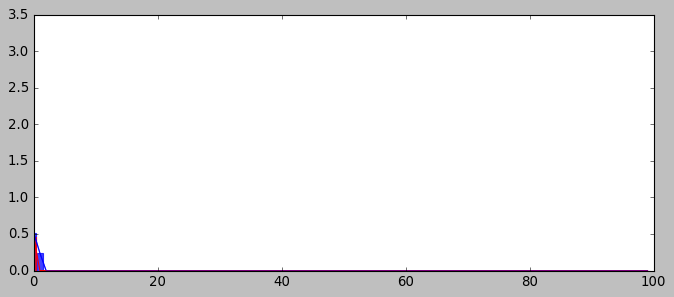

 interval =  298    ymax =  3.5


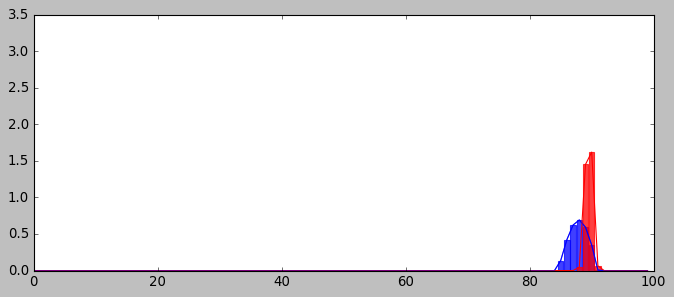

 interval =  302    ymax =  3.5


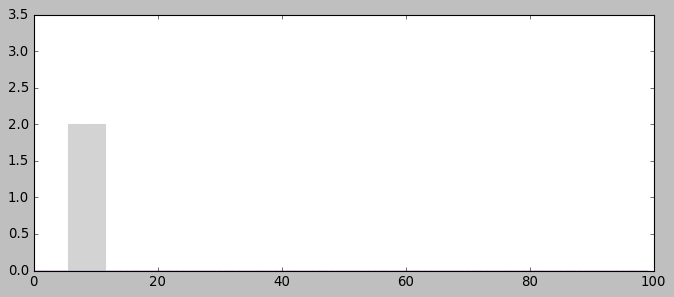

event number =  7     event_ave_chisq =  nan


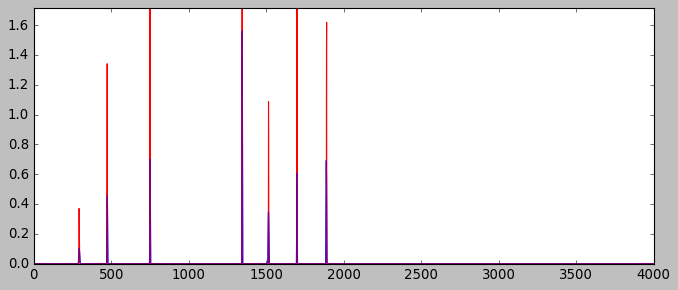

jj =  8
inputs.shape =  (8000, 9, 250)
 interval =  325    ymax =  3.5


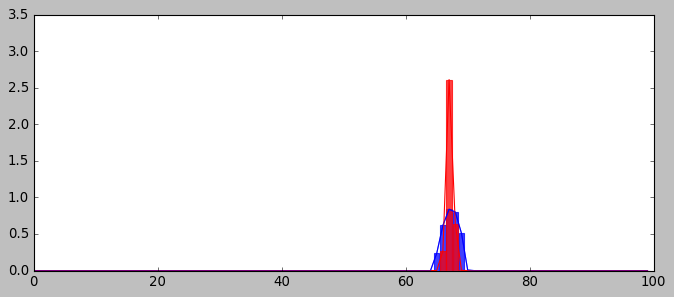

 interval =  331    ymax =  3.5


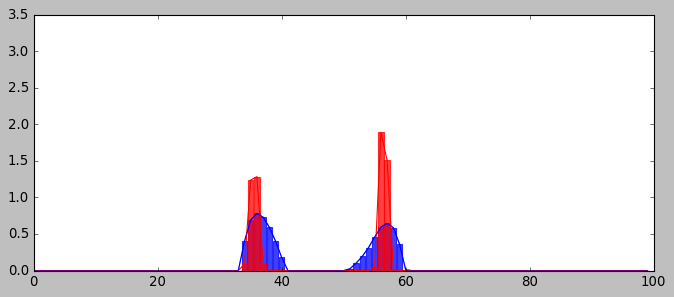

 interval =  335    ymax =  3.5


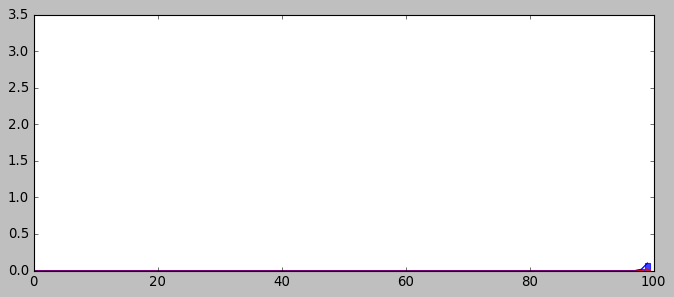

 interval =  336    ymax =  3.5


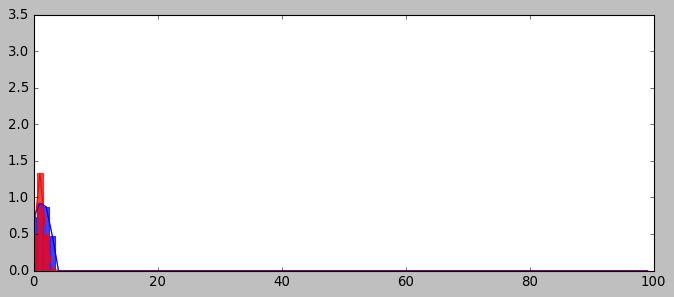

event number =  8     event_ave_chisq =  22.449797428131102


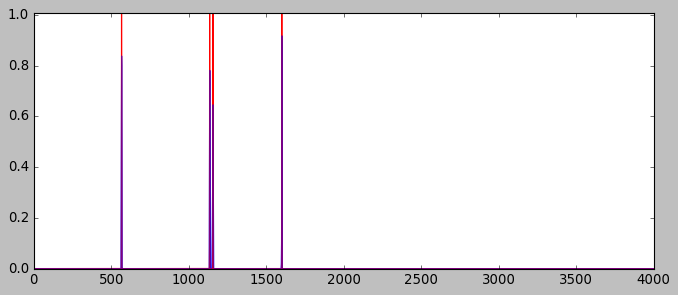

jj =  9
inputs.shape =  (8000, 9, 250)
 interval =  366    ymax =  3.5


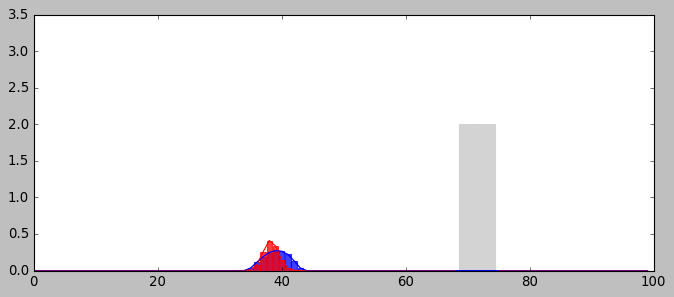

 interval =  368    ymax =  3.5


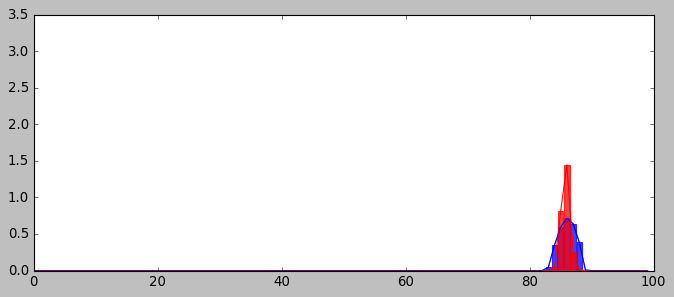

 interval =  370    ymax =  3.5


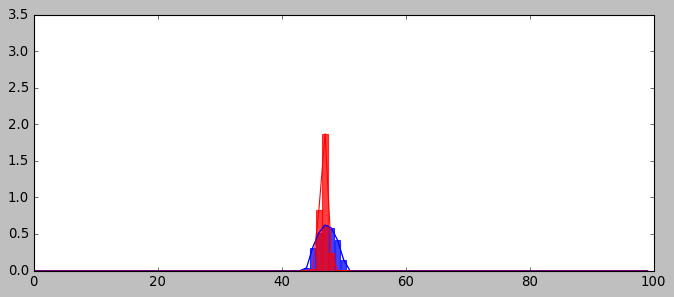

 interval =  372    ymax =  3.5


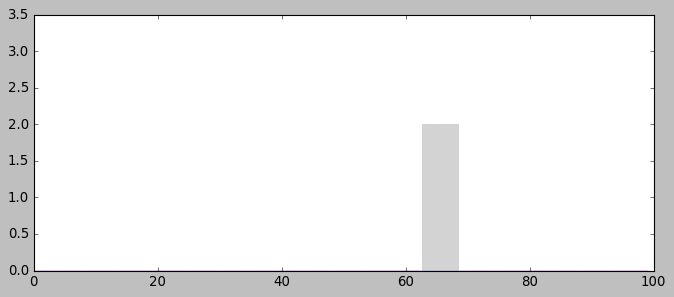

 interval =  373    ymax =  3.602734375


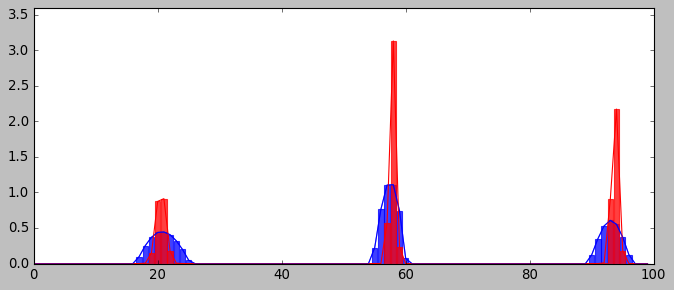

 interval =  378    ymax =  3.5


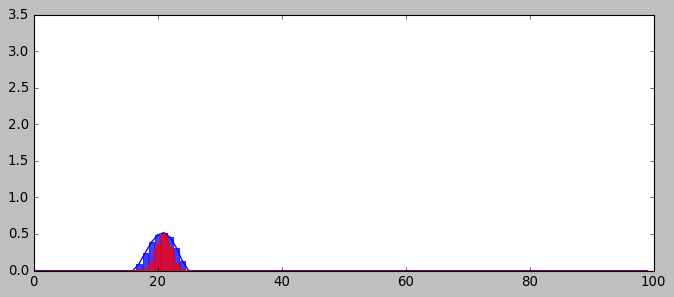

 interval =  379    ymax =  3.5


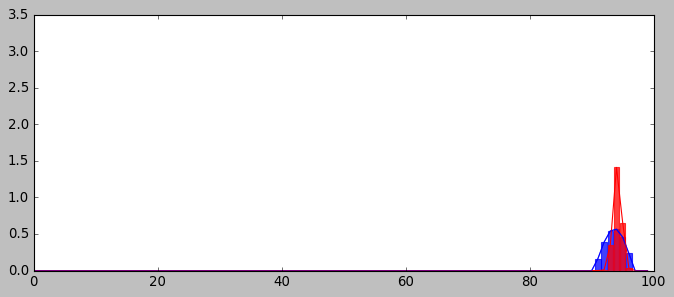

event number =  9     event_ave_chisq =  nan


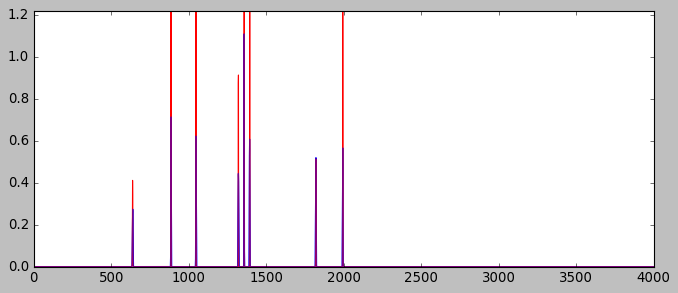

jj =  10
inputs.shape =  (8000, 9, 250)
 interval =  402    ymax =  4.33271484375


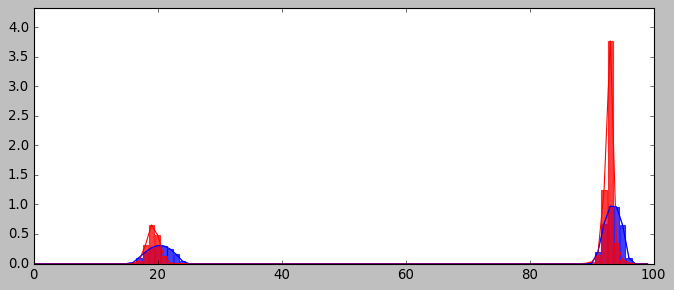

 interval =  409    ymax =  3.5


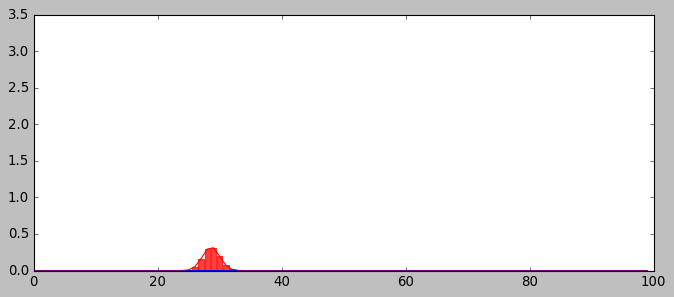

 interval =  411    ymax =  3.5


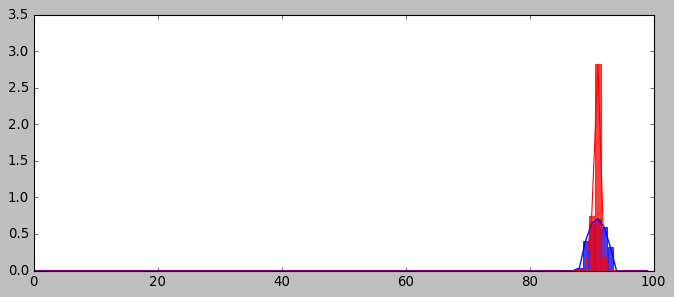

 interval =  416    ymax =  3.5


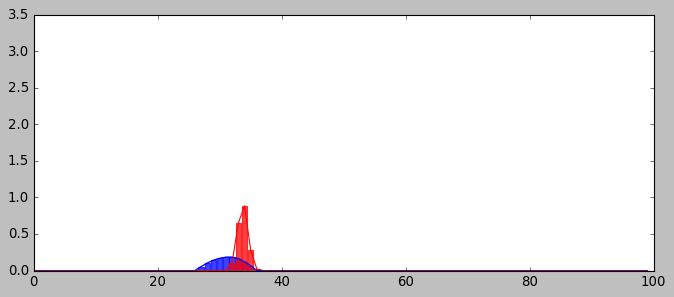

event number =  10     event_ave_chisq =  38.256054565429686


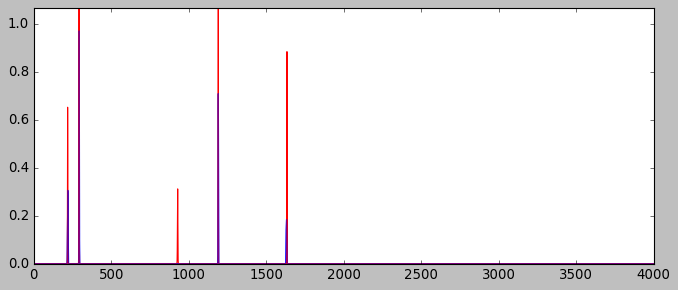

jj =  11
inputs.shape =  (8000, 9, 250)
 interval =  443    ymax =  3.5


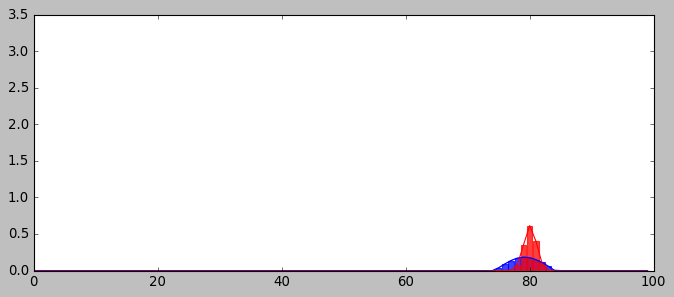

 interval =  446    ymax =  3.5


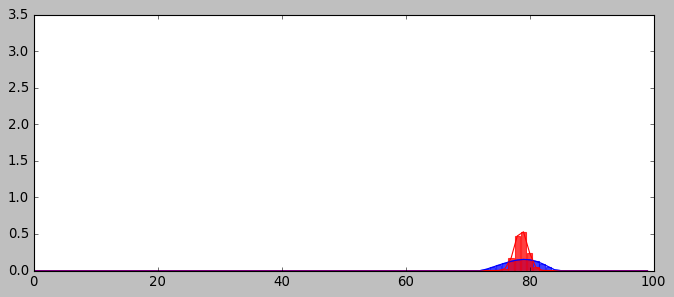

 interval =  447    ymax =  3.5


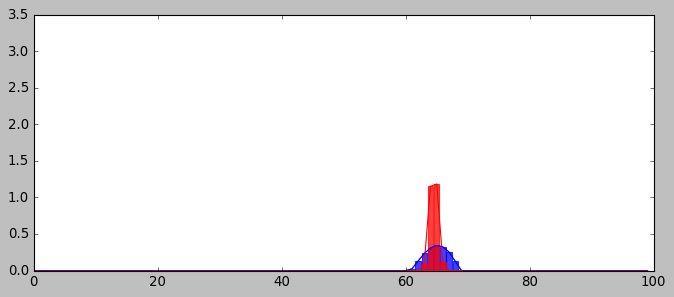

 interval =  449    ymax =  3.5


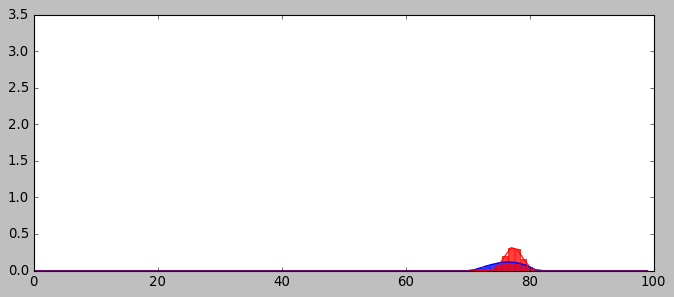

 interval =  451    ymax =  3.5


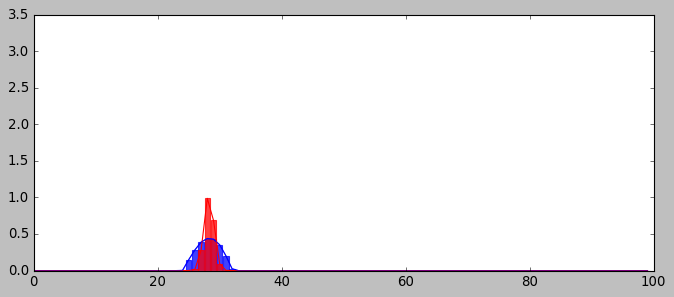

 interval =  452    ymax =  3.5


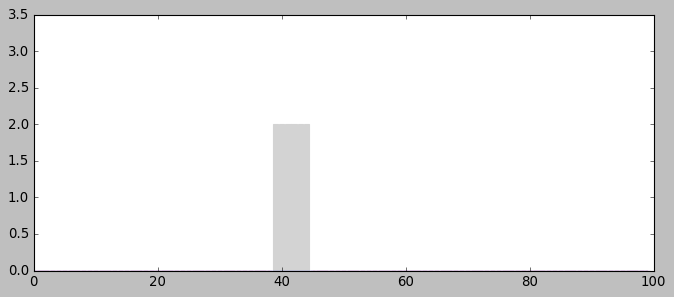

 interval =  459    ymax =  3.5


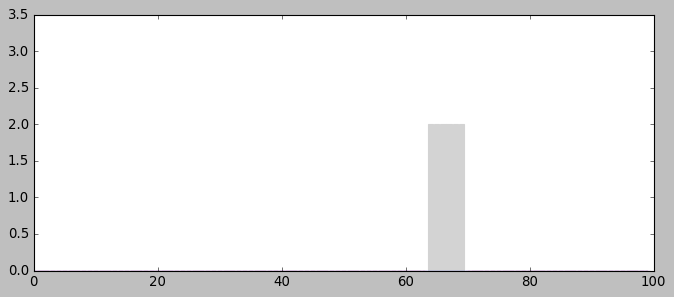

 interval =  462    ymax =  3.5


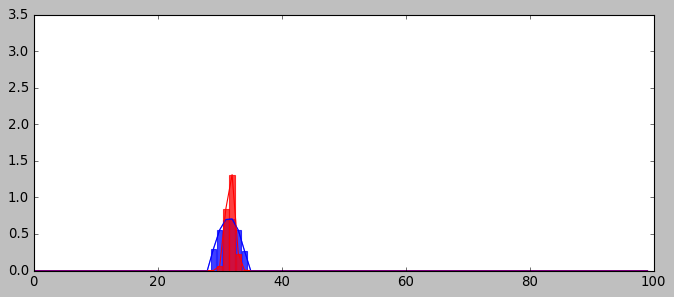

event number =  11     event_ave_chisq =  nan


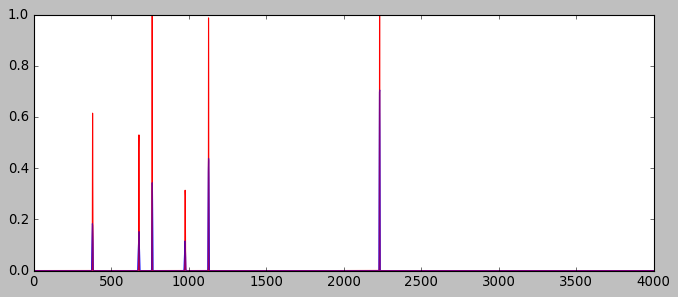

jj =  12
inputs.shape =  (8000, 9, 250)
 interval =  485    ymax =  3.5


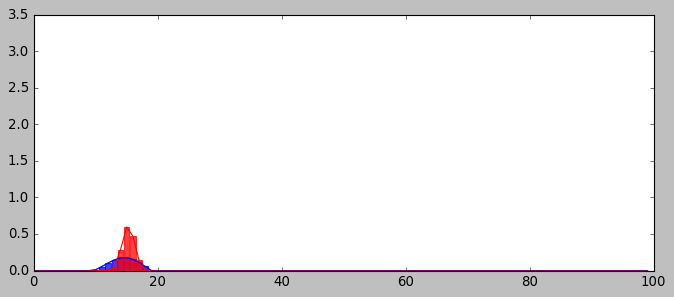

 interval =  490    ymax =  3.5


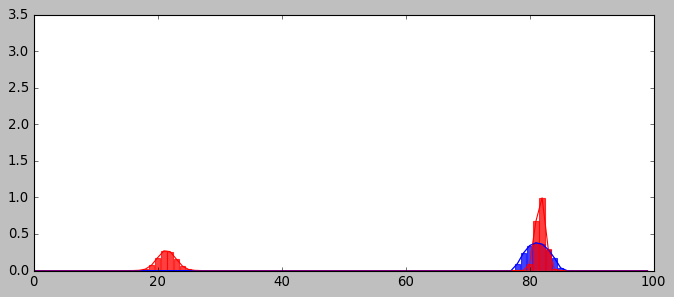

 interval =  491    ymax =  3.5


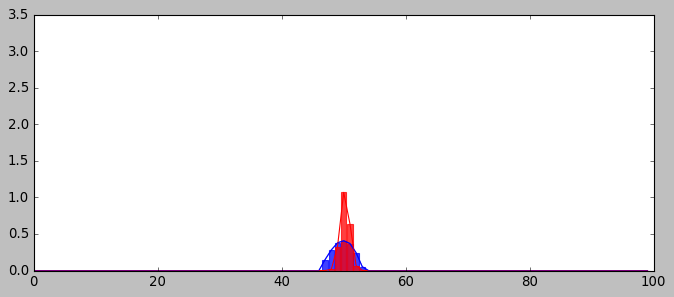

 interval =  492    ymax =  3.5


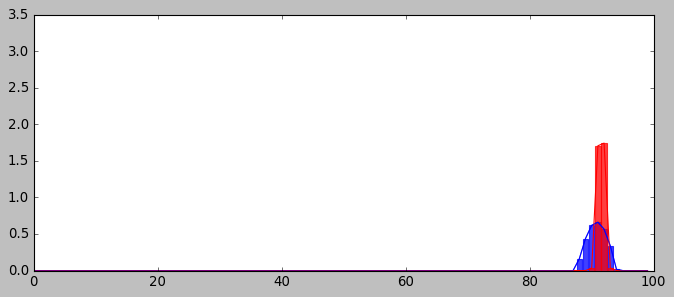

event number =  12     event_ave_chisq =  12.327253784179689


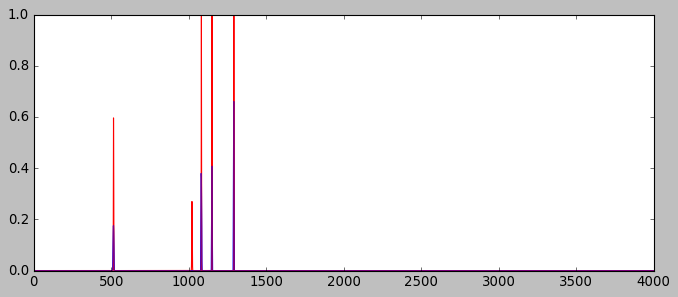

jj =  13
inputs.shape =  (8000, 9, 250)
 interval =  520    ymax =  3.5


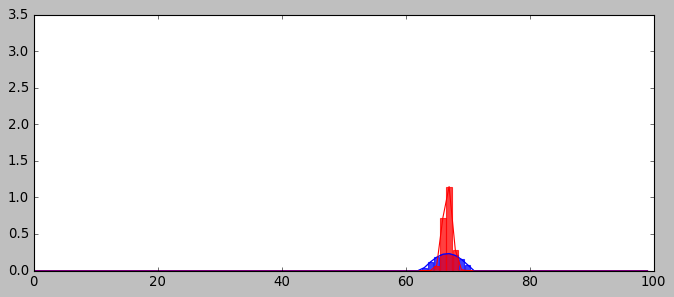

 interval =  523    ymax =  3.5


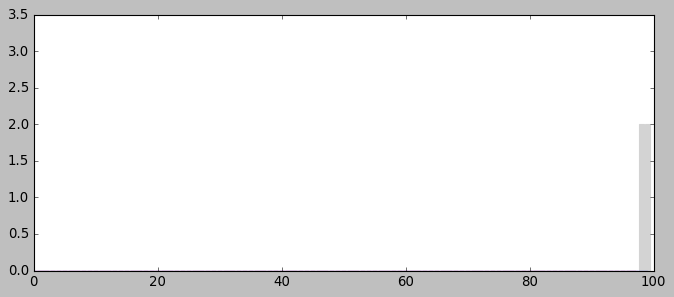

 interval =  524    ymax =  3.5


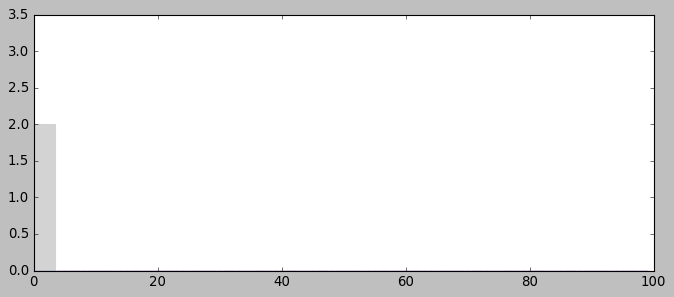

 interval =  526    ymax =  3.5


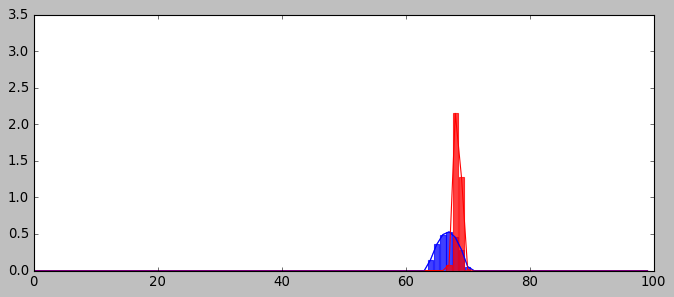

 interval =  527    ymax =  3.5


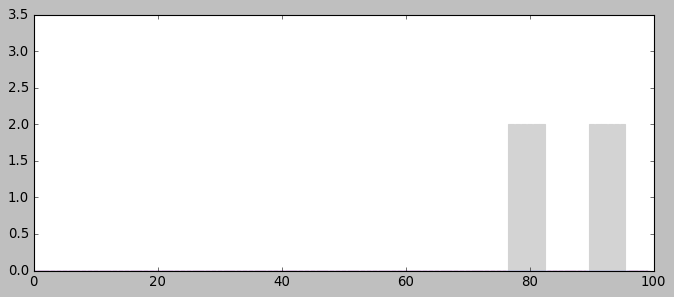

 interval =  528    ymax =  3.5


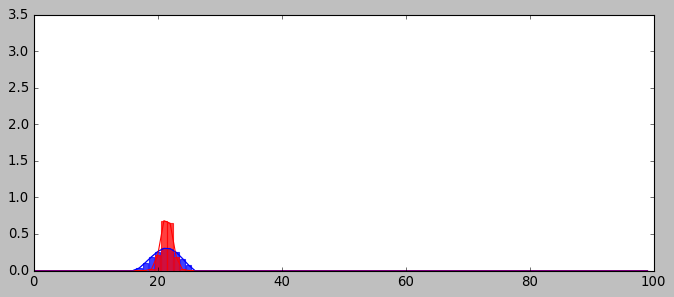

 interval =  532    ymax =  3.5


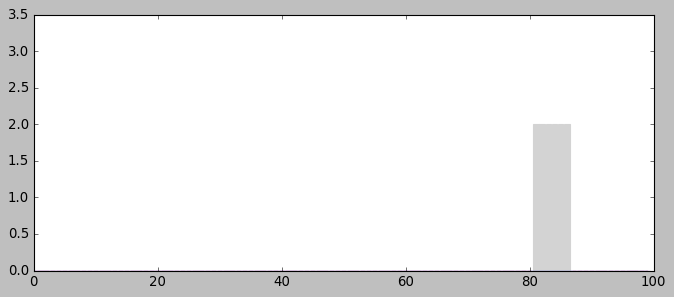

 interval =  535    ymax =  3.5


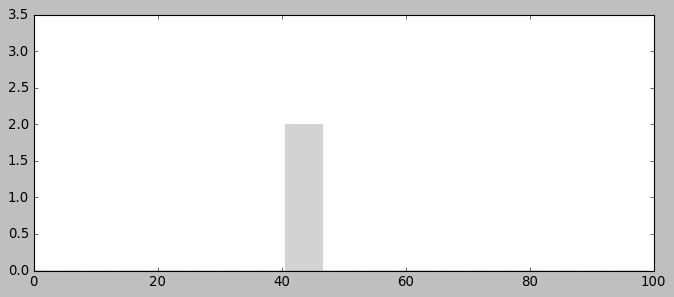

 interval =  536    ymax =  3.5


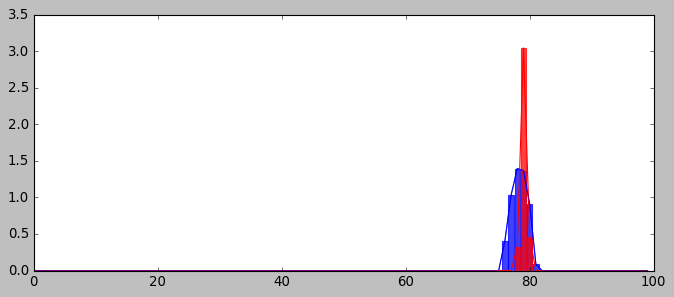

event number =  13     event_ave_chisq =  nan


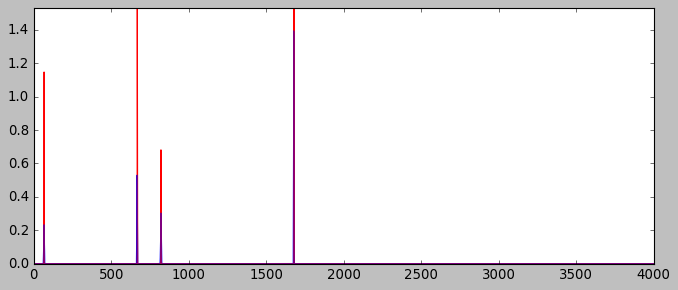

jj =  14
inputs.shape =  (8000, 9, 250)
 interval =  564    ymax =  3.5


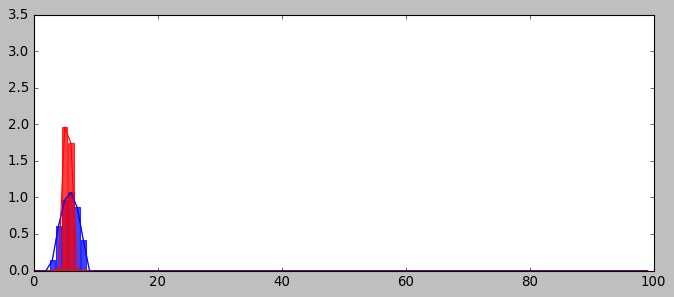

 interval =  567    ymax =  3.5


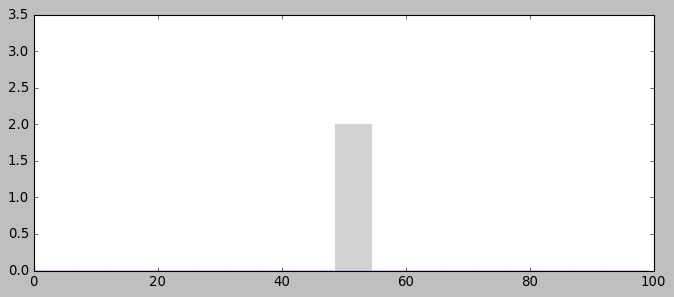

 interval =  568    ymax =  3.5


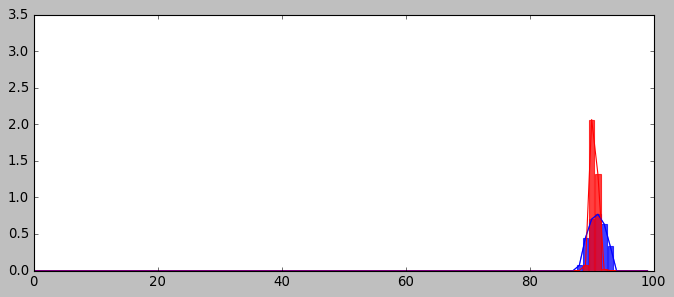

 interval =  569    ymax =  3.5


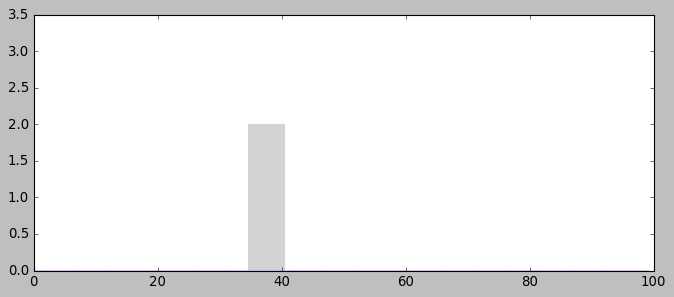

 interval =  573    ymax =  3.5


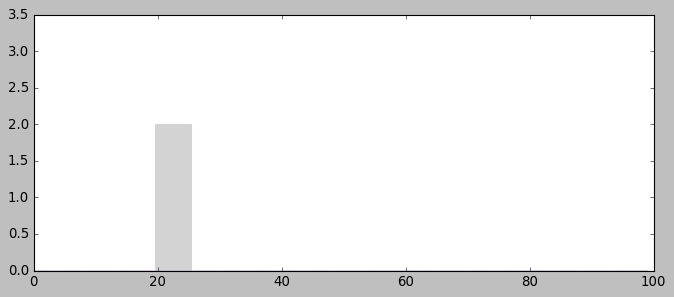

 interval =  574    ymax =  3.5


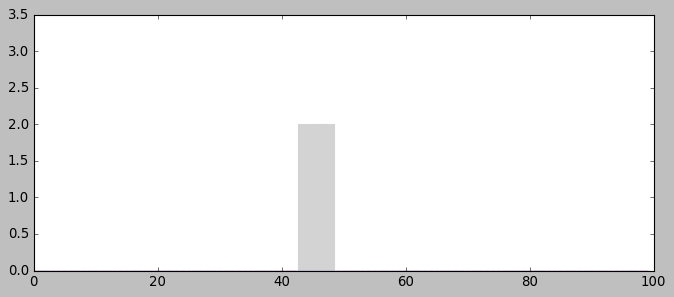

 interval =  586    ymax =  3.5


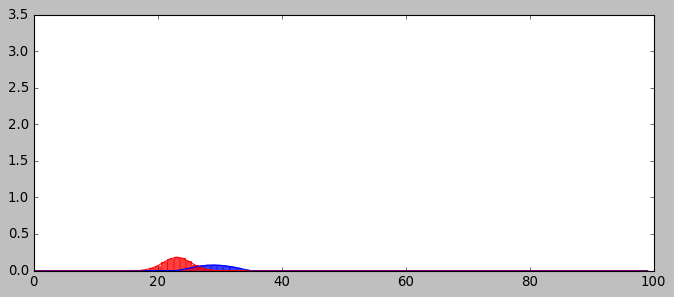

event number =  14     event_ave_chisq =  nan


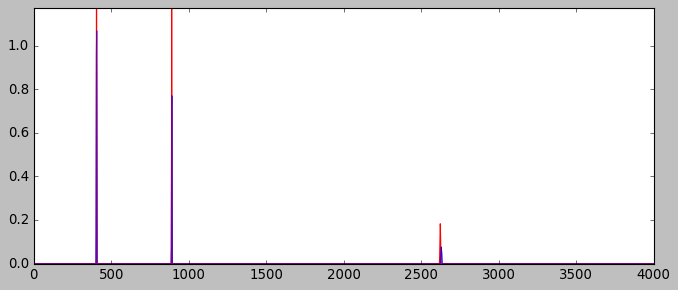

jj =  15
inputs.shape =  (8000, 9, 250)
 interval =  600    ymax =  3.5


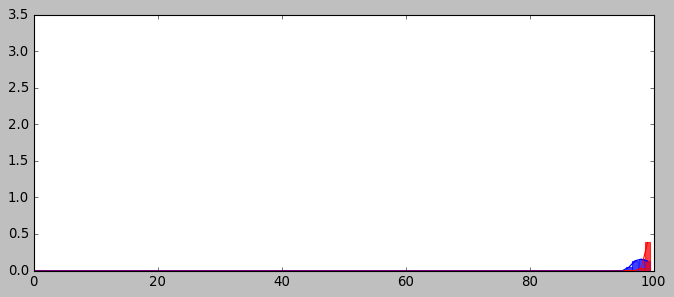

 interval =  601    ymax =  3.5


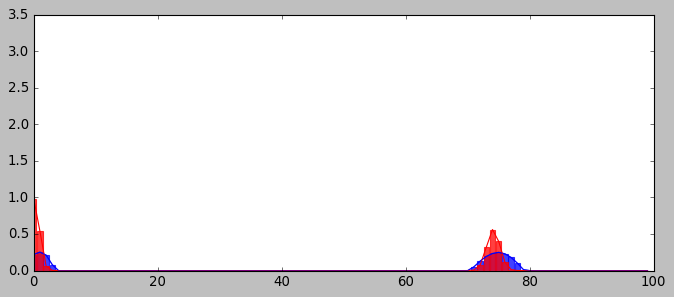

 interval =  603    ymax =  5.839843749999999


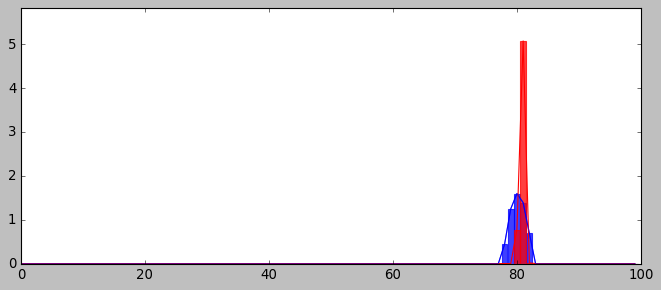

 interval =  604    ymax =  3.5


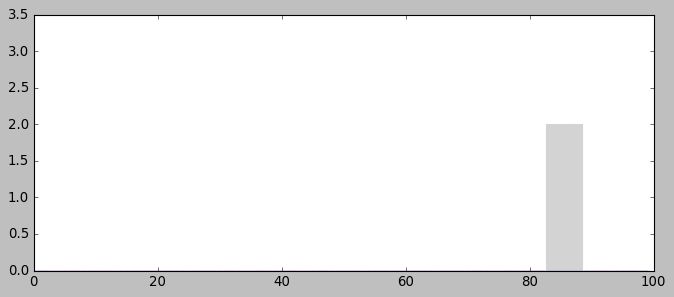

 interval =  609    ymax =  3.5


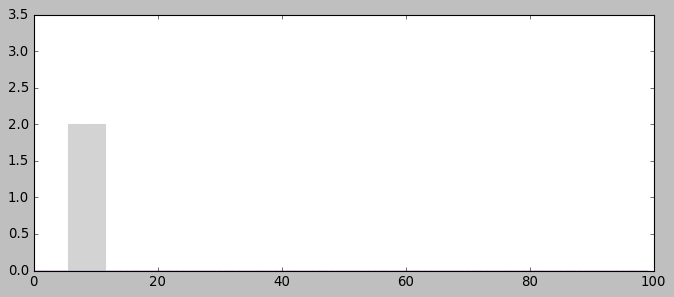

 interval =  615    ymax =  3.5


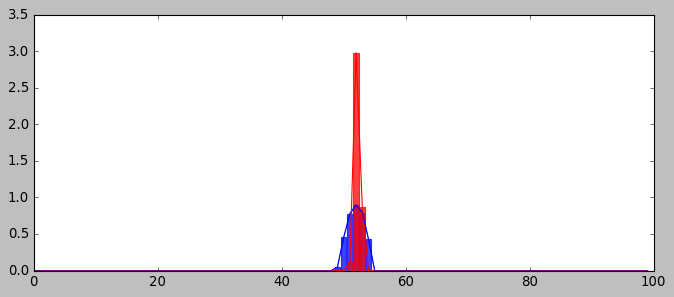

event number =  15     event_ave_chisq =  nan


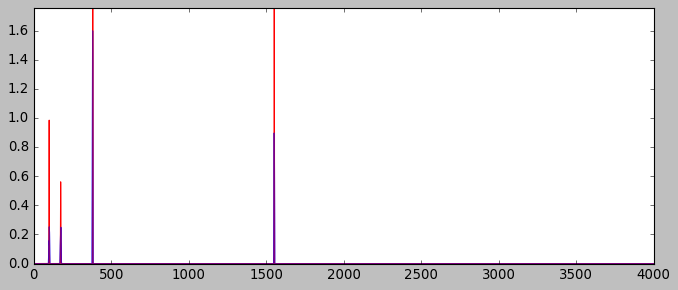

jj =  16
inputs.shape =  (8000, 9, 250)
 interval =  642    ymax =  3.5


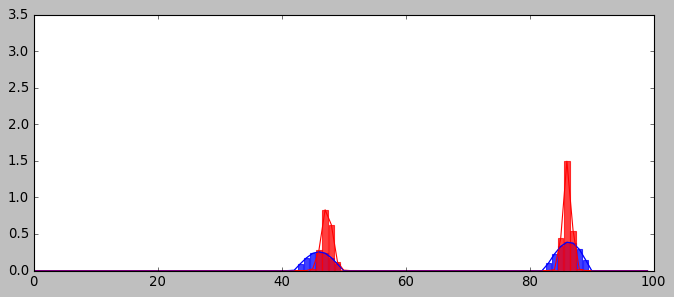

 interval =  647    ymax =  3.5


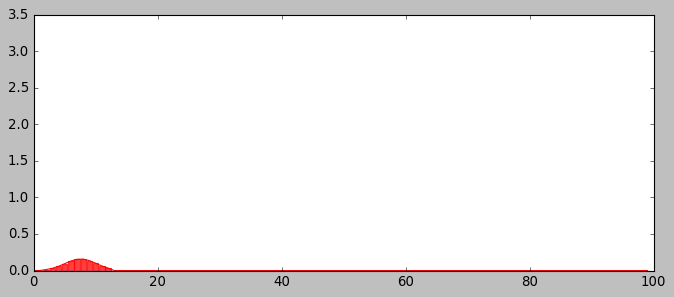

 interval =  649    ymax =  3.5


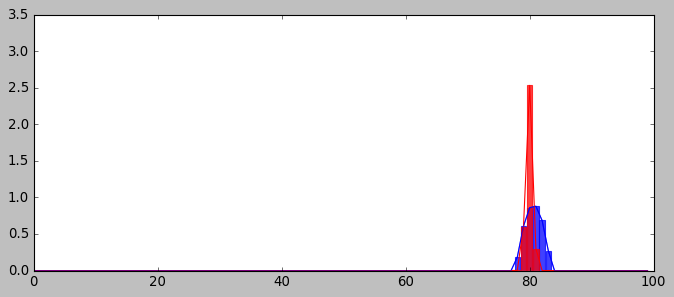

 interval =  650    ymax =  3.5


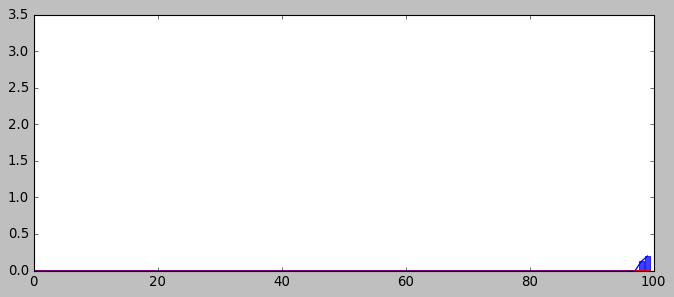

 interval =  651    ymax =  3.5


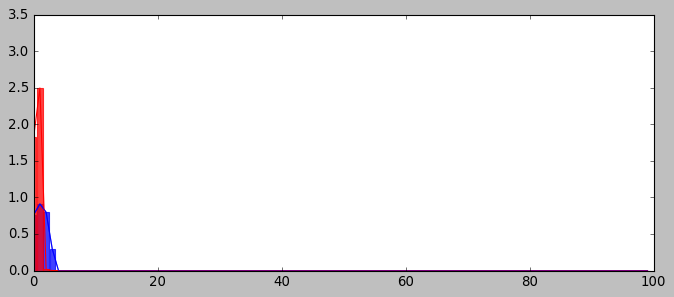

 interval =  652    ymax =  3.5


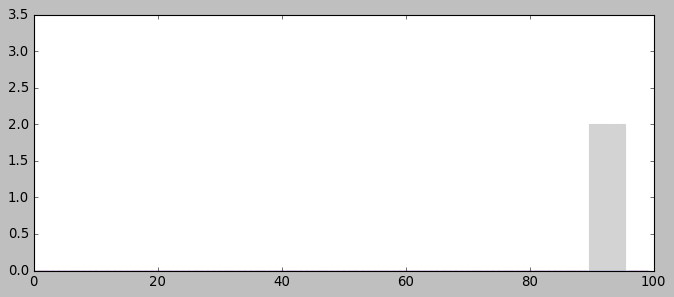

 interval =  654    ymax =  3.5


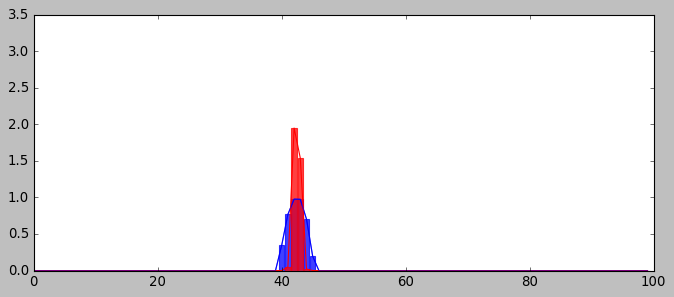

 interval =  655    ymax =  3.5


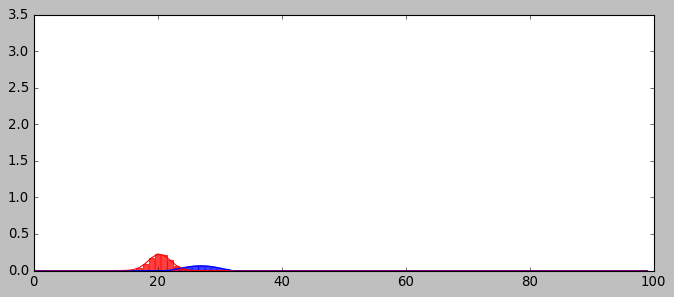

 interval =  657    ymax =  3.5


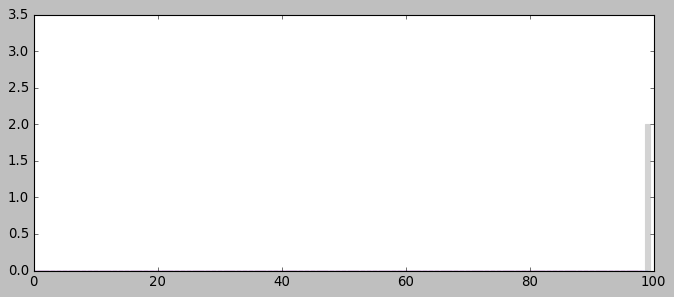

 interval =  658    ymax =  3.5


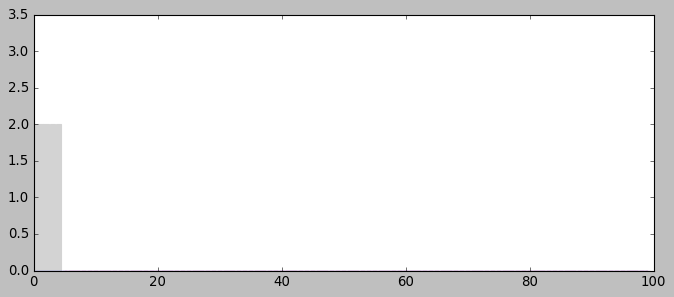

 interval =  659    ymax =  3.5


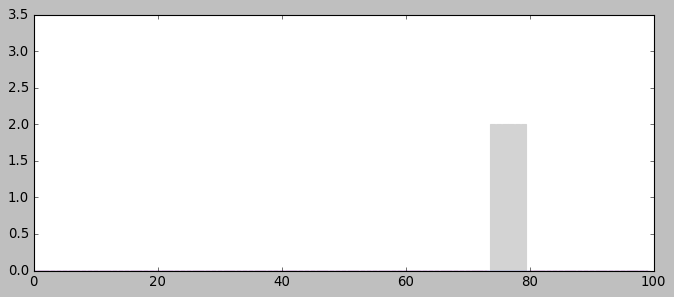

 interval =  663    ymax =  3.5


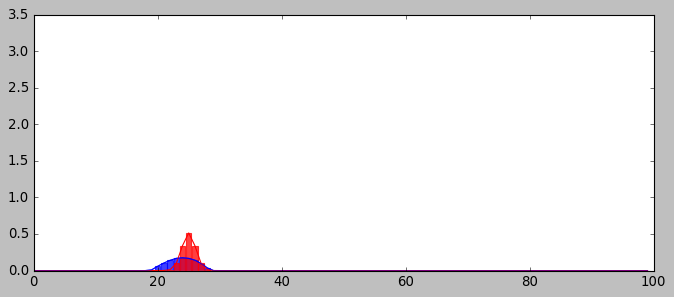

event number =  16     event_ave_chisq =  nan


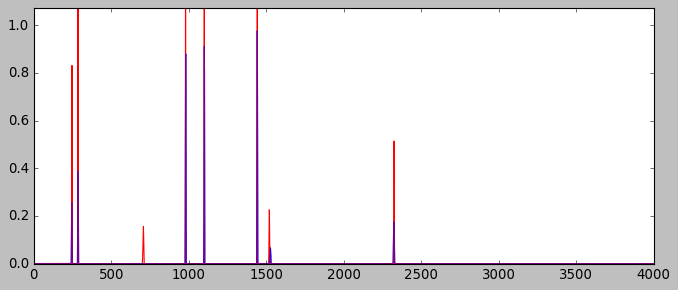

jj =  17
inputs.shape =  (8000, 9, 250)
 interval =  681    ymax =  3.5


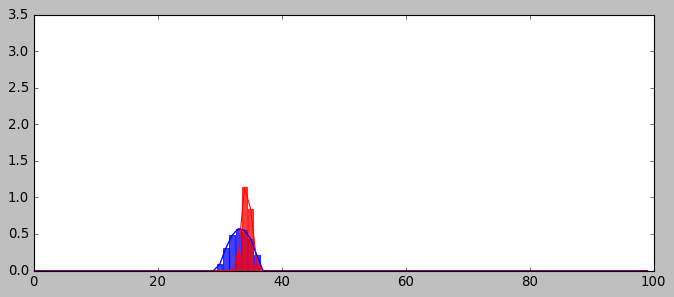

 interval =  683    ymax =  3.5


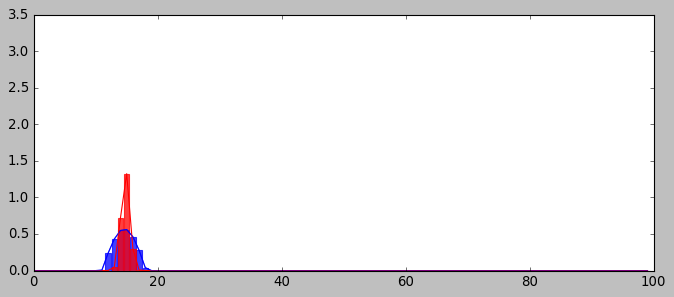

 interval =  686    ymax =  3.5


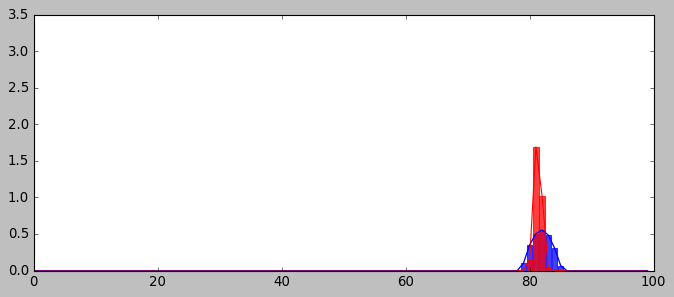

 interval =  688    ymax =  4.0474609374999995


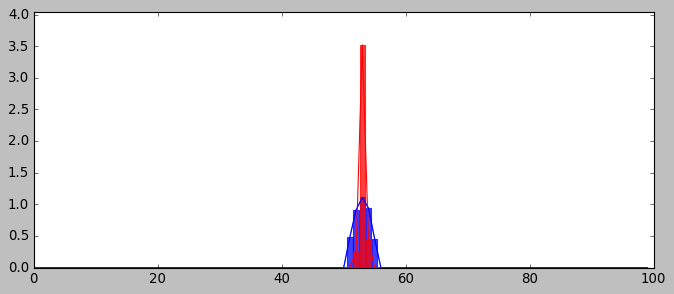

 interval =  690    ymax =  3.5


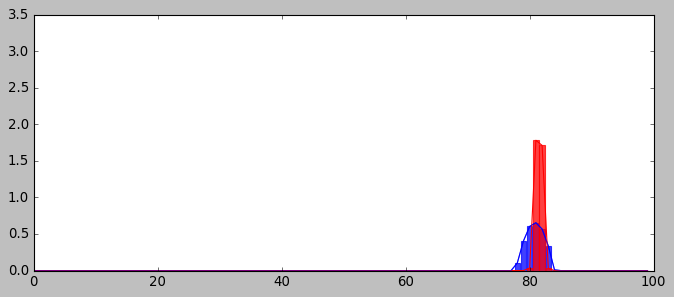

 interval =  692    ymax =  3.5


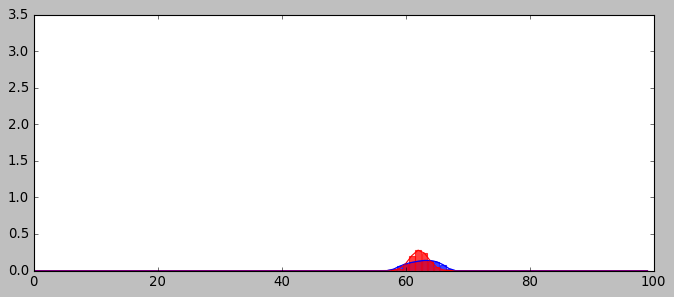

 interval =  693    ymax =  3.5


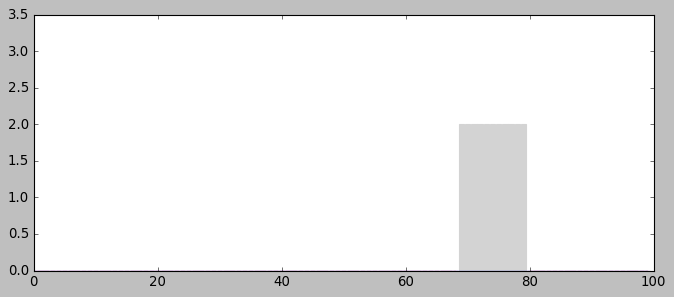

 interval =  696    ymax =  3.5


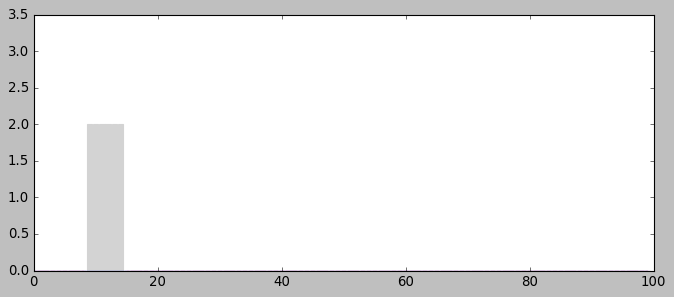

 interval =  697    ymax =  3.5


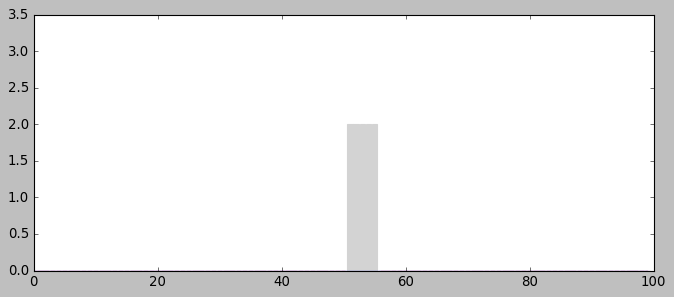

event number =  17     event_ave_chisq =  nan


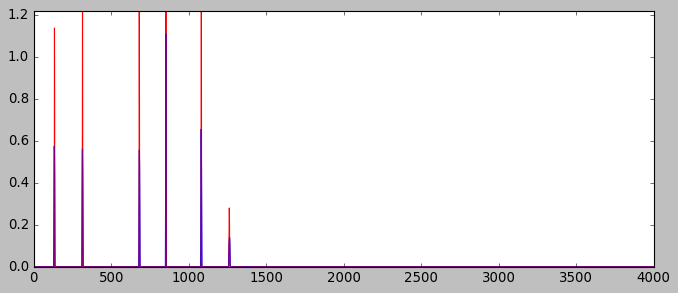

jj =  18
inputs.shape =  (8000, 9, 250)
 interval =  732    ymax =  3.5


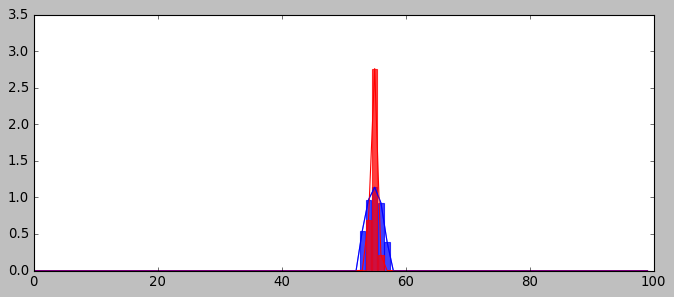

 interval =  733    ymax =  3.5


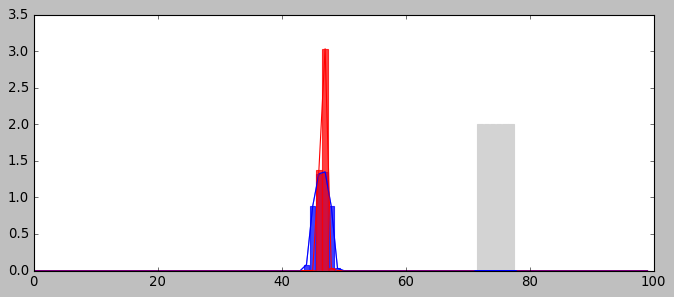

event number =  18     event_ave_chisq =  nan


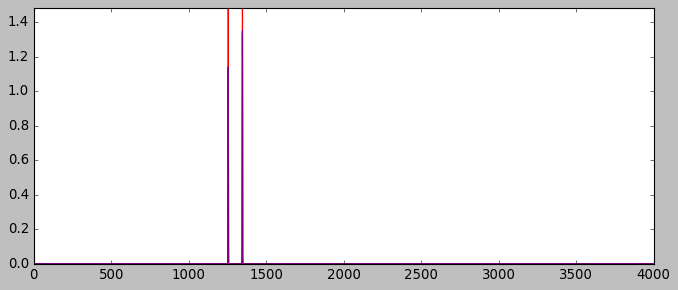

jj =  19
inputs.shape =  (8000, 9, 250)
 interval =  763    ymax =  3.5


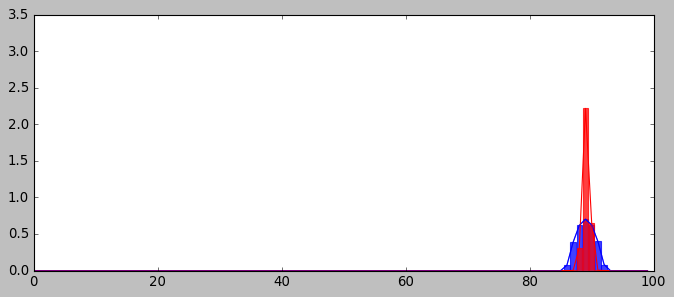

 interval =  766    ymax =  3.5


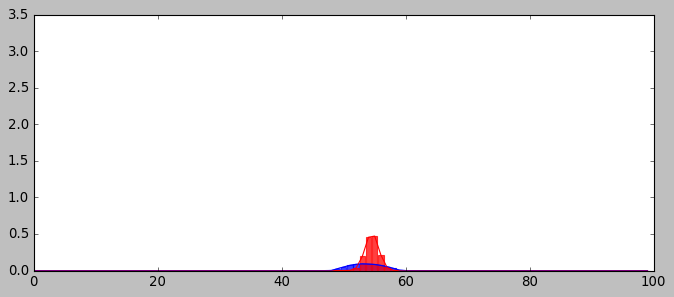

 interval =  767    ymax =  3.5


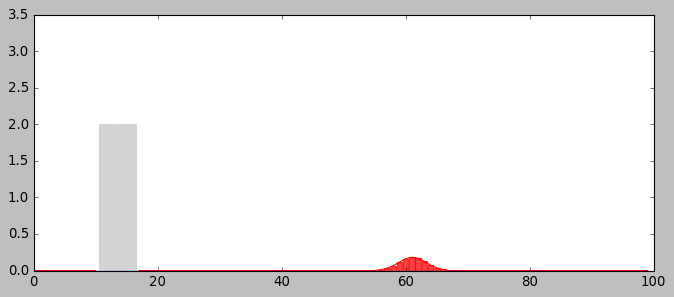

 interval =  770    ymax =  3.5


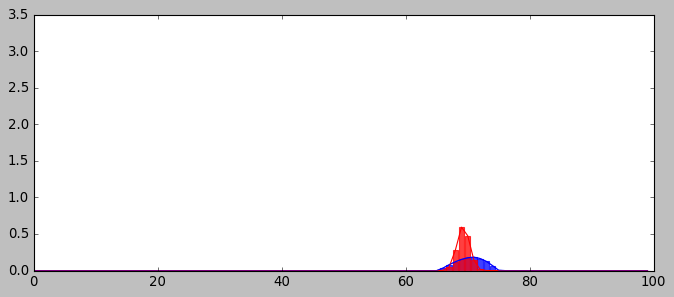

 interval =  776    ymax =  3.5


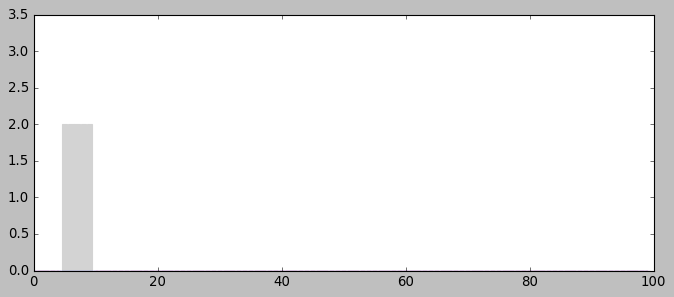

event number =  19     event_ave_chisq =  nan


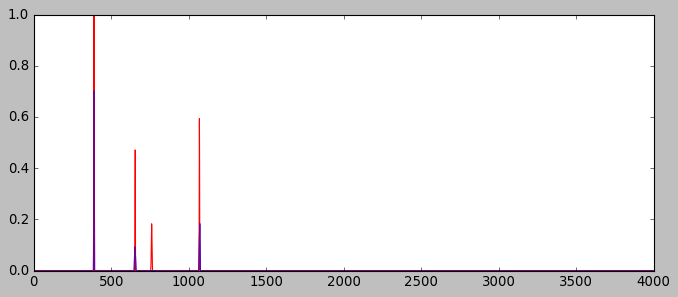

jj =  20
inputs.shape =  (8000, 9, 250)
 interval =  805    ymax =  3.5


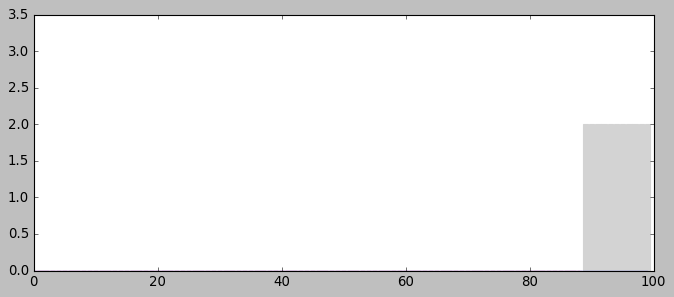

 interval =  806    ymax =  4.43603515625


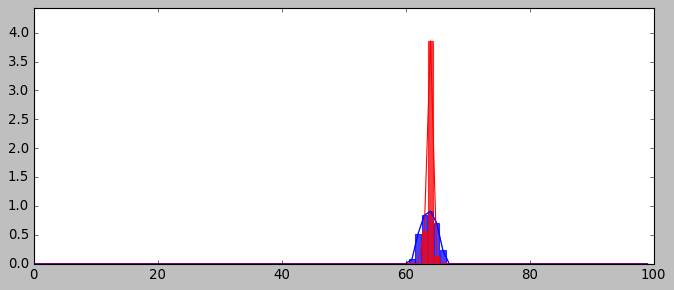

 interval =  807    ymax =  3.5


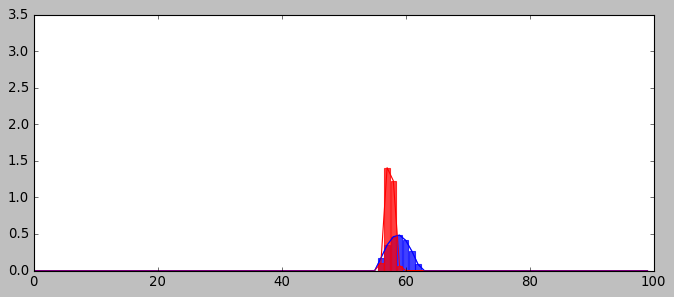

 interval =  808    ymax =  3.5


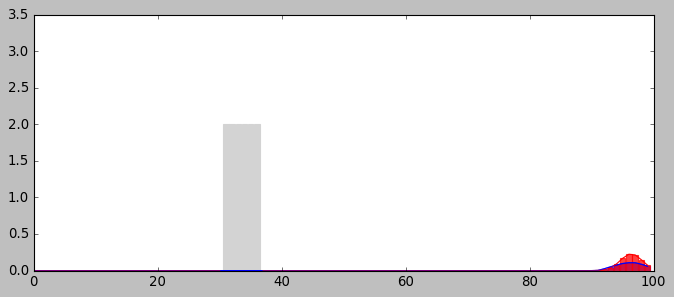

 interval =  810    ymax =  3.5


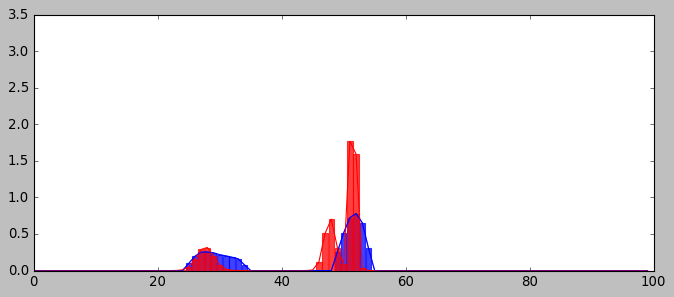

 interval =  811    ymax =  3.5


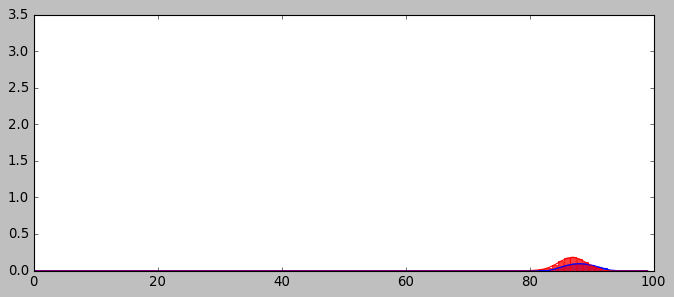

 interval =  812    ymax =  3.5


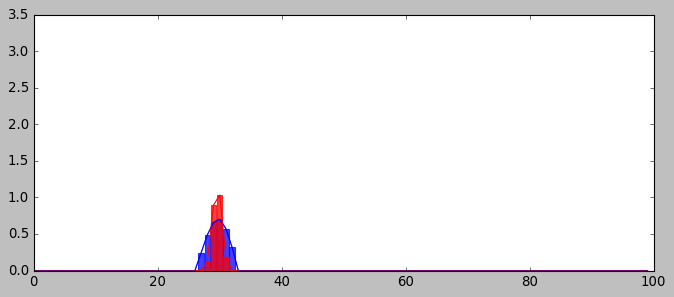

event number =  20     event_ave_chisq =  nan


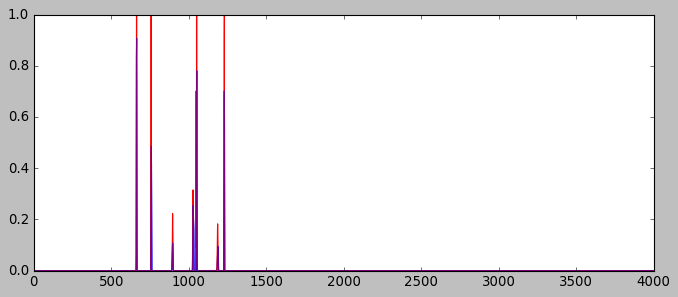

jj =  21
inputs.shape =  (8000, 9, 250)
 interval =  841    ymax =  3.5


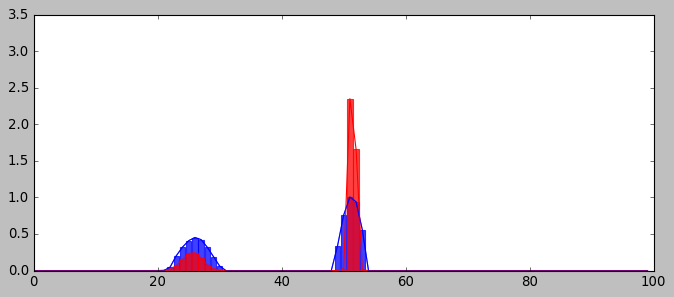

 interval =  843    ymax =  3.5


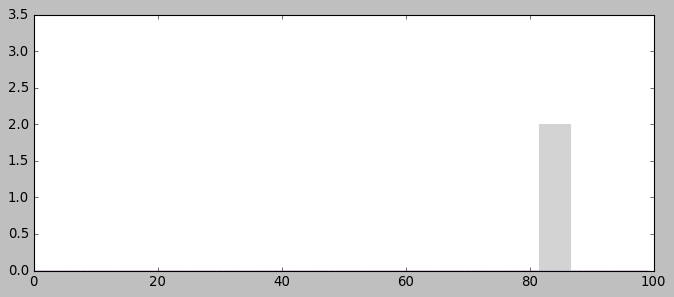

 interval =  844    ymax =  3.5


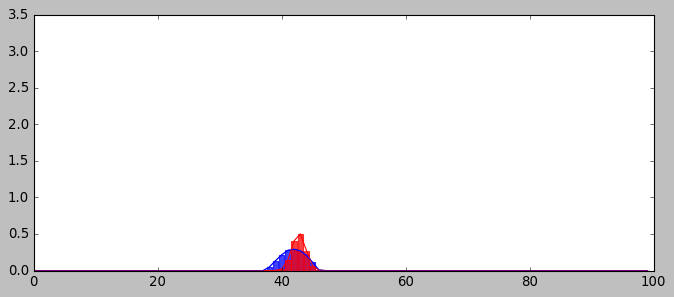

 interval =  848    ymax =  3.5


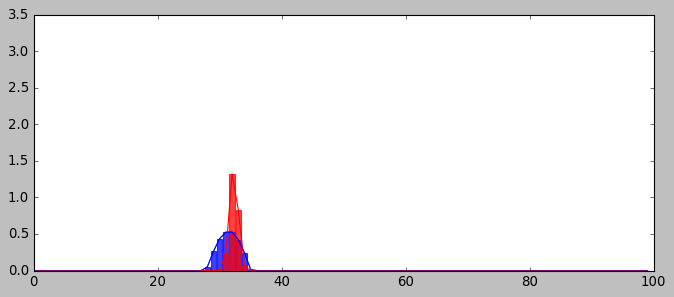

 interval =  854    ymax =  3.5


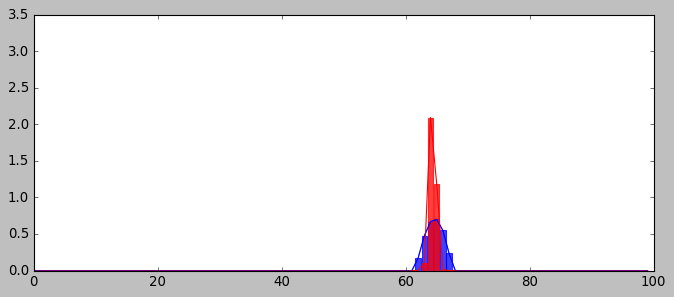

 interval =  857    ymax =  3.5


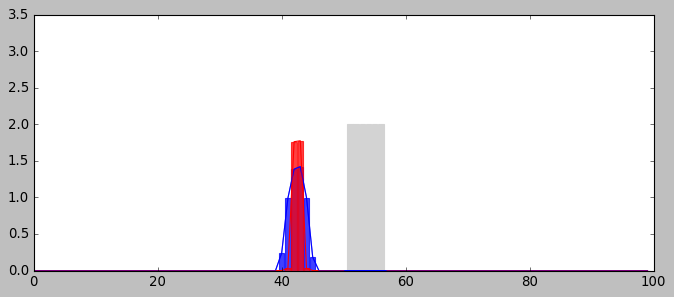

 interval =  859    ymax =  3.5


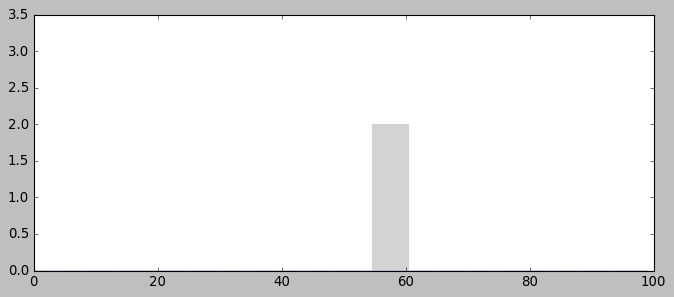

event number =  21     event_ave_chisq =  nan


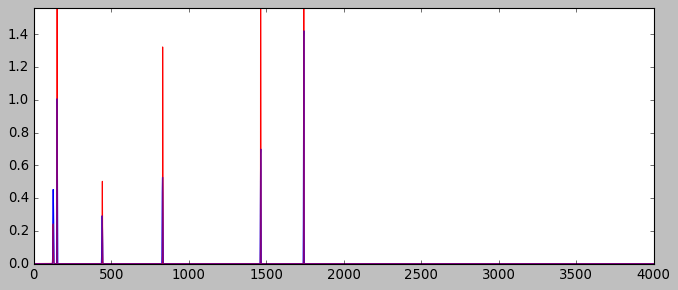

jj =  22
inputs.shape =  (8000, 9, 250)
 interval =  881    ymax =  3.5


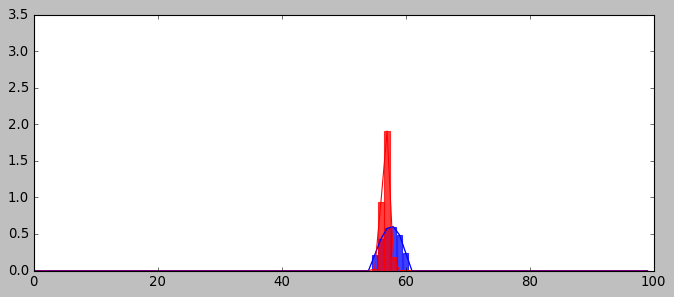

 interval =  886    ymax =  3.5


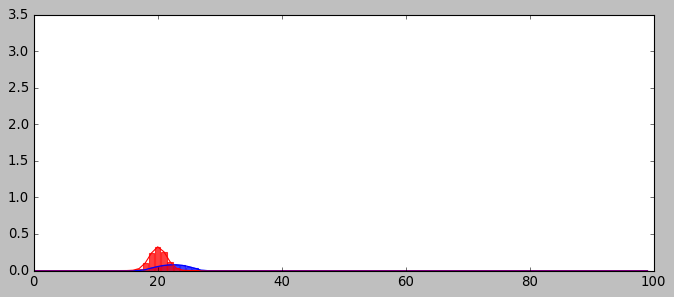

 interval =  887    ymax =  3.5


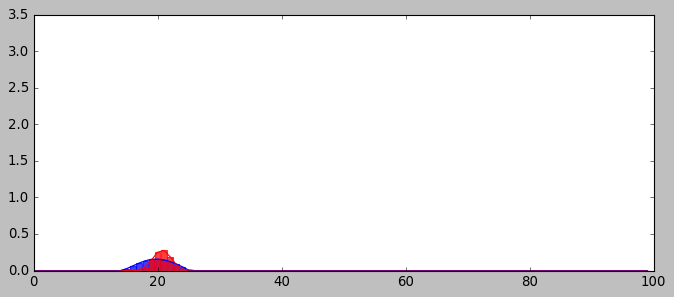

 interval =  889    ymax =  3.5


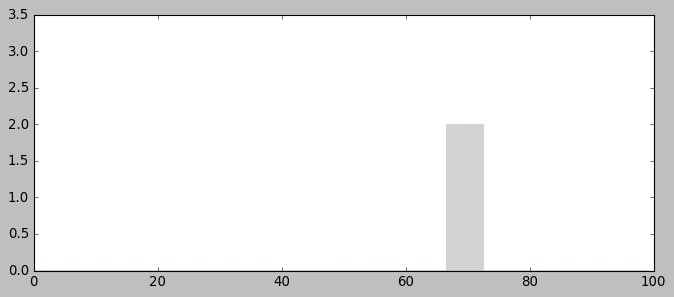

 interval =  890    ymax =  3.5


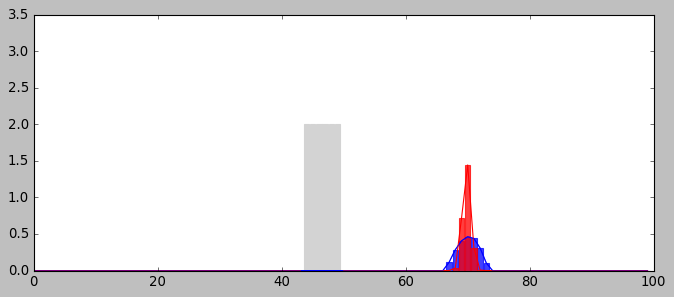

 interval =  891    ymax =  3.5


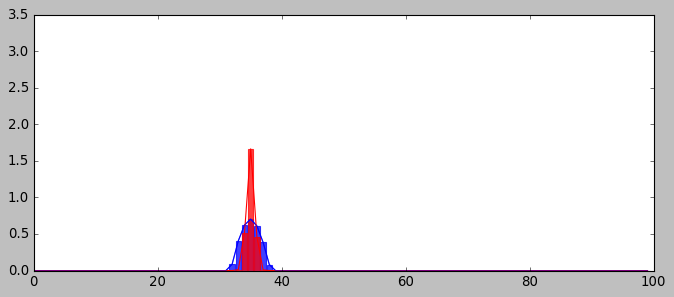

 interval =  892    ymax =  3.5


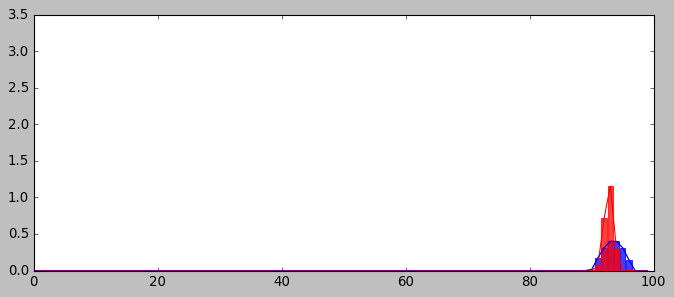

 interval =  893    ymax =  3.5


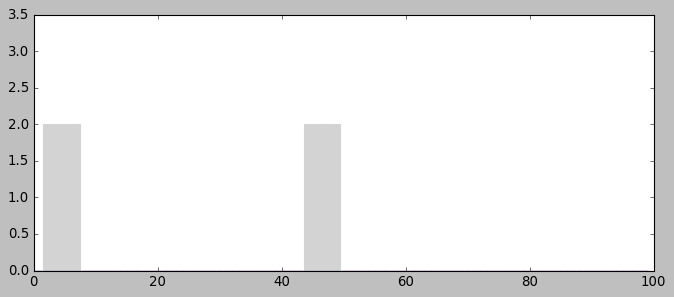

event number =  22     event_ave_chisq =  nan


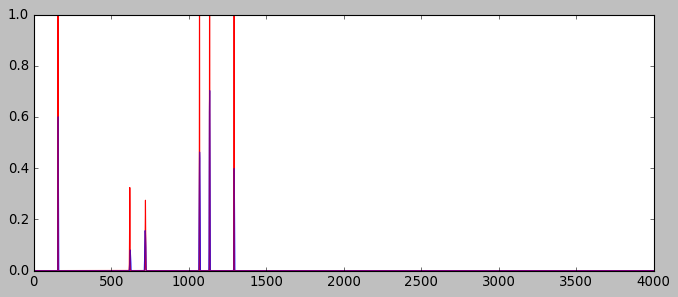

jj =  23
inputs.shape =  (8000, 9, 250)
 interval =  930    ymax =  3.5


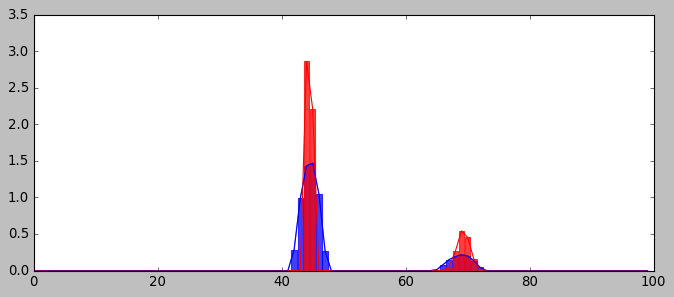

 interval =  932    ymax =  3.5


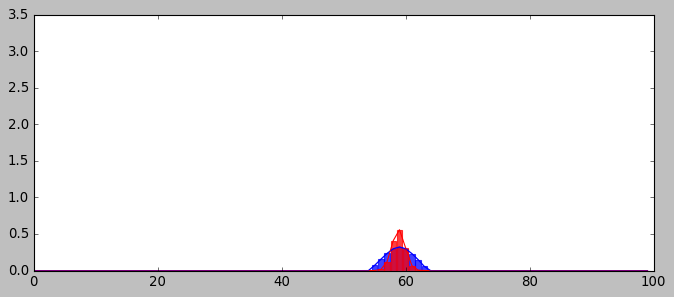

 interval =  934    ymax =  3.5


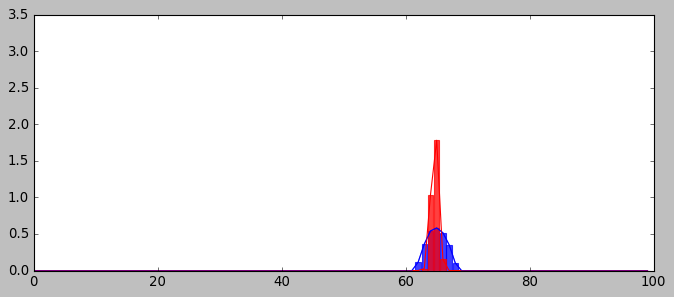

 interval =  935    ymax =  3.5


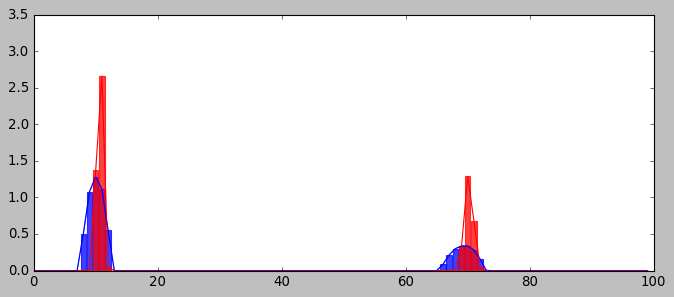

event number =  23     event_ave_chisq =  31.25123211669922


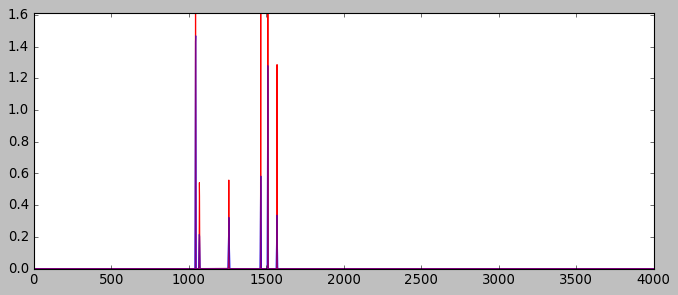

jj =  24
inputs.shape =  (8000, 9, 250)
 interval =  961    ymax =  3.5


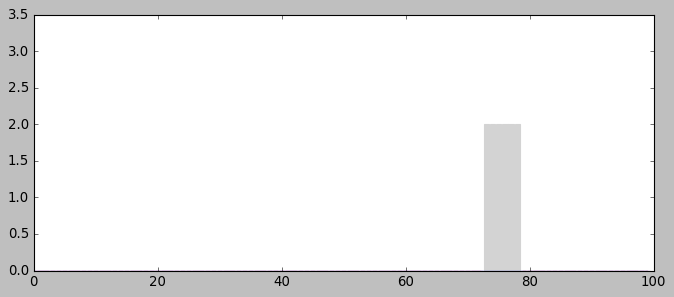

 interval =  962    ymax =  3.5


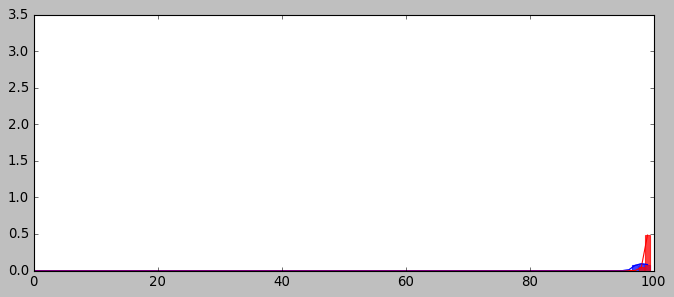

 interval =  963    ymax =  3.5


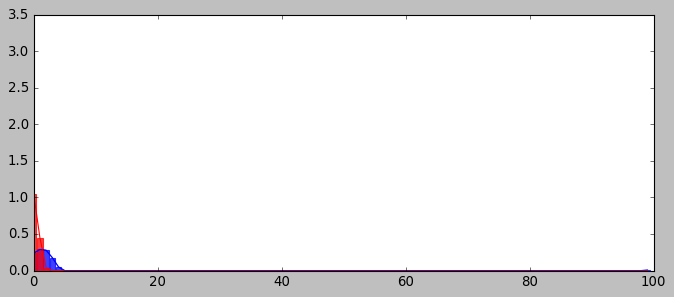

 interval =  964    ymax =  3.5


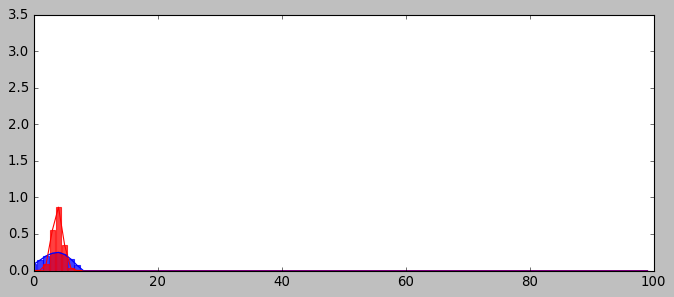

 interval =  965    ymax =  3.5


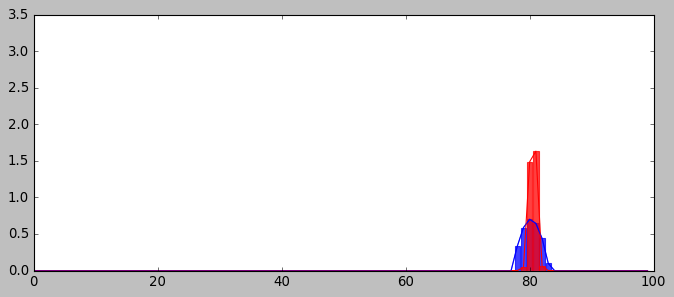

 interval =  967    ymax =  3.5


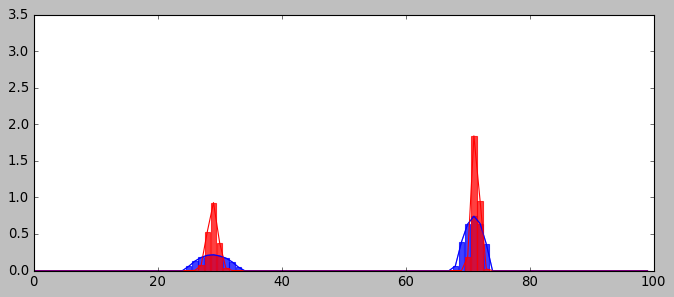

 interval =  969    ymax =  3.5


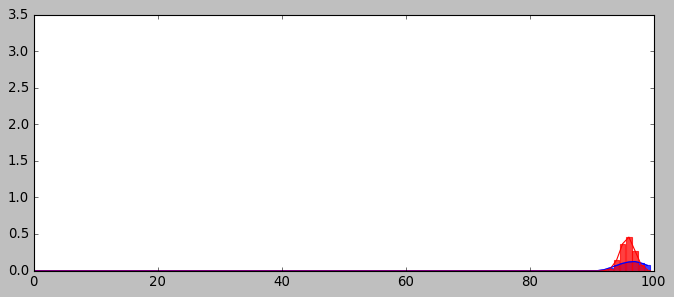

 interval =  971    ymax =  3.5


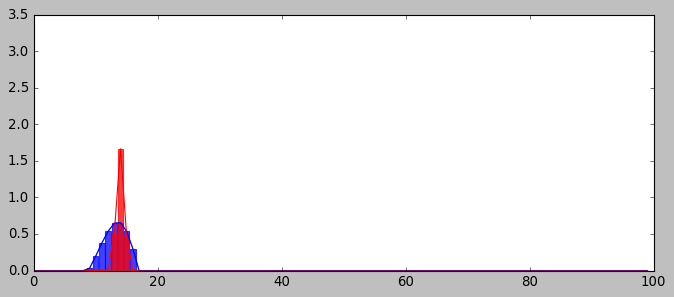

 interval =  973    ymax =  3.5


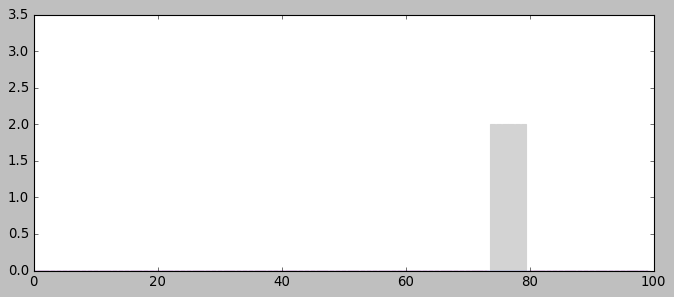

event number =  24     event_ave_chisq =  nan


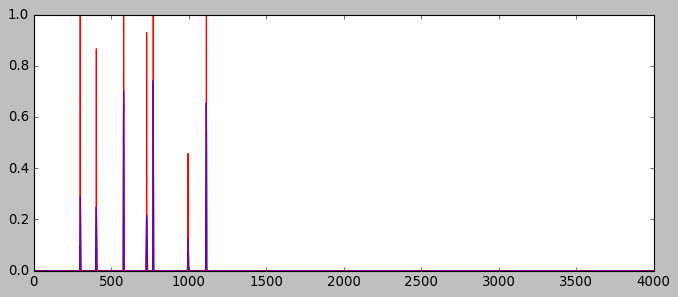

jj =  25
inputs.shape =  (8000, 9, 250)
 interval =  1006    ymax =  3.5


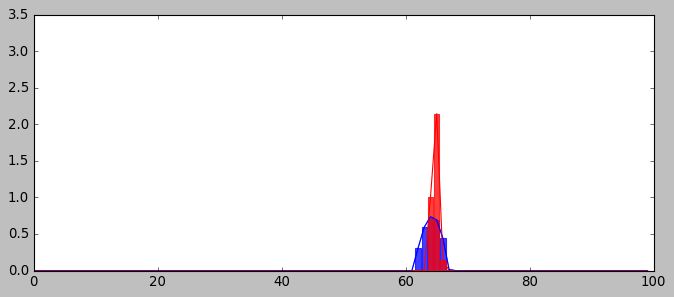

 interval =  1010    ymax =  3.5


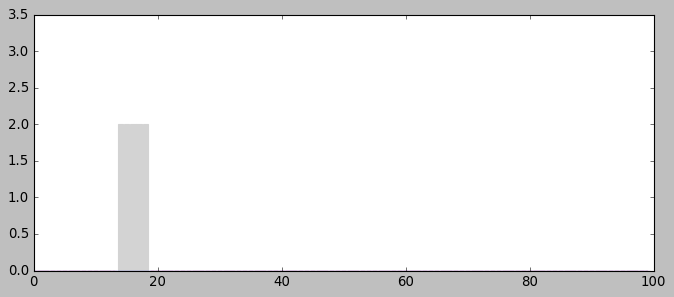

 interval =  1011    ymax =  3.5


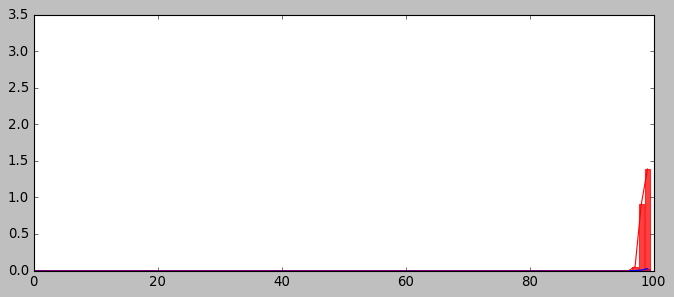

 interval =  1012    ymax =  3.5


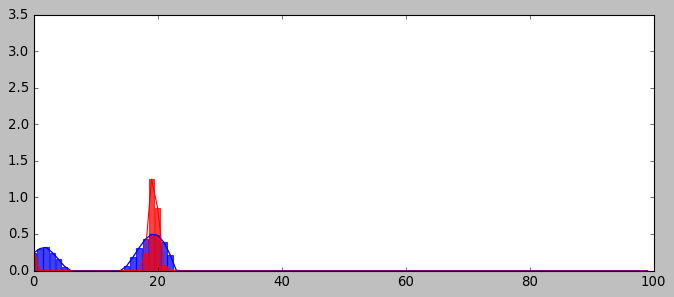

 interval =  1013    ymax =  3.5


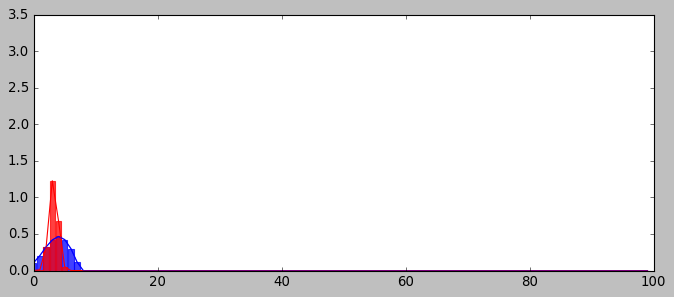

 interval =  1018    ymax =  3.5


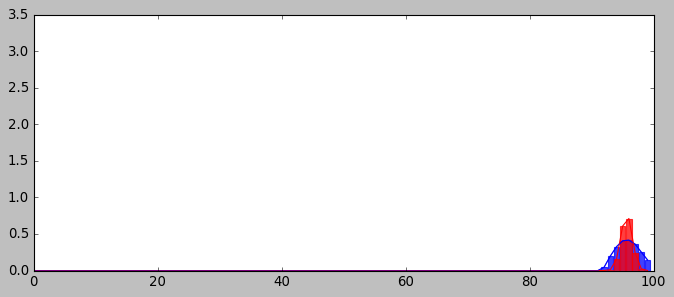

event number =  25     event_ave_chisq =  nan


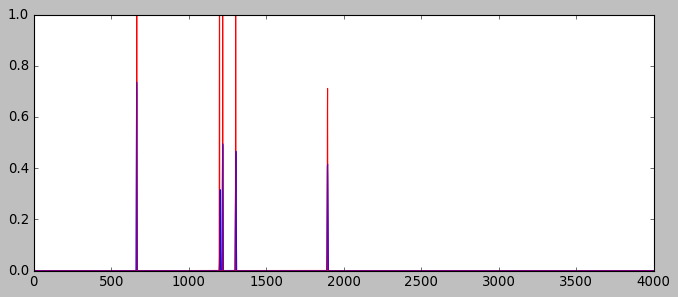

jj =  26
inputs.shape =  (8000, 9, 250)
 interval =  1045    ymax =  3.5


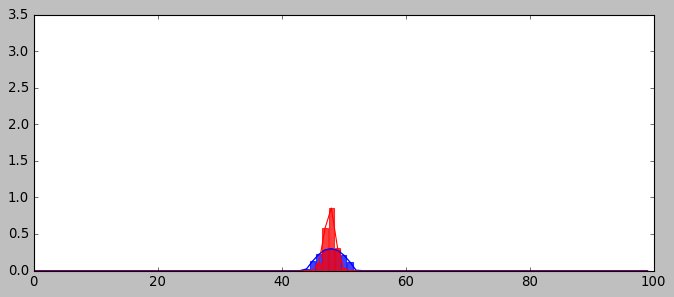

 interval =  1047    ymax =  3.5


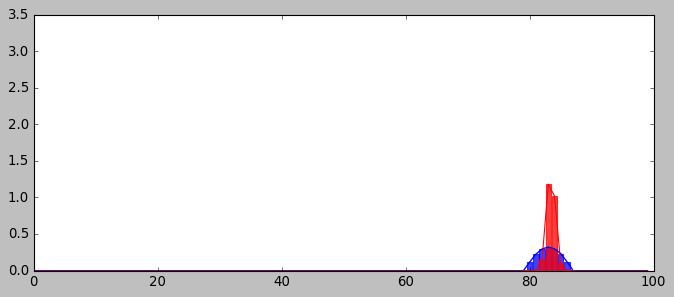

 interval =  1049    ymax =  3.5


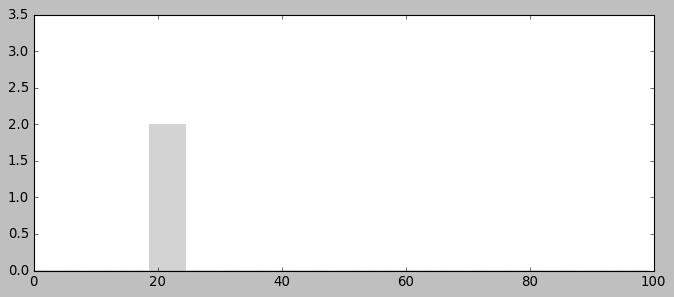

 interval =  1051    ymax =  3.5


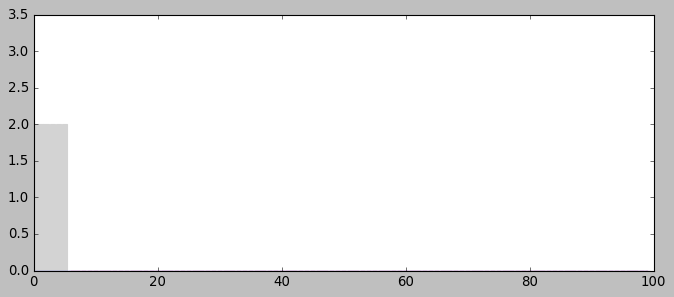

 interval =  1052    ymax =  3.5


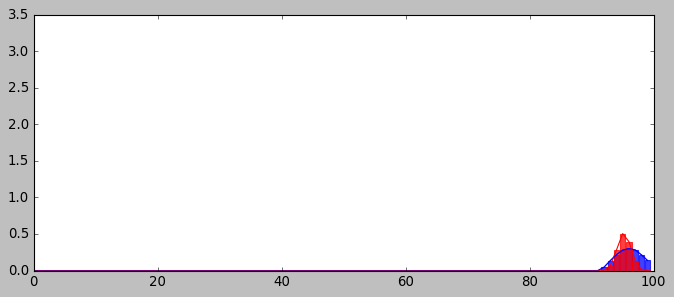

 interval =  1058    ymax =  3.5


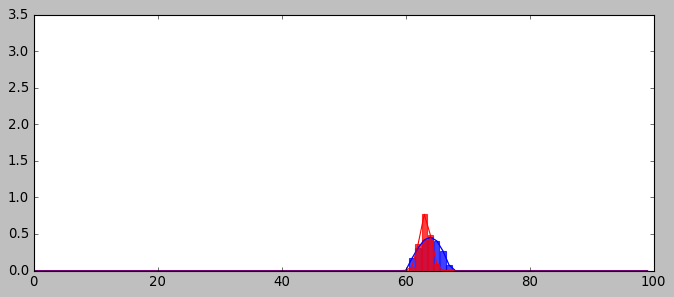

 interval =  1060    ymax =  3.5


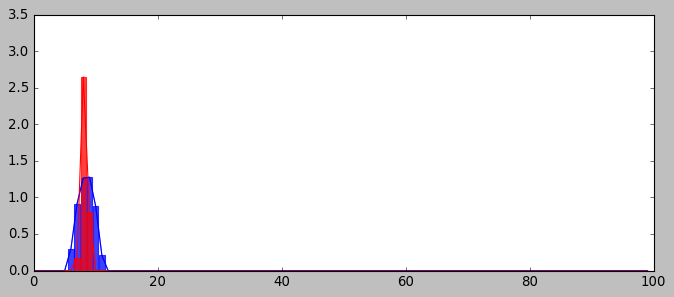

event number =  26     event_ave_chisq =  nan


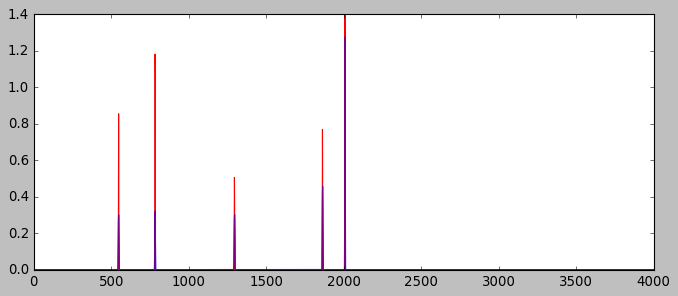

jj =  27
inputs.shape =  (8000, 9, 250)
 interval =  1080    ymax =  3.5


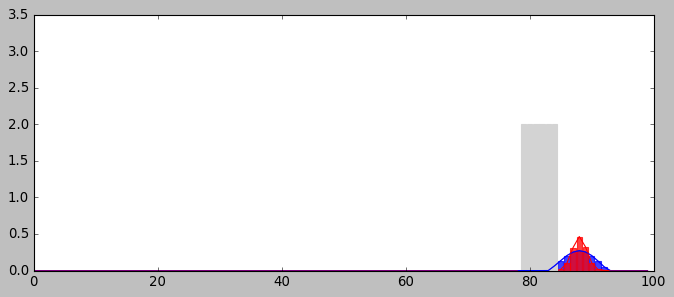

 interval =  1082    ymax =  3.5


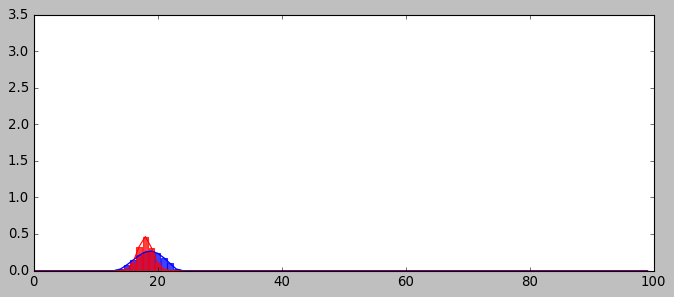

 interval =  1086    ymax =  3.5


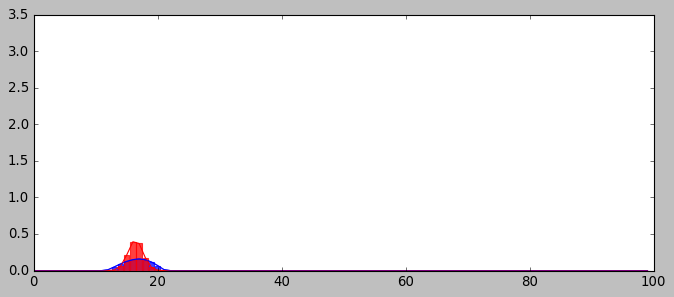

 interval =  1087    ymax =  3.5


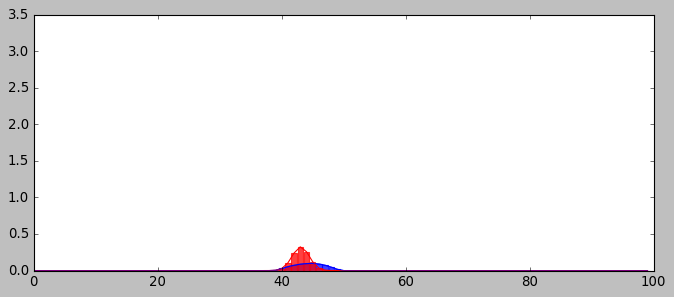

 interval =  1088    ymax =  3.5


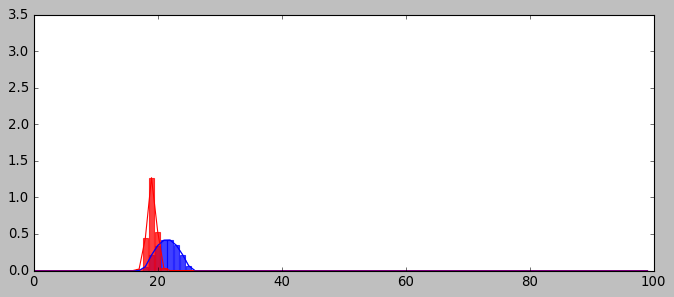

 interval =  1097    ymax =  3.5


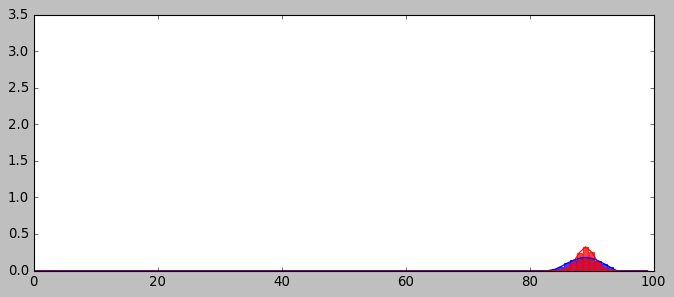

event number =  27     event_ave_chisq =  nan


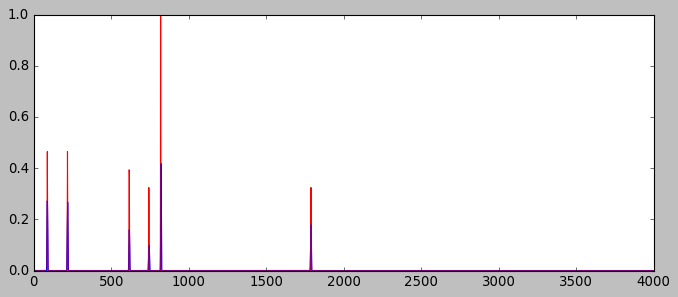

jj =  28
inputs.shape =  (8000, 9, 250)
 interval =  1125    ymax =  3.5


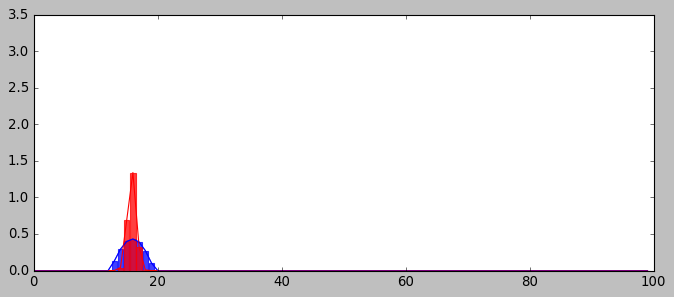

 interval =  1126    ymax =  3.5


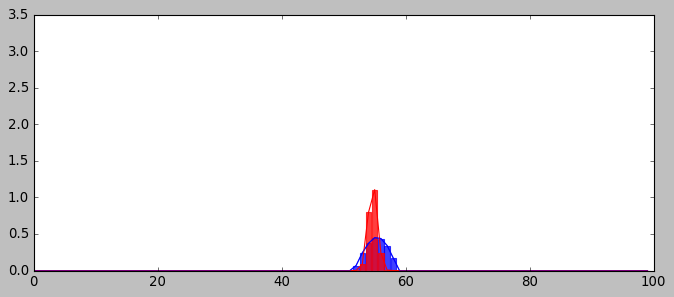

 interval =  1129    ymax =  3.5


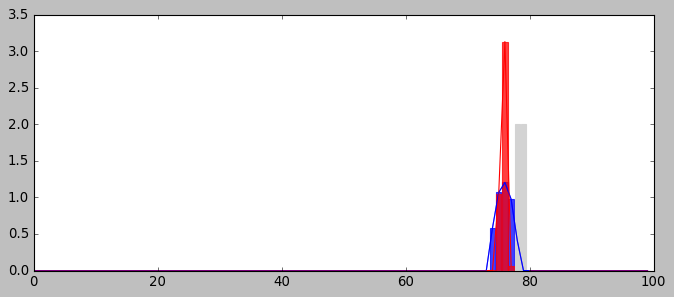

 interval =  1135    ymax =  3.5


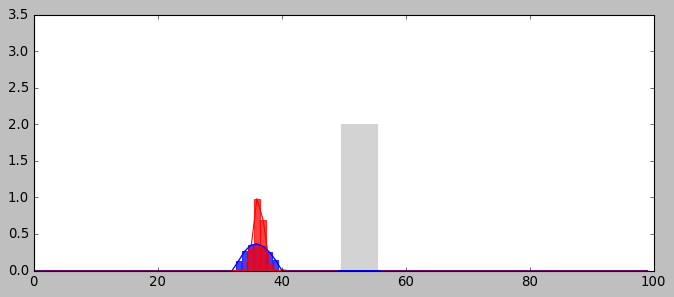

event number =  28     event_ave_chisq =  nan


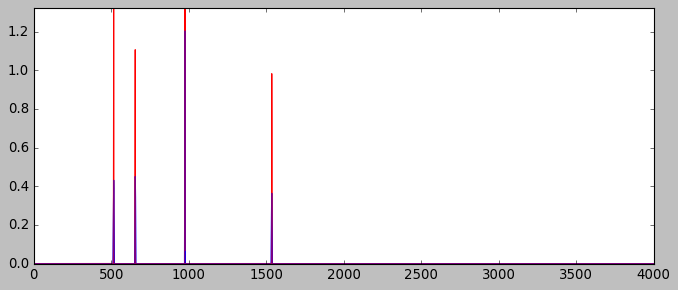

jj =  29
inputs.shape =  (8000, 9, 250)
 interval =  1166    ymax =  3.5


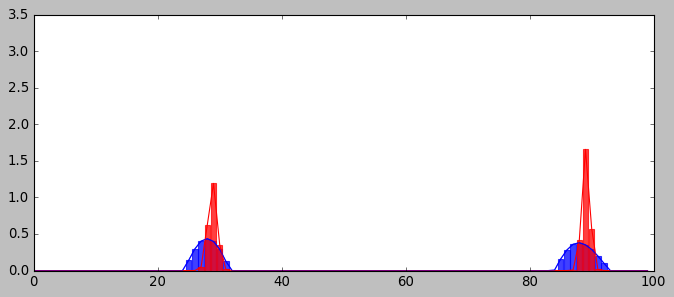

 interval =  1171    ymax =  3.5


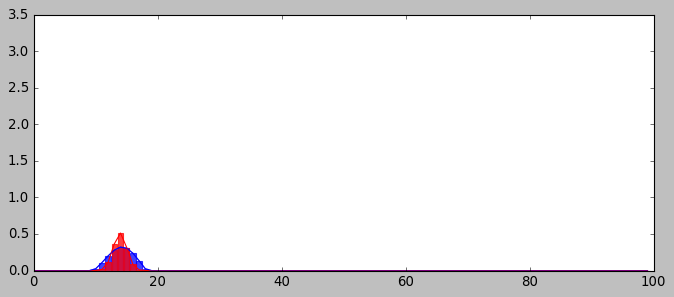

 interval =  1172    ymax =  3.5


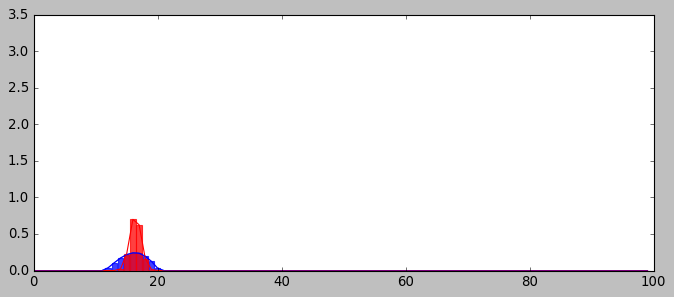

 interval =  1180    ymax =  3.5


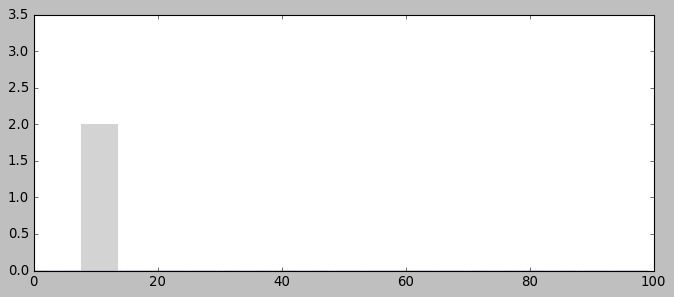

event number =  29     event_ave_chisq =  nan


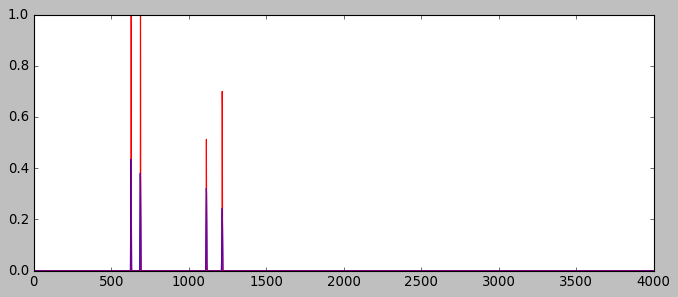

jj =  30
inputs.shape =  (8000, 9, 250)
 interval =  1200    ymax =  3.5


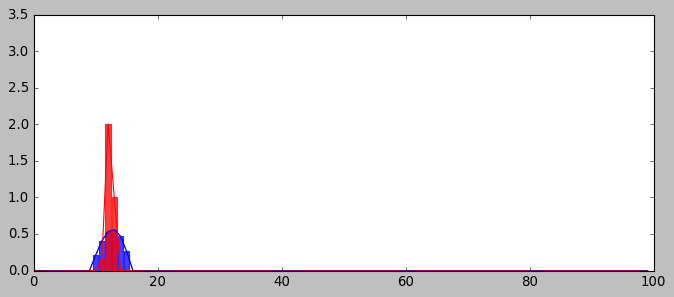

 interval =  1203    ymax =  3.5


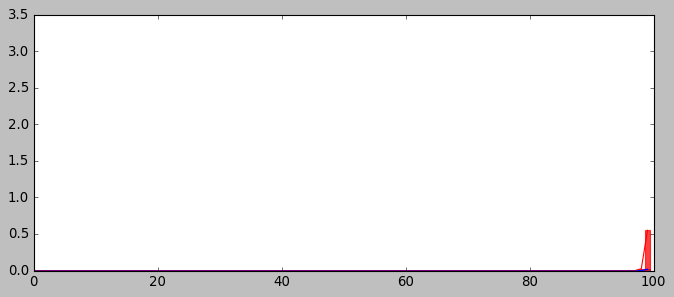

 interval =  1204    ymax =  3.5


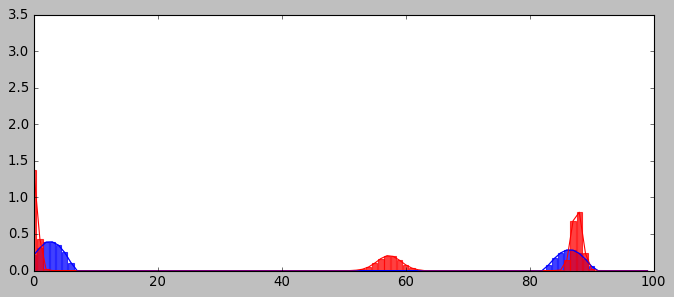

 interval =  1206    ymax =  3.5


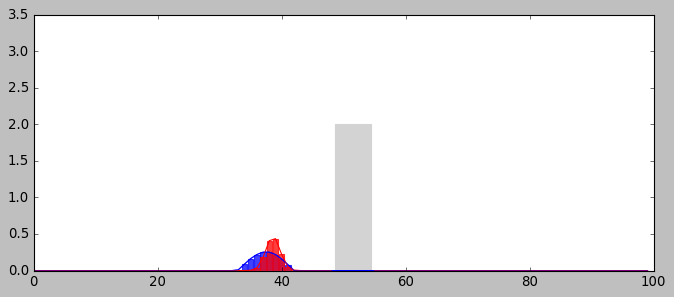

 interval =  1207    ymax =  3.5


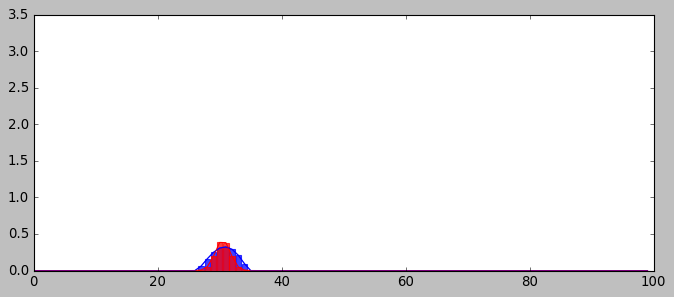

 interval =  1210    ymax =  3.5


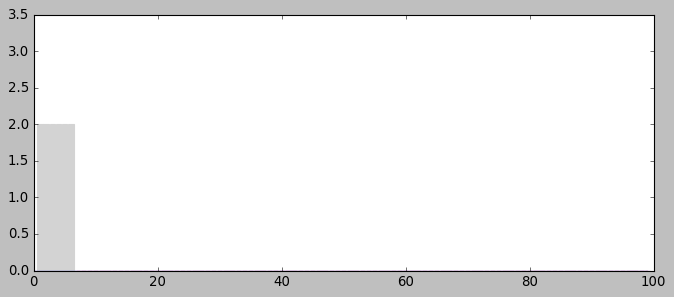

 interval =  1211    ymax =  3.5


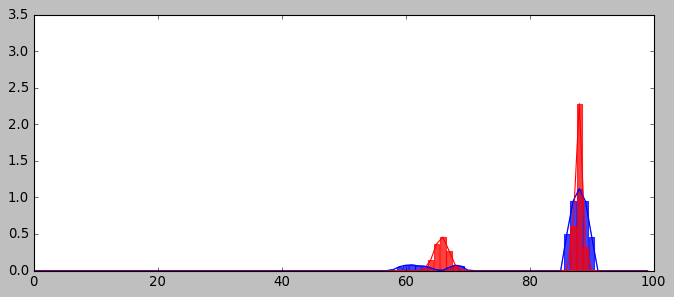

 interval =  1212    ymax =  3.5


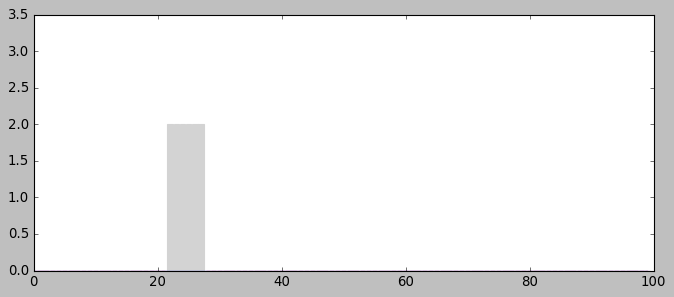

 interval =  1213    ymax =  3.5


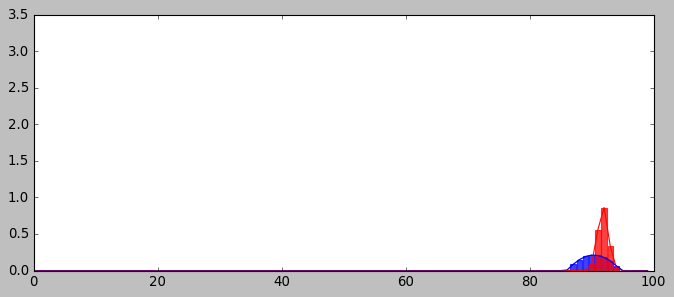

 interval =  1214    ymax =  3.5


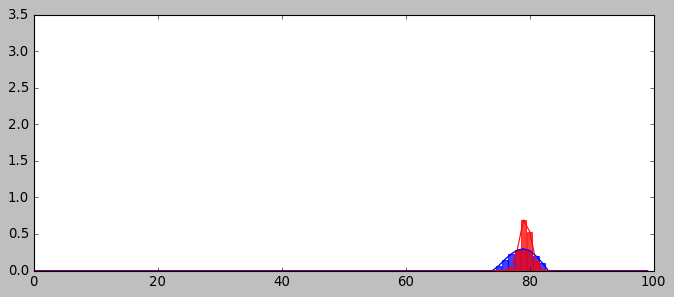

 interval =  1217    ymax =  3.5


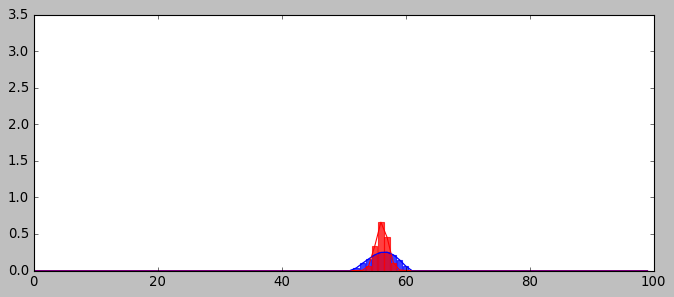

event number =  30     event_ave_chisq =  nan


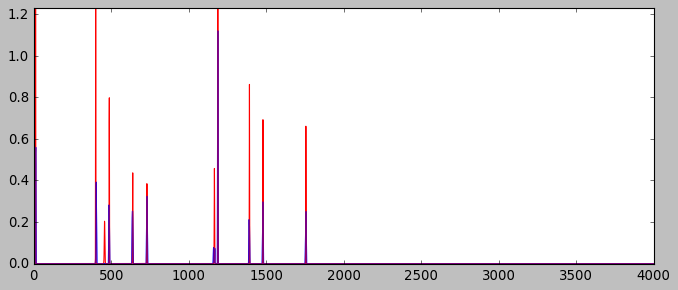

jj =  31
inputs.shape =  (8000, 9, 250)
 interval =  1240    ymax =  3.5


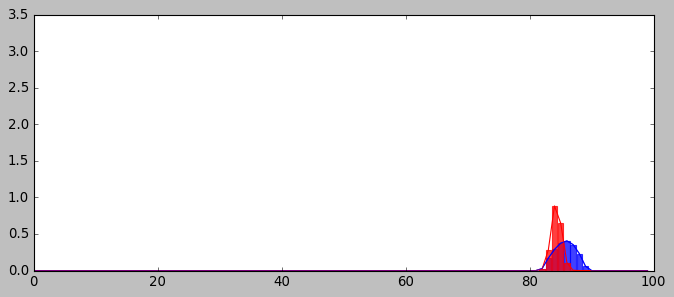

 interval =  1248    ymax =  3.5


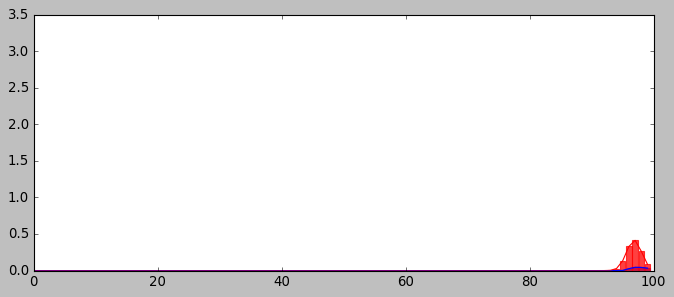

 interval =  1250    ymax =  3.5


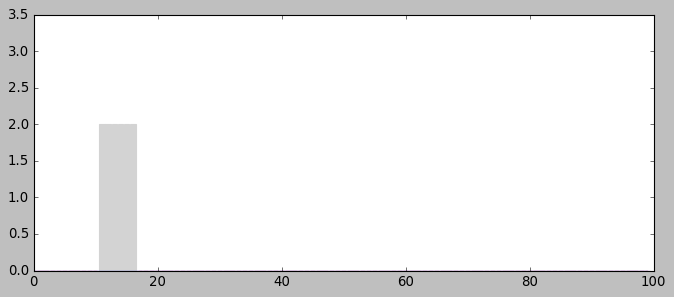

 interval =  1254    ymax =  3.5


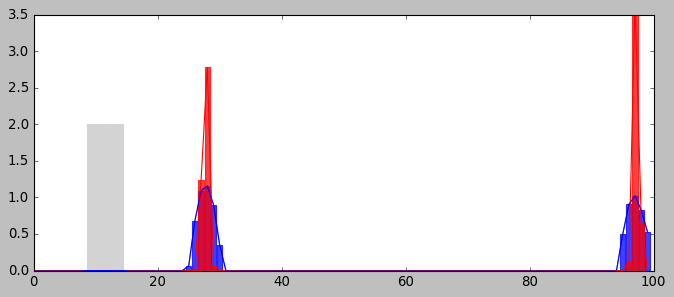

 interval =  1258    ymax =  3.5


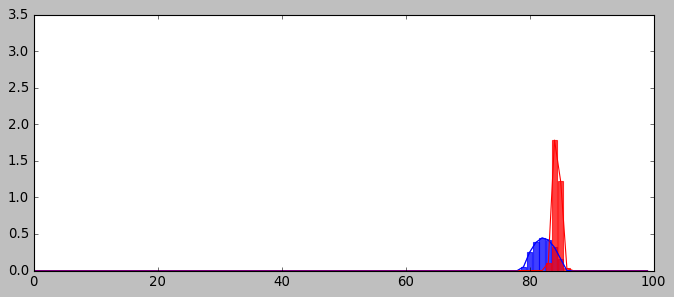

event number =  31     event_ave_chisq =  nan


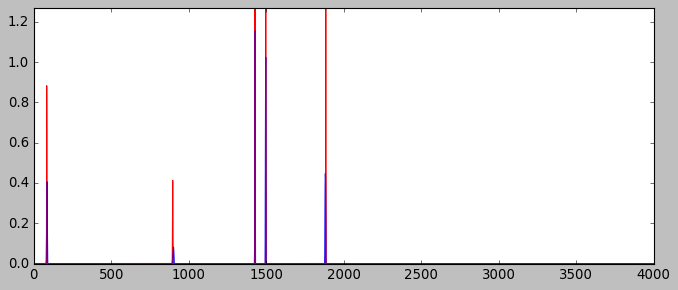

jj =  32
inputs.shape =  (8000, 9, 250)
 interval =  1284    ymax =  3.5


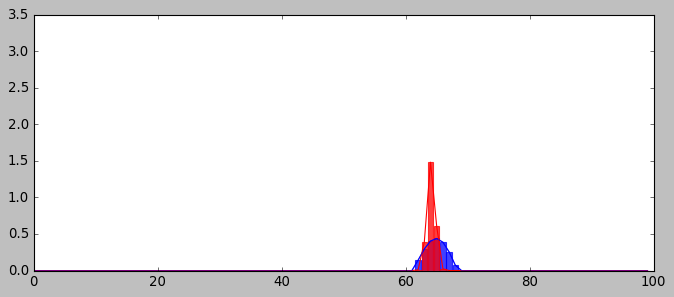

 interval =  1289    ymax =  3.5


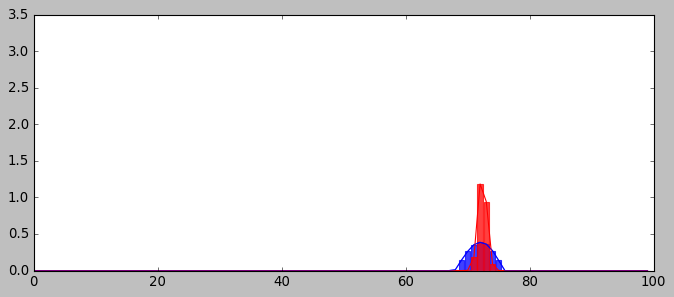

 interval =  1291    ymax =  3.5


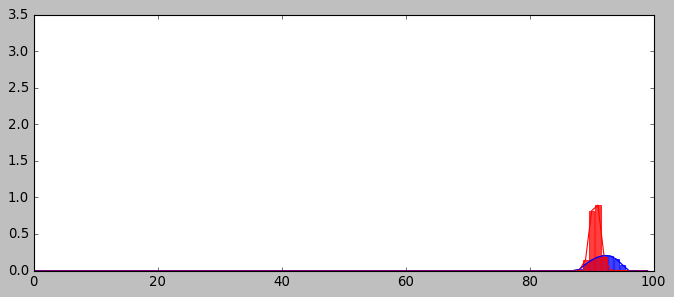

 interval =  1294    ymax =  3.5


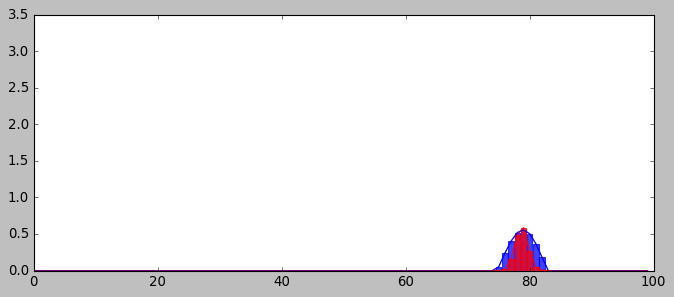

 interval =  1298    ymax =  3.5


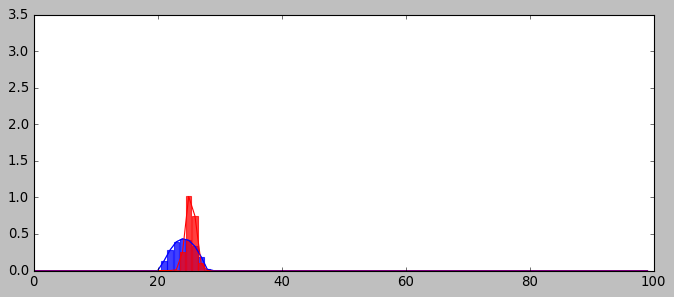

event number =  32     event_ave_chisq =  11.795131408691407


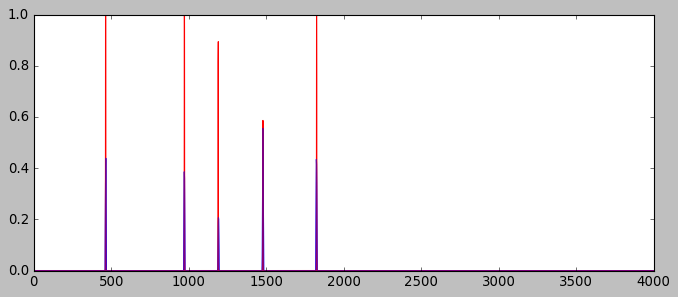

jj =  33
inputs.shape =  (8000, 9, 250)
 interval =  1324    ymax =  3.5


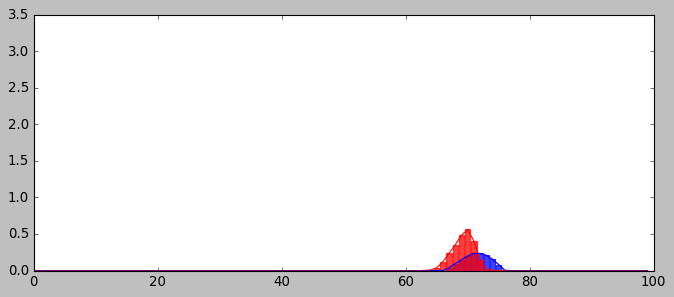

 interval =  1325    ymax =  4.2046874999999995


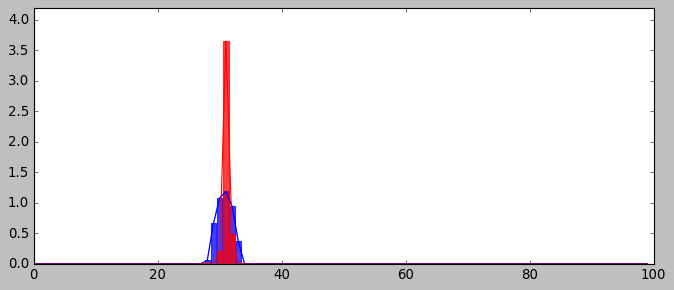

 interval =  1326    ymax =  3.5


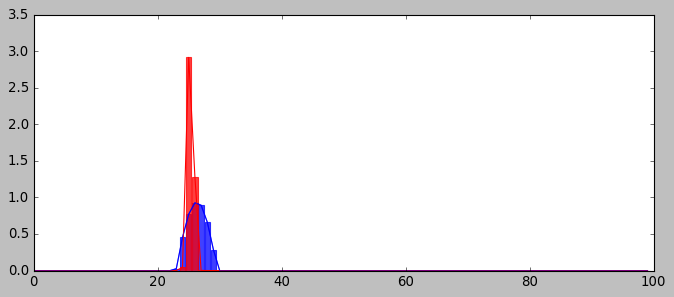

 interval =  1328    ymax =  3.5


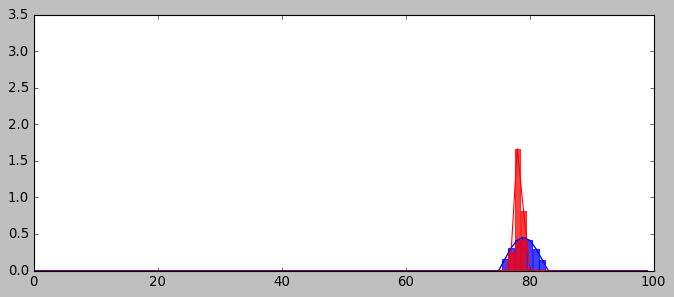

 interval =  1329    ymax =  3.5


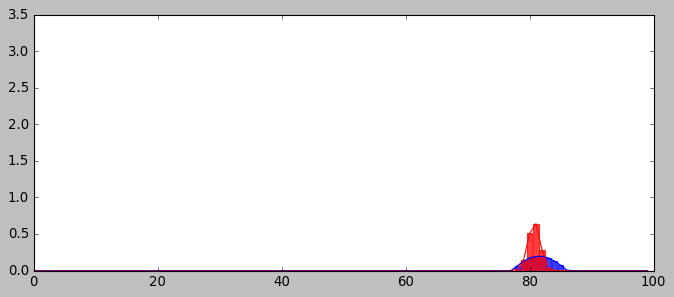

 interval =  1331    ymax =  3.5


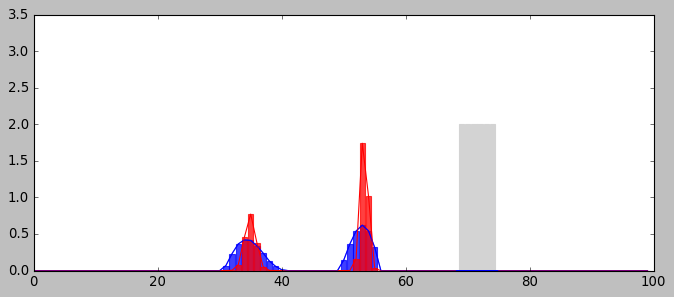

 interval =  1333    ymax =  3.5


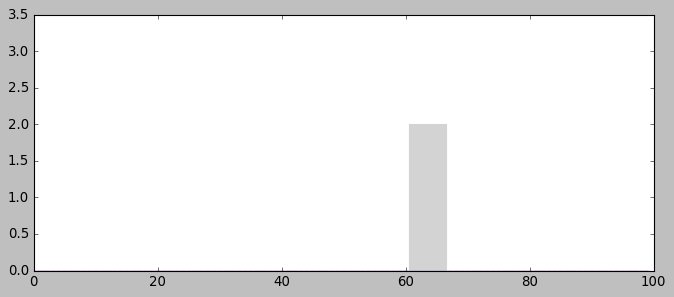

event number =  33     event_ave_chisq =  nan


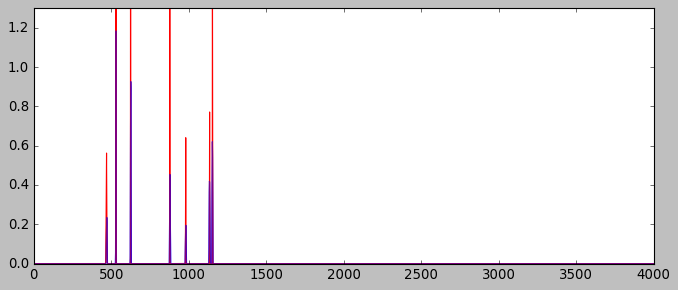

jj =  34
inputs.shape =  (8000, 9, 250)
 interval =  1363    ymax =  3.5


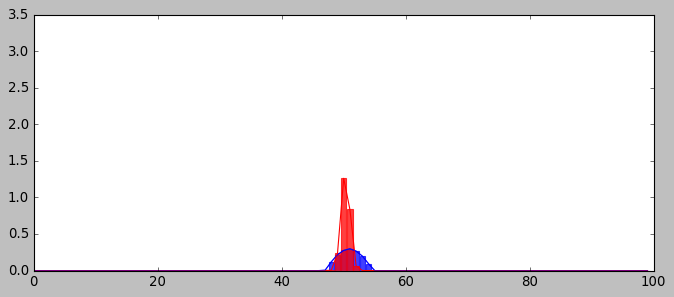

 interval =  1364    ymax =  3.5


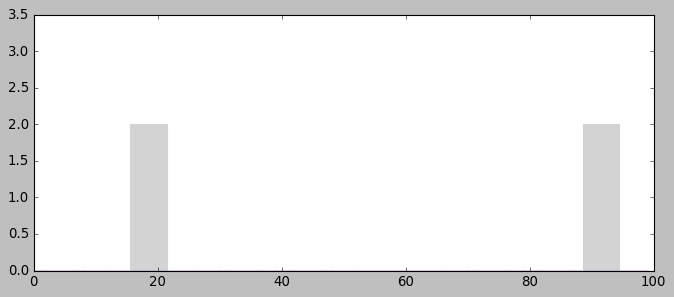

 interval =  1369    ymax =  3.5


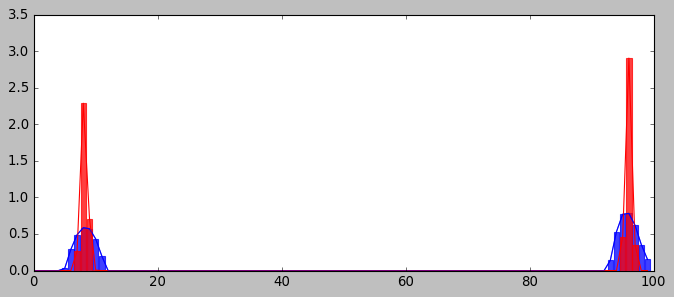

 interval =  1371    ymax =  6.88203125


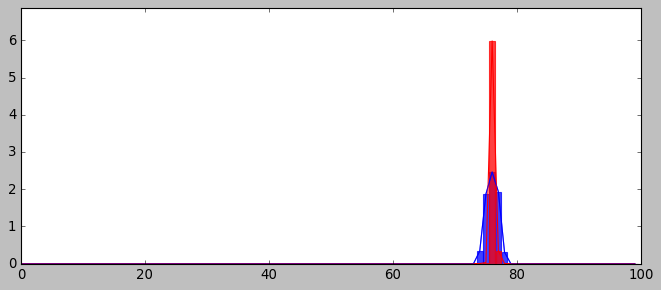

 interval =  1373    ymax =  3.5


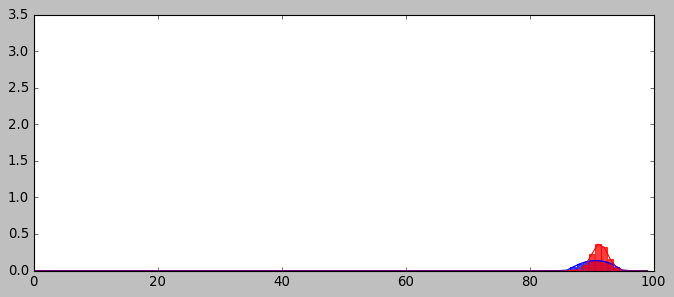

 interval =  1374    ymax =  3.5


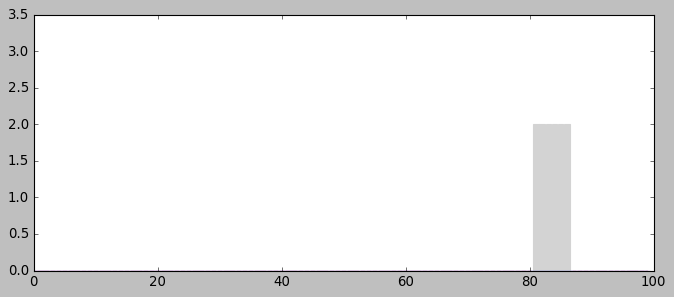

 interval =  1378    ymax =  3.5


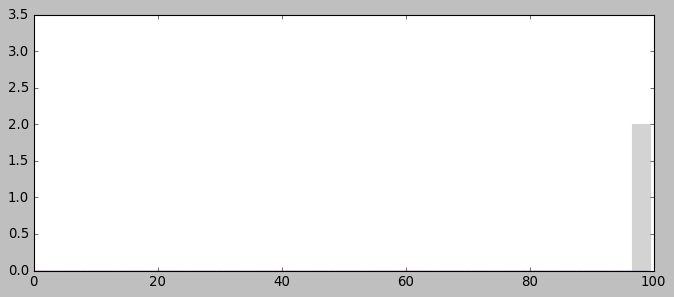

 interval =  1379    ymax =  3.5


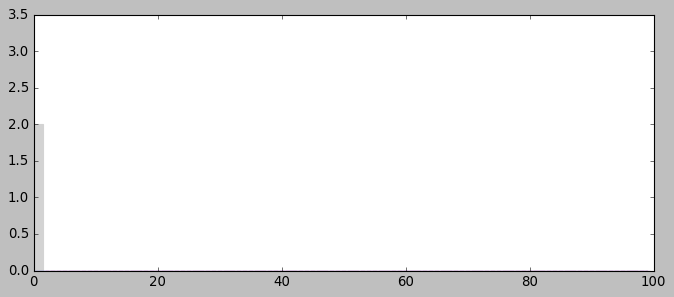

event number =  34     event_ave_chisq =  nan


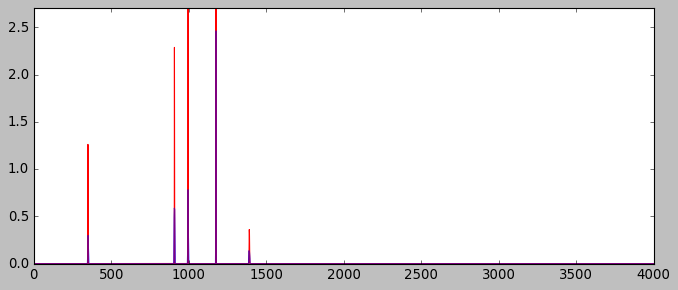

jj =  35
inputs.shape =  (8000, 9, 250)
 interval =  1400    ymax =  3.5


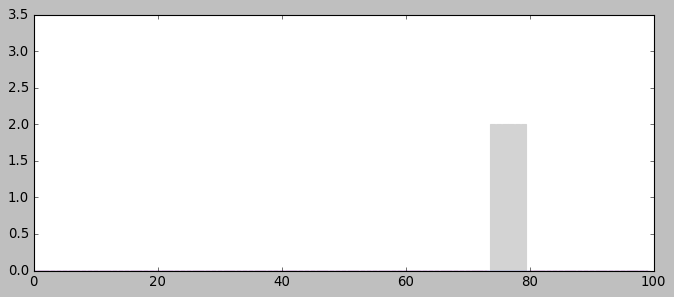

 interval =  1405    ymax =  3.5


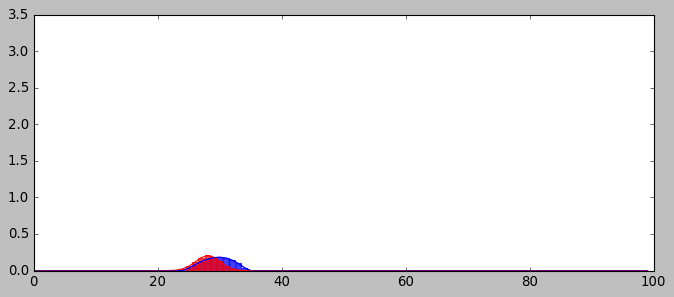

 interval =  1407    ymax =  3.5


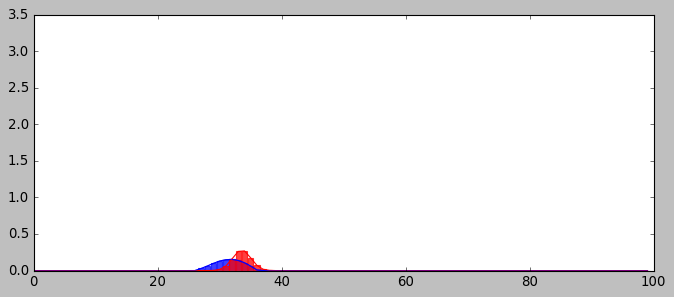

 interval =  1408    ymax =  3.5


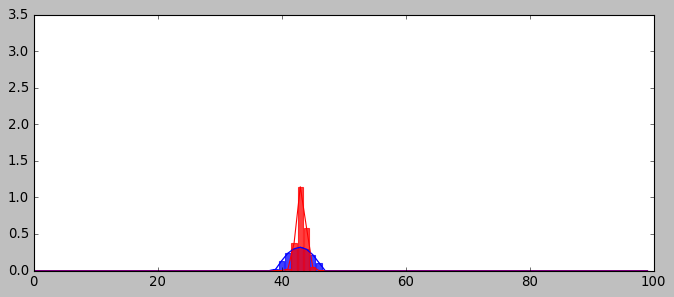

 interval =  1409    ymax =  3.5


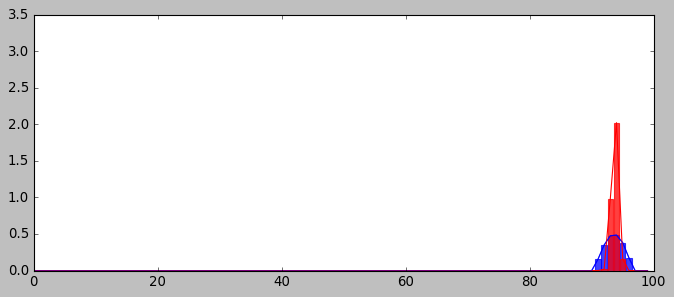

 interval =  1410    ymax =  3.5


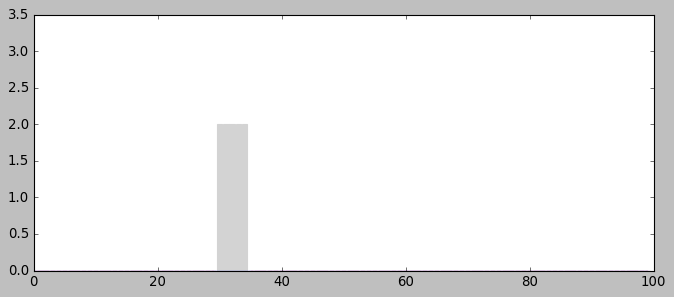

 interval =  1411    ymax =  3.5


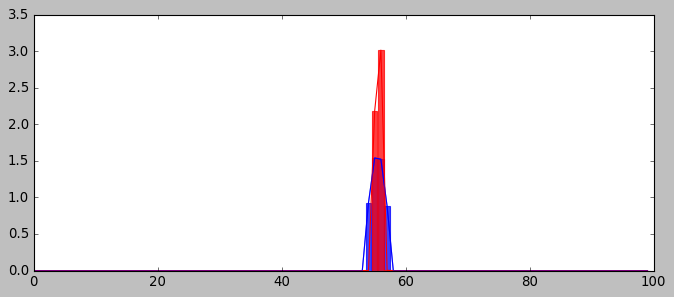

 interval =  1413    ymax =  3.5


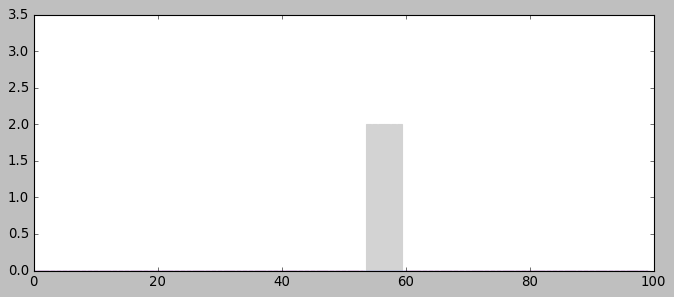

 interval =  1414    ymax =  3.5


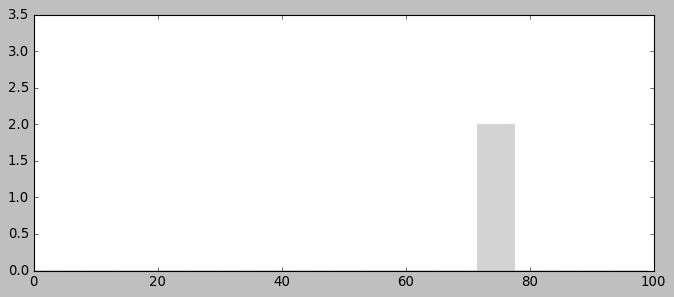

 interval =  1415    ymax =  3.5


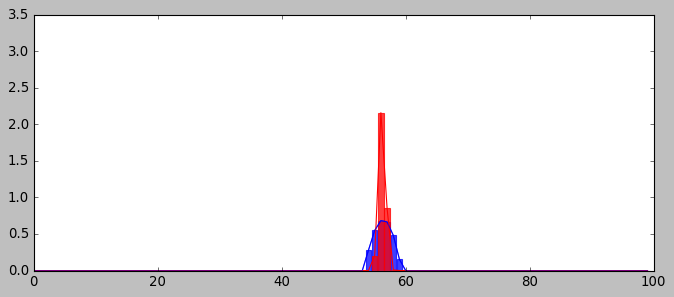

 interval =  1416    ymax =  3.5


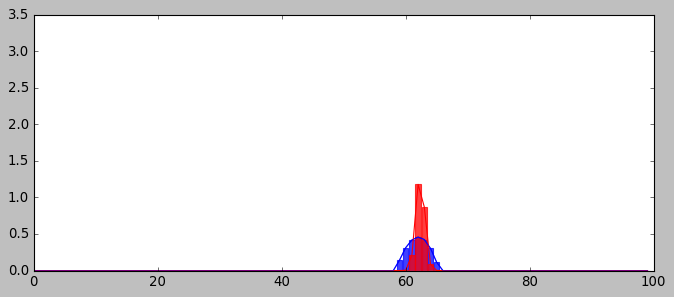

 interval =  1420    ymax =  3.5


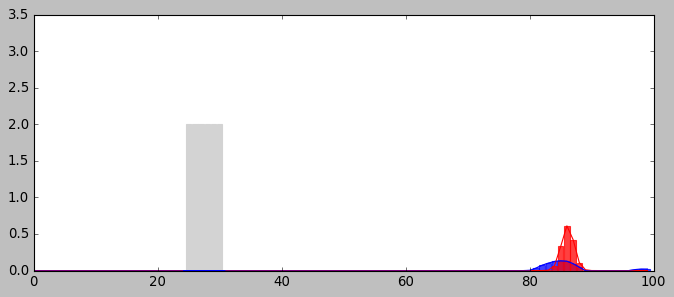

event number =  35     event_ave_chisq =  nan


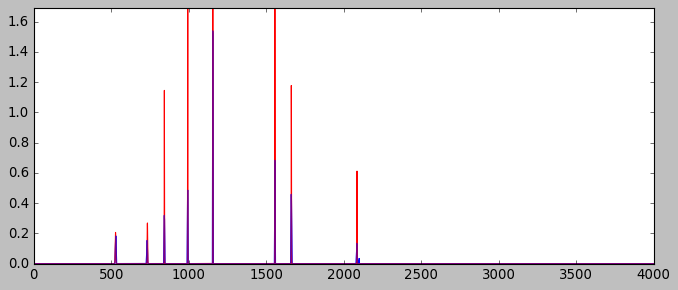

jj =  36
inputs.shape =  (8000, 9, 250)
 interval =  1445    ymax =  3.5


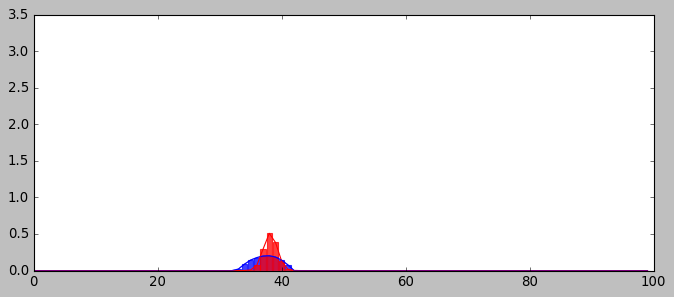

 interval =  1447    ymax =  3.5


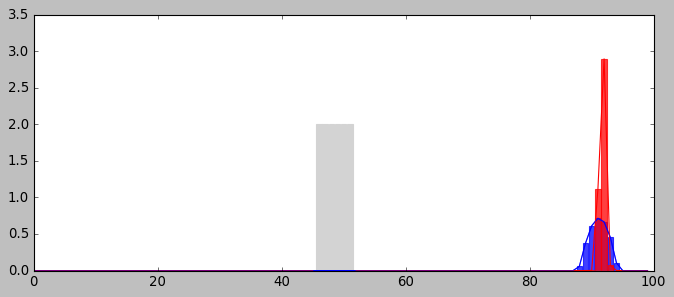

 interval =  1450    ymax =  3.5


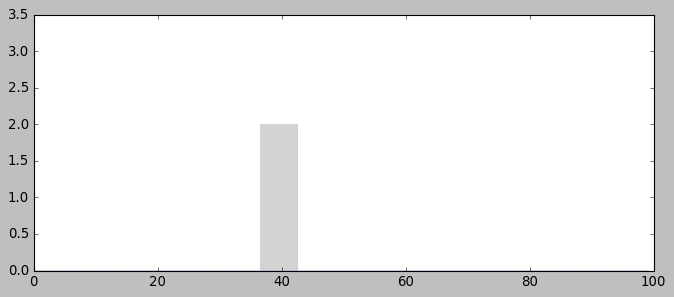

 interval =  1452    ymax =  3.5


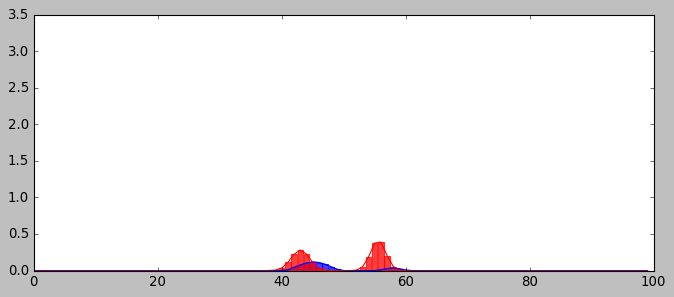

 interval =  1455    ymax =  3.5


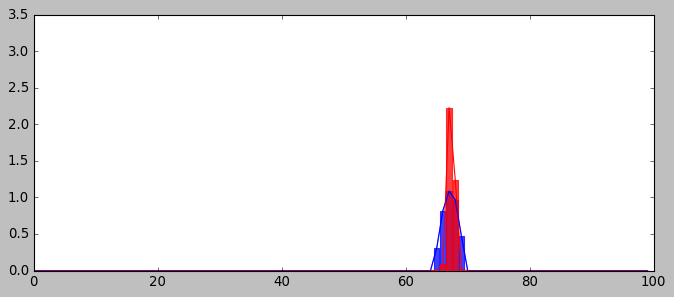

In [ ]:
listOfEvents = np.arange(100)
for jj in listOfEvents:

    event_label  = np.asarray([])
    event_output = np.asarray([])
    print("jj = ",jj)
    print("inputs.shape = ",inputs.shape)
    event_chisq = 0.
    for interval in range(jj*40,jj*40+40):
        input = inputs[interval]
        label = np.asarray(labels[interval])
        output = np.asarray(outputs[interval])
        
        nFeatures = len(label)
        
        sigma = 0.01
        diff = np.subtract(output,label)
        diffS = diff/sigma
        chisq = np.power(diffS,2)
        local_ave_chisq = chisq.sum()/nFeatures
        event_chisq += local_ave_chisq
##        print('local_ave_chisq = ',local_ave_chisq,'   event_chisq = ',event_chisq)
        
        ymax = max(np.max(label),np.max(output))
        if (np.isnan(ymax)):
            ymax = 0.5
        if (ymax>0.1):
            ymax = max(1.15*ymax,3.5)
            print(" interval = ",interval,"   ymax = ", ymax)
            myMask = np.zeros(100)
            masker = np.isnan(label)
            myMask = np.ma.array(myMask,mask=masker)
            myMask = myMask.filled(fill_value = 2.0)
            plt.figure()
            plt.plot(output)
            plt.plot(label, color='r')
            plt.plot(output, color='blue',alpha=0.50)
            plt.bar(np.arange(100),height=output,width=0.9,color='blue',edgecolor='blue',alpha=0.75)
            plt.bar(np.arange(100),height=label,width=0.9,color='red',edgecolor='red',alpha=0.75)
            plt.bar(np.arange(100),height=myMask,width=0.9,color='lightgrey',edgecolor='lightgrey',alpha=1.0)
            plt.xlim(0.,100.)
            plt.ylim((0.,ymax))
            plt.show()
        
        event_label  = np.concatenate((event_label,label))
        event_output = np.concatenate((event_output,output))
    event_ave_chisq = event_chisq/40
    print("event number = ",jj,"    event_ave_chisq = ",event_ave_chisq)
    plt.figure()
    plt.plot(event_output)
    plt.plot(event_label, color='r')
    plt.plot(event_output, color='blue',alpha=0.50)
    ymax = max(1.1*np.max(event_label),1.0)
    ymax = max(1.1*np.max(event_output),1.0)
    if (np.isnan(ymax)):
        ymax = 3.5
    plt.ylim((0.,ymax))
    plt.show()

In [ ]:
##quit()
